# Importaciones Librerias

In [1]:
import pandas as pd
import re
import regex
import emoji
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Extraer Data

In [3]:
# Busca el patrón para ubicar las fecha y hora de los mensajes
def inicia_con_fecha_y_hora(s):
    #Ejemplo: '17/3/2022 11:57 p. m. -'
    #Ejemplo: '21/2/2021 11:27 a. m. - ... '
    patron = '[\d]{1,2}\/[\d]{2}\/[\d]{2}[ ][\d]{1,2}[:][\d]{2}[ ]{1}[apm. ]{1,} \-'
    resultado = re.match(patron, s)  # Verificar si cada línea del txt hace match con el patrón de fecha y hora
    if resultado:
        return True
    return False

In [4]:
# Busca el patrón para ubicar el nombre de los usuarios del chat
def encontrar_miembros(s):
    patrones = [
        '([\wáéíóú]+[ ][\wáéíóú\.]+):', # Nombre Inicial Apellido .
        '([+][\d]{2}[ ][\d]{3}[ ][\d]{3}[ ][\d]{3}):', # Número de telefono (+xx xxx xxx xxx)
        '([+][\d]{2}[ ][\d]{1}[ ][\d]{2}[ ][\d]{4}[-][\d]{4}):', # Número de telefono (+xx x xx xxxx-xxxx)
        '([+][\d]{2}[ ][\d]{3}[ ][\d]{3}[ ][\d]{4}):', # Número de telefono (+xx xxx xxx xxxx)
        '([+][\d]{2}[ ][\d]{1}[ ][\d]{4}[ ][\d]{2}[-][\d]{4}):', # Número de telefono (+xx x xxxx xx-xxxx)
        '([+][\d]{3}[ ][\d]{8}):', # Número de telefono (+xxx xxxxxxxx)
        '([+][\d]{3}[ ][\d]{3}[ ][\d]{6}):', # Número de telefono (+xxx xxx xxxxxx)
        '([\wáéíóú]+[ ][\wáéíóú]+[ ][\wáéíóú]+):', # Nombre Apellido Apellido
        '([\wáéíóú]+[ ][\wáéíóú]+):', # Nombre Apellido
        '([\wáéíóú]+):'  # Nombre
    ]
    #Unifica todos tipos de busquedas regex por medio de un '|'
    patron = '|'.join(patrones)
    #Realiza el regex busqueda
    resultado = re.match(patron, s)
    if resultado:
        return True
    return False

In [5]:
# Divide la linea del mensaje en dos partes (una parte será la fecha y hora del mensaje y la otra parte sera el contacto)
def obtener_partes(s):
    dict_linea = {}
    #Divide el mensaje por el caracter '-'
    split_linea = s.split(' - ')
    #Almacena la primera parte del split que sería la fecha y hora del mensaje
    parte_1 = split_linea[0]
    # Almacena la segunda parte del split que contendría el contacto
    parte_2 = split_linea[1:]
    # Divide la primera parte por el ' '
    split_fecha_hora = parte_1.split(' ')
    #De la primera parte del ' ' obtiene la fecha
    fecha = split_fecha_hora[0]
    # Obtener la hora
    if len(split_fecha_hora) > 1:
        hora = split_fecha_hora[1:]
        hora = hora[0]
    # Obtener el contacto y mensaje
    usuario_mensaje = ' '.join(parte_2)
    # Utiliza el encontrar_miembros para obtener por regex el nombre del contacto
    if encontrar_miembros(usuario_mensaje):
        split_mensaje = usuario_mensaje.split(': ')
        usuario = split_mensaje[0]
        mensaje = split_mensaje[1:]
        mensaje = ' '.join(mensaje)
    # Si no encuentra el contacto, significa que es una continuación de linea, asi que solo guarda el mensaje
    else:
        fecha = None
        hora = None
        usuario = None
        mensaje = parte_1.strip()
        
    # Almacenar en diccionario la información obtenida de la linea del mensaje (fecha, hora, contacto, mensaje)
    dict_linea['fecha']  = fecha 
    dict_linea['hora'] = hora
    dict_linea['usuario'] = usuario
    dict_linea['mensaje'] = mensaje
    return dict_linea

In [6]:
# Leer el archivo chat
ruta_chat = 'source\chat1.txt'
dict_linea = []
lista_mensajes = []
indice_linea_con_fecha = -1
with open(ruta_chat, encoding="utf-8") as archivo:
    for linea in archivo:
        linea = linea.strip()
        # Valida si la linea que se va a revisar contiene fecha y hora (si fuera ese el caso)
        if(inicia_con_fecha_y_hora(linea)):
            dict_linea = obtener_partes(linea)
            lista_mensajes.append([dict_linea['fecha'], dict_linea['hora'], dict_linea['usuario'], dict_linea['mensaje'].strip()])
            indice_linea_con_fecha = indice_linea_con_fecha + 1
        # Si no contiene la fecha_y_hora significa que es una linea que es continuación de la linea superior a esta
        else:
            dict_linea = obtener_partes(linea)
            # Almacenas el mensaje de la linea sin fecha ni contacto
            mensaje = dict_linea['mensaje']
            # Llamas a la anterior linea con fecha y se concatena el mensaje guardado a la linea anterior
            lista_mensajes[indice_linea_con_fecha][3] = lista_mensajes[indice_linea_con_fecha][3].strip() + " "+  mensaje       


In [7]:
# Crear Dataframe con la información
df_mensajes_extraer = pd.DataFrame(lista_mensajes, columns = ['Fecha', 'Hora', 'Usuario', 'Mensaje'])

In [8]:
df_mensajes_extraer['extract_datetime'] = datetime.now()

In [9]:
df_mensajes_extraer.head()

,Fecha,Hora,Usuario,Mensaje,extract_datetime
0,None,None,None,23/07/24 2:49 p. m.,2024-12-01 12:45:29.050744
1,23/07/24,7:04 p. m.,+51 953 722 713,En el stand de la uni lo están vendiendo.,2024-12-01 12:45:29.050744
2,27/07/24,6:50 p. m.,+51 960 975 807,https://pe.computrabajo.com/ofertas-de-trabajo...,2024-12-01 12:45:29.050744
3,31/07/24,2:34 p. m.,Danilo Chávez,Jhon ( Practicante Data Analyst Pacifico ) Lui...,2024-12-01 12:45:29.050744
4,12/08/24,1:39 p. m.,+51 902 011 153,Tengo una prueba técnica me piden que utilice ...,2024-12-01 12:45:29.050744


In [10]:
df_mensajes_extraer.to_csv("fuente\Extraer\mensajes.csv", index = False ,sep= "|")

## Transformar Mensajes

In [11]:
df_mensajes_transformar = df_mensajes_extraer.copy()

In [13]:
df_mensajes_transformar = df_mensajes_transformar[
    [
     'Fecha'
    ,'Hora'
    ,'Usuario'
    ,'Mensaje'   
    ]
]

In [14]:
df_mensajes_transformar['Hora'] = df_mensajes_transformar['Hora'].str.replace(r'[^0-9a-zA-Z: ]', '', regex=True)

In [15]:
df_mensajes_transformar['Hora'] = df_mensajes_transformar['Hora'].str.replace('\u202f', '', regex=False)

In [16]:
df_mensajes_transformar['Fecha_hora'] = pd.to_datetime(df_mensajes_transformar['Fecha'] 
                                                       + ' ' 
                                                       + df_mensajes_transformar['Hora'], format='%d/%m/%y %I:%M%p')

In [17]:
df_mensajes_transformar['dia_de_semana'] = df_mensajes_transformar['Fecha_hora'].dt.day_name()

In [18]:
df_mensajes_transformar['transform_datetime'] = datetime.now()

In [19]:
df_mensajes_transformar.head()

,Fecha,Hora,Usuario,Mensaje,Fecha_hora,dia_de_semana,transform_datetime
0,None,None,None,23/07/24 2:49 p. m.,NaT,NaN,2024-12-01 12:46:23.118982
1,23/07/24,7:04pm,+51 953 722 713,En el stand de la uni lo están vendiendo.,2024-07-23 19:04:00,Tuesday,2024-12-01 12:46:23.118982
2,27/07/24,6:50pm,+51 960 975 807,https://pe.computrabajo.com/ofertas-de-trabajo...,2024-07-27 18:50:00,Saturday,2024-12-01 12:46:23.118982
3,31/07/24,2:34pm,Danilo Chávez,Jhon ( Practicante Data Analyst Pacifico ) Lui...,2024-07-31 14:34:00,Wednesday,2024-12-01 12:46:23.118982
4,12/08/24,1:39pm,+51 902 011 153,Tengo una prueba técnica me piden que utilice ...,2024-08-12 13:39:00,Monday,2024-12-01 12:46:23.118982


In [20]:
df_mensajes_transformar.to_csv("fuente\\Transformacion\\mensajes.csv", index = False ,sep= "|")

# Transformar: Obtener listado total de Emojis y Urls

In [21]:
# Obtener una lista de todos los emojis utilizados chat
def obtener_emojis(mensaje):
    emoji_lista=[]
    data = regex.findall(r'\X', mensaje) 
    for caracter in data:
        #Validar que el caracter sea del tipo EMOJI
        if any(c in emoji.EMOJI_DATA for c in caracter): 
            emoji_lista.append(caracter)
    return emoji_lista

In [22]:
# Obtener una lista de todas las urls utilizados en el chat
def obtener_urls(mensaje):
    urls_lista = []
    data = regex.findall(r'http[s]{0,1}[:][\/]{2}[a-z\.0-9\/A-Z?=_&-]{1,}', mensaje)
    if len(data) > 0:
        for url in data:
            urls_lista.append(url)
    return urls_lista


In [23]:
#Contabilizar los emojis
lista_emojis = []
emojis_del_mensaje = []

#Contabilizar los urls
lista_urls = []
urls_del_mensaje = []


for index, row in df_mensajes_transformar.iterrows():
    # Guardar el listado de emojis DEL MENSAJE
    emojis_del_mensaje = obtener_emojis(row.Mensaje)
    # Añadir los emojis DEL mensaje en una lista general de emojis
    lista_emojis.append(emojis_del_mensaje)
    
    # Guardar el listado de urls DEL MENSAJE
    urls_del_mensaje = obtener_urls(row.Mensaje)
    # Añadir los urls del MENSAJE en una lista general de Urls
    lista_urls.append(urls_del_mensaje)

# Generar Dataframe del listado de emojis
df_emojis = pd.DataFrame({'emojis_por_mensaje':lista_emojis})
# Generar Dataframe del listado de urls
df_urls = pd.DataFrame({'urls_por_mensaje': lista_urls})

In [24]:
# Agregar en el Dataframe principal una lista de emojis que tiene cada mensaje
df_mensajes_emojis = pd.merge(df_mensajes_transformar
                              , df_emojis
                              , how='left'
                              , left_index=True
                              , right_index=True)

In [25]:
# Agregar en el Dataframe principal una lista de urls que tiene cada mensaje
df_mensajes_emojis_urls = pd.merge(df_mensajes_emojis
                                   , df_urls
                                   , how='left'
                                   , left_index = True
                                   , right_index = True)

## Dataframe de emojis

In [26]:
df_emojis_transformar = df_mensajes_emojis_urls[
    df_mensajes_emojis_urls['emojis_por_mensaje'].apply(lambda x: len(x) > 0)
]

In [27]:
df_emojis_transformar = df_emojis_transformar[['Fecha', 'Hora', 'Fecha_hora', 'dia_de_semana','Usuario', 'emojis_por_mensaje']]

In [28]:
df_emojis_transformar = df_emojis_transformar.explode('emojis_por_mensaje')

In [29]:
df_emojis_transformar['transform_datetime'] = datetime.now()

In [30]:
df_emojis_transformar.head()

,Fecha,Hora,Fecha_hora,dia_de_semana,Usuario,emojis_por_mensaje,transform_datetime
19,4/10/24,1:54pm,2024-10-04 13:54:00,Friday,+51 926 600 729,🔥,2024-12-01 12:46:44.344997
22,20/10/24,1:25pm,2024-10-20 13:25:00,Sunday,Danilo Chávez,😅,2024-12-01 12:46:44.344997
23,20/10/24,1:25pm,2024-10-20 13:25:00,Sunday,Danilo Chávez,😆,2024-12-01 12:46:44.344997
35,20/10/24,1:31pm,2024-10-20 13:31:00,Sunday,+51 921 131 832,🤭,2024-12-01 12:46:44.344997
48,20/10/24,1:38pm,2024-10-20 13:38:00,Sunday,+51 937 092 348,😁,2024-12-01 12:46:44.344997


In [31]:
df_emojis_transformar.to_csv("fuente\\Transformacion\\emojis.csv", index = False ,sep= "|")

## Dataframe de Urls

In [32]:
df_con_urls_transformar = df_mensajes_emojis_urls[df_mensajes_emojis_urls['urls_por_mensaje'].apply(lambda x: len(x) > 0)]

In [33]:
df_con_urls_transformar = df_con_urls_transformar[['Fecha', 'Hora','Fecha_hora', 'dia_de_semana','Usuario', 'urls_por_mensaje']]

In [34]:
df_con_urls_transformar = df_con_urls_transformar.explode('urls_por_mensaje')

In [35]:
df_con_urls_transformar['transform_datetime'] = datetime.now()

In [36]:
df_con_urls_transformar.head()

,Fecha,Hora,Fecha_hora,dia_de_semana,Usuario,urls_por_mensaje,transform_datetime
2,27/07/24,6:50pm,2024-07-27 18:50:00,Saturday,+51 960 975 807,https://pe.computrabajo.com/ofertas-de-trabajo...,2024-12-01 12:46:50.949617
10,13/08/24,7:05pm,2024-08-13 19:05:00,Tuesday,+51 902 011 153,https://docs.google.com/document/d/1rK2prBm6ga...,2024-12-01 12:46:50.949617
12,16/08/24,9:19pm,2024-08-16 21:19:00,Friday,Yoao Datanilo,https://enhancv.com/resources/resume-scanner/,2024-12-01 12:46:50.949617
16,22/08/24,3:55pm,2024-08-22 15:55:00,Thursday,+51 927 452 608,https://certiprof.com/pages/smpc-scrum-master-...,2024-12-01 12:46:50.949617
18,4/09/24,9:11pm,2024-09-04 21:11:00,Wednesday,Danilo Chávez,https://drive.google.com/drive/folders/1NCzdPj...,2024-12-01 12:46:50.949617


In [37]:
df_con_urls_transformar.to_csv("fuente\\Transformacion\\urls.csv", index = False ,sep= "|")

## Dataframe de Mensaje_Omitido

In [38]:
df_mensaje_omitido_transformar = df_mensajes_emojis_urls[df_mensajes_emojis_urls['Mensaje']=='<Multimedia omitido>']

In [39]:
df_mensaje_omitido_transformar = df_mensaje_omitido_transformar[['Fecha', 'Hora', 'Fecha_hora', 'dia_de_semana', 'Usuario','Mensaje']]

In [40]:
df_mensaje_omitido_transformar['transform_datetime'] = datetime.now()

In [41]:
df_mensaje_omitido_transformar.head()

,Fecha,Hora,Fecha_hora,dia_de_semana,Usuario,Mensaje,transform_datetime
5,12/08/24,5:13pm,2024-08-12 17:13:00,Monday,+51 910 164 021,<Multimedia omitido>,2024-12-01 12:46:57.236782
6,12/08/24,6:01pm,2024-08-12 18:01:00,Monday,+51 902 011 153,<Multimedia omitido>,2024-12-01 12:46:57.236782
13,17/08/24,10:54am,2024-08-17 10:54:00,Saturday,Yoao Datanilo,<Multimedia omitido>,2024-12-01 12:46:57.236782
14,18/08/24,11:13pm,2024-08-18 23:13:00,Sunday,Yoao Datanilo,<Multimedia omitido>,2024-12-01 12:46:57.236782
25,20/10/24,1:26pm,2024-10-20 13:26:00,Sunday,+51 933 087 486,<Multimedia omitido>,2024-12-01 12:46:57.236782


In [42]:
df_mensaje_omitido_transformar.to_csv("fuente\\Transformacion\\mensaje_omitido.csv", index = False ,sep= "|")

# Exportar

In [43]:
df_mensajes_transformar.head()

,Fecha,Hora,Usuario,Mensaje,Fecha_hora,dia_de_semana,transform_datetime
0,None,None,None,23/07/24 2:49 p. m.,NaT,NaN,2024-12-01 12:46:23.118982
1,23/07/24,7:04pm,+51 953 722 713,En el stand de la uni lo están vendiendo.,2024-07-23 19:04:00,Tuesday,2024-12-01 12:46:23.118982
2,27/07/24,6:50pm,+51 960 975 807,https://pe.computrabajo.com/ofertas-de-trabajo...,2024-07-27 18:50:00,Saturday,2024-12-01 12:46:23.118982
3,31/07/24,2:34pm,Danilo Chávez,Jhon ( Practicante Data Analyst Pacifico ) Lui...,2024-07-31 14:34:00,Wednesday,2024-12-01 12:46:23.118982
4,12/08/24,1:39pm,+51 902 011 153,Tengo una prueba técnica me piden que utilice ...,2024-08-12 13:39:00,Monday,2024-12-01 12:46:23.118982


In [44]:
df_emojis_transformar.head()

,Fecha,Hora,Fecha_hora,dia_de_semana,Usuario,emojis_por_mensaje,transform_datetime
19,4/10/24,1:54pm,2024-10-04 13:54:00,Friday,+51 926 600 729,🔥,2024-12-01 12:46:44.344997
22,20/10/24,1:25pm,2024-10-20 13:25:00,Sunday,Danilo Chávez,😅,2024-12-01 12:46:44.344997
23,20/10/24,1:25pm,2024-10-20 13:25:00,Sunday,Danilo Chávez,😆,2024-12-01 12:46:44.344997
35,20/10/24,1:31pm,2024-10-20 13:31:00,Sunday,+51 921 131 832,🤭,2024-12-01 12:46:44.344997
48,20/10/24,1:38pm,2024-10-20 13:38:00,Sunday,+51 937 092 348,😁,2024-12-01 12:46:44.344997


In [45]:
df_con_urls_transformar.head()

,Fecha,Hora,Fecha_hora,dia_de_semana,Usuario,urls_por_mensaje,transform_datetime
2,27/07/24,6:50pm,2024-07-27 18:50:00,Saturday,+51 960 975 807,https://pe.computrabajo.com/ofertas-de-trabajo...,2024-12-01 12:46:50.949617
10,13/08/24,7:05pm,2024-08-13 19:05:00,Tuesday,+51 902 011 153,https://docs.google.com/document/d/1rK2prBm6ga...,2024-12-01 12:46:50.949617
12,16/08/24,9:19pm,2024-08-16 21:19:00,Friday,Yoao Datanilo,https://enhancv.com/resources/resume-scanner/,2024-12-01 12:46:50.949617
16,22/08/24,3:55pm,2024-08-22 15:55:00,Thursday,+51 927 452 608,https://certiprof.com/pages/smpc-scrum-master-...,2024-12-01 12:46:50.949617
18,4/09/24,9:11pm,2024-09-04 21:11:00,Wednesday,Danilo Chávez,https://drive.google.com/drive/folders/1NCzdPj...,2024-12-01 12:46:50.949617


In [ ]:
#df_con_urls_transformar.drop(columns=['dia_de_semana'], inplace=True)

In [46]:
df_mensajes_transformar.to_csv("fuente\\Cargar\\mensajes.csv", index = False ,sep= "|")

In [47]:
df_emojis_transformar.to_csv("fuente\\Cargar\\emojis.csv", index = False ,sep= "|")

In [48]:
df_con_urls_transformar.to_csv("fuente\\Cargar\\urls.csv", index = False ,sep= "|")

In [49]:
df_mensaje_omitido_transformar.to_csv("fuente\\Cargar\\mensaje_omitido.csv", index = False ,sep= "|")

# Analisis Python

In [48]:
df_emojis_transformar.head()

,Fecha,Hora,Fecha_hora,dia_de_semana,Usuario,emojis_por_mensaje,transform_datetime
21,24/08/23,6:24pm,2023-08-24 18:24:00,Thursday,Enrique,😮,2024-07-28 13:42:39.710132
28,24/08/23,6:24pm,2023-08-24 18:24:00,Thursday,Enrique,👉🏻,2024-07-28 13:42:39.710132
28,24/08/23,6:24pm,2023-08-24 18:24:00,Thursday,Enrique,👈🏻,2024-07-28 13:42:39.710132
49,24/08/23,7:33pm,2023-08-24 19:33:00,Thursday,Daniel O.,👉,2024-07-28 13:42:39.710132
49,24/08/23,7:33pm,2023-08-24 19:33:00,Thursday,Daniel O.,👈,2024-07-28 13:42:39.710132


In [49]:
# Create a rank top 10 of the most used emojis
df_rank10_emojis = df_emojis_transformar.groupby('emojis_por_mensaje').size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

In [50]:
df_rank10_emojis

,emojis_por_mensaje,count
252,🤣,814
192,😭,603
277,🥲,359
86,👀,357
278,🥳,283
317,🫡,227
261,🤭,215
284,🥺,155
283,🥹,122
183,😢,117


In [68]:
# Contabilizar los mensajes por usuario
df_info_mensaje_por_usuario = df_mensajes_transformar.groupby('Usuario').size().reset_index(name='Mensaje').sort_values(by='Mensaje', ascending=False).head(15)

In [69]:
# Obtener el promedio de mensajes por contacto
df_info_mensaje_por_usuario['prom_mensaje'] = (df_info_mensaje_por_usuario['Mensaje']/df_mensajes_transformar.shape[0])*100

In [70]:
df_info_mensaje_por_usuario.head()

,Usuario,Mensaje,prom_mensaje
6,Omar Ramos,33125,33.125331
9,Tania,17677,17.677177
1,Daniel O.,16174,16.174162
8,Sebastián Encarnación,11671,11.671117
0,Claudia,10756,10.756108


In [134]:
# Contabilzar la cantidad de emojis por contacto
df_info_emoji_por_usuario = df_emojis_transformar.groupby('Usuario').size().reset_index(name='emoji').sort_values(by='emoji', ascending=False).head(15)

In [136]:
df_info_emoji_por_usuario['prom_emoji'] = (df_info_emoji_por_usuario['emoji']/df_emojis_transformar.shape[0])*100

In [137]:
df_info_emoji_por_usuario.head(10)

,Usuario,emoji,prom_emoji
0,Claudia,2445,43.136909
5,Omar Ramos,1554,27.417078
8,Tania,542,9.562456
1,Daniel O.,500,8.821454
3,Enrique,212,3.740296
2,Diego Torres Centria,136,2.399435
4,Luis Lucho Centria,80,1.411433
7,Sebastián Encarnación,79,1.393790
9,Valentina Hermana Tania,75,1.323218
6,Rodrigo Melgarejo,45,0.793931


In [86]:
# Contabilizar la cantidad de mensajes por dia de la semana
df_rank_mensajes_por_dia = df_mensajes_transformar.groupby('dia_de_semana').size().reset_index(name='cantidad_mensajes').sort_values(by='cantidad_mensajes', ascending=False)

In [87]:
df_rank_mensajes_por_dia.head()

,dia_de_semana,cantidad_mensajes
6,Wednesday,20633
1,Monday,17864
4,Thursday,17781
5,Tuesday,16958
0,Friday,14076


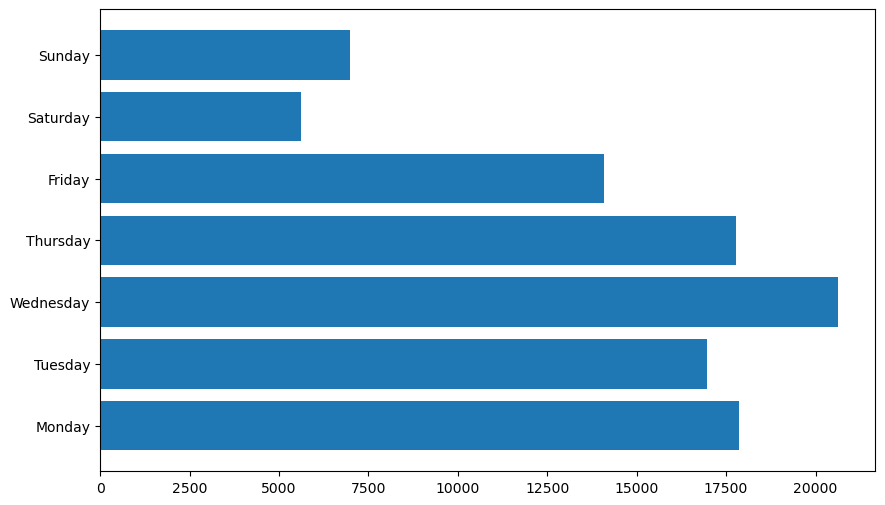

In [88]:
# Graficar el comportamiento de la cantidad de mensajes por dia de la semana
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_rank_mensajes_por_dia['dia_de_semana'] = pd.Categorical(df_rank_mensajes_por_dia['dia_de_semana'], categories=orden_dias, ordered=True)
df_rank_mensajes_por_dia = df_rank_mensajes_por_dia.sort_values('dia_de_semana')

plt.figure(figsize=(10,6))
plt.barh(df_rank_mensajes_por_dia['dia_de_semana'], df_rank_mensajes_por_dia['cantidad_mensajes'])
plt.show();

In [110]:
# Formtear la hora (HH) de cada uno de los mensajes
df_mensajes_transformar['hora_extraida'] = df_mensajes_transformar['Fecha_hora'].dt.strftime('%H')

In [112]:
# Contabilizar la cantidad de mensajes por cada hora
df_rank_mensajes_por_hora = df_mensajes_transformar.groupby('hora_extraida').size().reset_index(name='cantidad_mensajes').sort_values(by='cantidad_mensajes', ascending=False)

In [115]:
df_rank_mensajes_por_hora.head()

,hora_extraida,cantidad_mensajes
11,11,10066
12,12,8403
10,10,8280
13,13,7176
9,09,7053


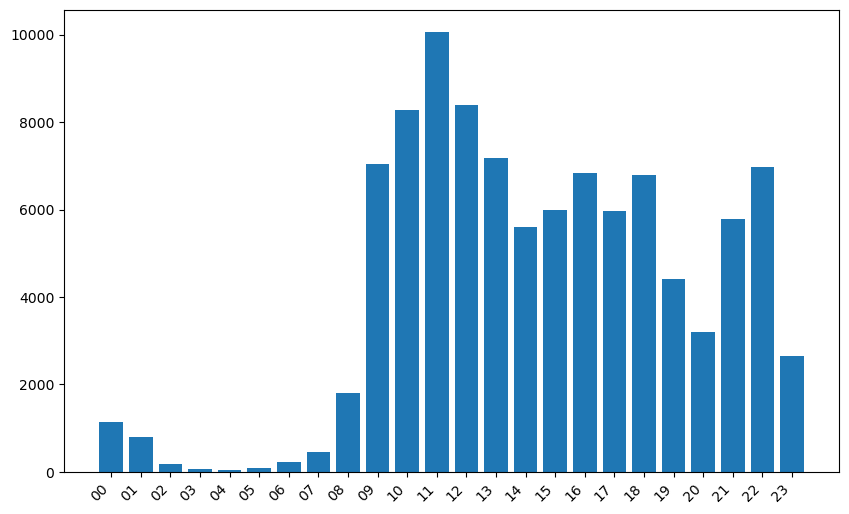

In [116]:
# Graficar el comportamiento de los mensajes por cada una de las horas del día
df_rank_mensajes_por_hora= df_rank_mensajes_por_hora.sort_values(by='hora_extraida', ascending=True)
plt.figure(figsize=(10,6))
plt.bar(df_rank_mensajes_por_hora['hora_extraida'], df_rank_mensajes_por_hora['cantidad_mensajes'])
plt.xticks(range(len(df_rank_mensajes_por_hora['hora_extraida'])), df_rank_mensajes_por_hora['hora_extraida'], rotation=45, ha='right')
plt.show()

In [138]:
# Realizar palabras excluyentes para el Word Cloud

stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el'
                            , 'las', 'los', 'les', 'por', 'es', 'son', 'se', 'para', 'un', 'una'
                            , 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta', 'pero', 'del'
                            , 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y'
                            , 'al', 'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea'
                            , 'esos', 'esto', 'ese', 'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga'
                            , 'ser', 'otra', 'otro', 'mis', 'han', 'omitido multimedia', 'multimedia omitido'
                            , 'multimedia', 'omitido'])

In [140]:
# Obtener el listado de todas las palabras en todos los mensajes
total_palabras = ' '
palabras = ''
n = 0
for mensaje in df_mensajes_transformar['Mensaje'].values:
    print("Mensaje: n°" + str(n))
    palabras = str(mensaje).lower().split()
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' '
    n = n + 1

Mensaje: n°0
Mensaje: n°1
Mensaje: n°2
Mensaje: n°3
Mensaje: n°4
Mensaje: n°5
Mensaje: n°6
Mensaje: n°7
Mensaje: n°8
Mensaje: n°9
Mensaje: n°10
Mensaje: n°11
Mensaje: n°12
Mensaje: n°13
Mensaje: n°14
Mensaje: n°15
Mensaje: n°16
Mensaje: n°17
Mensaje: n°18
Mensaje: n°19
Mensaje: n°20
Mensaje: n°21
Mensaje: n°22
Mensaje: n°23
Mensaje: n°24
Mensaje: n°25
Mensaje: n°26
Mensaje: n°27
Mensaje: n°28
Mensaje: n°29
Mensaje: n°30
Mensaje: n°31
Mensaje: n°32
Mensaje: n°33
Mensaje: n°34
Mensaje: n°35
Mensaje: n°36
Mensaje: n°37
Mensaje: n°38
Mensaje: n°39
Mensaje: n°40
Mensaje: n°41
Mensaje: n°42
Mensaje: n°43
Mensaje: n°44
Mensaje: n°45
Mensaje: n°46
Mensaje: n°47
Mensaje: n°48
Mensaje: n°49
Mensaje: n°50
Mensaje: n°51
Mensaje: n°52
Mensaje: n°53
Mensaje: n°54
Mensaje: n°55
Mensaje: n°56
Mensaje: n°57
Mensaje: n°58
Mensaje: n°59
Mensaje: n°60
Mensaje: n°61
Mensaje: n°62
Mensaje: n°63
Mensaje: n°64
Mensaje: n°65
Mensaje: n°66
Mensaje: n°67
Mensaje: n°68
Mensaje: n°69
Mensaje: n°70
Mensaje: n°71
Me

Mensaje: n°3004
Mensaje: n°3005
Mensaje: n°3006
Mensaje: n°3007
Mensaje: n°3008
Mensaje: n°3009
Mensaje: n°3010
Mensaje: n°3011
Mensaje: n°3012
Mensaje: n°3013
Mensaje: n°3014
Mensaje: n°3015
Mensaje: n°3016
Mensaje: n°3017
Mensaje: n°3018
Mensaje: n°3019
Mensaje: n°3020
Mensaje: n°3021
Mensaje: n°3022
Mensaje: n°3023
Mensaje: n°3024
Mensaje: n°3025
Mensaje: n°3026
Mensaje: n°3027
Mensaje: n°3028
Mensaje: n°3029
Mensaje: n°3030
Mensaje: n°3031
Mensaje: n°3032
Mensaje: n°3033
Mensaje: n°3034
Mensaje: n°3035
Mensaje: n°3036
Mensaje: n°3037
Mensaje: n°3038
Mensaje: n°3039
Mensaje: n°3040
Mensaje: n°3041
Mensaje: n°3042
Mensaje: n°3043
Mensaje: n°3044
Mensaje: n°3045
Mensaje: n°3046
Mensaje: n°3047
Mensaje: n°3048
Mensaje: n°3049
Mensaje: n°3050
Mensaje: n°3051
Mensaje: n°3052
Mensaje: n°3053
Mensaje: n°3054
Mensaje: n°3055
Mensaje: n°3056
Mensaje: n°3057
Mensaje: n°3058
Mensaje: n°3059
Mensaje: n°3060
Mensaje: n°3061
Mensaje: n°3062
Mensaje: n°3063
Mensaje: n°3064
Mensaje: n°3065
Mensaje:

Mensaje: n°4318
Mensaje: n°4319
Mensaje: n°4320
Mensaje: n°4321
Mensaje: n°4322
Mensaje: n°4323
Mensaje: n°4324
Mensaje: n°4325
Mensaje: n°4326
Mensaje: n°4327
Mensaje: n°4328
Mensaje: n°4329
Mensaje: n°4330
Mensaje: n°4331
Mensaje: n°4332
Mensaje: n°4333
Mensaje: n°4334
Mensaje: n°4335
Mensaje: n°4336
Mensaje: n°4337
Mensaje: n°4338
Mensaje: n°4339
Mensaje: n°4340
Mensaje: n°4341
Mensaje: n°4342
Mensaje: n°4343
Mensaje: n°4344
Mensaje: n°4345
Mensaje: n°4346
Mensaje: n°4347
Mensaje: n°4348
Mensaje: n°4349
Mensaje: n°4350
Mensaje: n°4351
Mensaje: n°4352
Mensaje: n°4353
Mensaje: n°4354
Mensaje: n°4355
Mensaje: n°4356
Mensaje: n°4357
Mensaje: n°4358
Mensaje: n°4359
Mensaje: n°4360
Mensaje: n°4361
Mensaje: n°4362
Mensaje: n°4363
Mensaje: n°4364
Mensaje: n°4365
Mensaje: n°4366
Mensaje: n°4367
Mensaje: n°4368
Mensaje: n°4369
Mensaje: n°4370
Mensaje: n°4371
Mensaje: n°4372
Mensaje: n°4373
Mensaje: n°4374
Mensaje: n°4375
Mensaje: n°4376
Mensaje: n°4377
Mensaje: n°4378
Mensaje: n°4379
Mensaje:

Mensaje: n°4933
Mensaje: n°4934
Mensaje: n°4935
Mensaje: n°4936
Mensaje: n°4937
Mensaje: n°4938
Mensaje: n°4939
Mensaje: n°4940
Mensaje: n°4941
Mensaje: n°4942
Mensaje: n°4943
Mensaje: n°4944
Mensaje: n°4945
Mensaje: n°4946
Mensaje: n°4947
Mensaje: n°4948
Mensaje: n°4949
Mensaje: n°4950
Mensaje: n°4951
Mensaje: n°4952
Mensaje: n°4953
Mensaje: n°4954
Mensaje: n°4955
Mensaje: n°4956
Mensaje: n°4957
Mensaje: n°4958
Mensaje: n°4959
Mensaje: n°4960
Mensaje: n°4961
Mensaje: n°4962
Mensaje: n°4963
Mensaje: n°4964
Mensaje: n°4965
Mensaje: n°4966
Mensaje: n°4967
Mensaje: n°4968
Mensaje: n°4969
Mensaje: n°4970
Mensaje: n°4971
Mensaje: n°4972
Mensaje: n°4973
Mensaje: n°4974
Mensaje: n°4975
Mensaje: n°4976
Mensaje: n°4977
Mensaje: n°4978
Mensaje: n°4979
Mensaje: n°4980
Mensaje: n°4981
Mensaje: n°4982
Mensaje: n°4983
Mensaje: n°4984
Mensaje: n°4985
Mensaje: n°4986
Mensaje: n°4987
Mensaje: n°4988
Mensaje: n°4989
Mensaje: n°4990
Mensaje: n°4991
Mensaje: n°4992
Mensaje: n°4993
Mensaje: n°4994
Mensaje:

Mensaje: n°5844
Mensaje: n°5845
Mensaje: n°5846
Mensaje: n°5847
Mensaje: n°5848
Mensaje: n°5849
Mensaje: n°5850
Mensaje: n°5851
Mensaje: n°5852
Mensaje: n°5853
Mensaje: n°5854
Mensaje: n°5855
Mensaje: n°5856
Mensaje: n°5857
Mensaje: n°5858
Mensaje: n°5859
Mensaje: n°5860
Mensaje: n°5861
Mensaje: n°5862
Mensaje: n°5863
Mensaje: n°5864
Mensaje: n°5865
Mensaje: n°5866
Mensaje: n°5867
Mensaje: n°5868
Mensaje: n°5869
Mensaje: n°5870
Mensaje: n°5871
Mensaje: n°5872
Mensaje: n°5873
Mensaje: n°5874
Mensaje: n°5875
Mensaje: n°5876
Mensaje: n°5877
Mensaje: n°5878
Mensaje: n°5879
Mensaje: n°5880
Mensaje: n°5881
Mensaje: n°5882
Mensaje: n°5883
Mensaje: n°5884
Mensaje: n°5885
Mensaje: n°5886
Mensaje: n°5887
Mensaje: n°5888
Mensaje: n°5889
Mensaje: n°5890
Mensaje: n°5891
Mensaje: n°5892
Mensaje: n°5893
Mensaje: n°5894
Mensaje: n°5895
Mensaje: n°5896
Mensaje: n°5897
Mensaje: n°5898
Mensaje: n°5899
Mensaje: n°5900
Mensaje: n°5901
Mensaje: n°5902
Mensaje: n°5903
Mensaje: n°5904
Mensaje: n°5905
Mensaje:

Mensaje: n°6896
Mensaje: n°6897
Mensaje: n°6898
Mensaje: n°6899
Mensaje: n°6900
Mensaje: n°6901
Mensaje: n°6902
Mensaje: n°6903
Mensaje: n°6904
Mensaje: n°6905
Mensaje: n°6906
Mensaje: n°6907
Mensaje: n°6908
Mensaje: n°6909
Mensaje: n°6910
Mensaje: n°6911
Mensaje: n°6912
Mensaje: n°6913
Mensaje: n°6914
Mensaje: n°6915
Mensaje: n°6916
Mensaje: n°6917
Mensaje: n°6918
Mensaje: n°6919
Mensaje: n°6920
Mensaje: n°6921
Mensaje: n°6922
Mensaje: n°6923
Mensaje: n°6924
Mensaje: n°6925
Mensaje: n°6926
Mensaje: n°6927
Mensaje: n°6928
Mensaje: n°6929
Mensaje: n°6930
Mensaje: n°6931
Mensaje: n°6932
Mensaje: n°6933
Mensaje: n°6934
Mensaje: n°6935
Mensaje: n°6936
Mensaje: n°6937
Mensaje: n°6938
Mensaje: n°6939
Mensaje: n°6940
Mensaje: n°6941
Mensaje: n°6942
Mensaje: n°6943
Mensaje: n°6944
Mensaje: n°6945
Mensaje: n°6946
Mensaje: n°6947
Mensaje: n°6948
Mensaje: n°6949
Mensaje: n°6950
Mensaje: n°6951
Mensaje: n°6952
Mensaje: n°6953
Mensaje: n°6954
Mensaje: n°6955
Mensaje: n°6956
Mensaje: n°6957
Mensaje:

Mensaje: n°7462
Mensaje: n°7463
Mensaje: n°7464
Mensaje: n°7465
Mensaje: n°7466
Mensaje: n°7467
Mensaje: n°7468
Mensaje: n°7469
Mensaje: n°7470
Mensaje: n°7471
Mensaje: n°7472
Mensaje: n°7473
Mensaje: n°7474
Mensaje: n°7475
Mensaje: n°7476
Mensaje: n°7477
Mensaje: n°7478
Mensaje: n°7479
Mensaje: n°7480
Mensaje: n°7481
Mensaje: n°7482
Mensaje: n°7483
Mensaje: n°7484
Mensaje: n°7485
Mensaje: n°7486
Mensaje: n°7487
Mensaje: n°7488
Mensaje: n°7489
Mensaje: n°7490
Mensaje: n°7491
Mensaje: n°7492
Mensaje: n°7493
Mensaje: n°7494
Mensaje: n°7495
Mensaje: n°7496
Mensaje: n°7497
Mensaje: n°7498
Mensaje: n°7499
Mensaje: n°7500
Mensaje: n°7501
Mensaje: n°7502
Mensaje: n°7503
Mensaje: n°7504
Mensaje: n°7505
Mensaje: n°7506
Mensaje: n°7507
Mensaje: n°7508
Mensaje: n°7509
Mensaje: n°7510
Mensaje: n°7511
Mensaje: n°7512
Mensaje: n°7513
Mensaje: n°7514
Mensaje: n°7515
Mensaje: n°7516
Mensaje: n°7517
Mensaje: n°7518
Mensaje: n°7519
Mensaje: n°7520
Mensaje: n°7521
Mensaje: n°7522
Mensaje: n°7523
Mensaje:

Mensaje: n°8435
Mensaje: n°8436
Mensaje: n°8437
Mensaje: n°8438
Mensaje: n°8439
Mensaje: n°8440
Mensaje: n°8441
Mensaje: n°8442
Mensaje: n°8443
Mensaje: n°8444
Mensaje: n°8445
Mensaje: n°8446
Mensaje: n°8447
Mensaje: n°8448
Mensaje: n°8449
Mensaje: n°8450
Mensaje: n°8451
Mensaje: n°8452
Mensaje: n°8453
Mensaje: n°8454
Mensaje: n°8455
Mensaje: n°8456
Mensaje: n°8457
Mensaje: n°8458
Mensaje: n°8459
Mensaje: n°8460
Mensaje: n°8461
Mensaje: n°8462
Mensaje: n°8463
Mensaje: n°8464
Mensaje: n°8465
Mensaje: n°8466
Mensaje: n°8467
Mensaje: n°8468
Mensaje: n°8469
Mensaje: n°8470
Mensaje: n°8471
Mensaje: n°8472
Mensaje: n°8473
Mensaje: n°8474
Mensaje: n°8475
Mensaje: n°8476
Mensaje: n°8477
Mensaje: n°8478
Mensaje: n°8479
Mensaje: n°8480
Mensaje: n°8481
Mensaje: n°8482
Mensaje: n°8483
Mensaje: n°8484
Mensaje: n°8485
Mensaje: n°8486
Mensaje: n°8487
Mensaje: n°8488
Mensaje: n°8489
Mensaje: n°8490
Mensaje: n°8491
Mensaje: n°8492
Mensaje: n°8493
Mensaje: n°8494
Mensaje: n°8495
Mensaje: n°8496
Mensaje:

Mensaje: n°9405
Mensaje: n°9406
Mensaje: n°9407
Mensaje: n°9408
Mensaje: n°9409
Mensaje: n°9410
Mensaje: n°9411
Mensaje: n°9412
Mensaje: n°9413
Mensaje: n°9414
Mensaje: n°9415
Mensaje: n°9416
Mensaje: n°9417
Mensaje: n°9418
Mensaje: n°9419
Mensaje: n°9420
Mensaje: n°9421
Mensaje: n°9422
Mensaje: n°9423
Mensaje: n°9424
Mensaje: n°9425
Mensaje: n°9426
Mensaje: n°9427
Mensaje: n°9428
Mensaje: n°9429
Mensaje: n°9430
Mensaje: n°9431
Mensaje: n°9432
Mensaje: n°9433
Mensaje: n°9434
Mensaje: n°9435
Mensaje: n°9436
Mensaje: n°9437
Mensaje: n°9438
Mensaje: n°9439
Mensaje: n°9440
Mensaje: n°9441
Mensaje: n°9442
Mensaje: n°9443
Mensaje: n°9444
Mensaje: n°9445
Mensaje: n°9446
Mensaje: n°9447
Mensaje: n°9448
Mensaje: n°9449
Mensaje: n°9450
Mensaje: n°9451
Mensaje: n°9452
Mensaje: n°9453
Mensaje: n°9454
Mensaje: n°9455
Mensaje: n°9456
Mensaje: n°9457
Mensaje: n°9458
Mensaje: n°9459
Mensaje: n°9460
Mensaje: n°9461
Mensaje: n°9462
Mensaje: n°9463
Mensaje: n°9464
Mensaje: n°9465
Mensaje: n°9466
Mensaje:

Mensaje: n°9973
Mensaje: n°9974
Mensaje: n°9975
Mensaje: n°9976
Mensaje: n°9977
Mensaje: n°9978
Mensaje: n°9979
Mensaje: n°9980
Mensaje: n°9981
Mensaje: n°9982
Mensaje: n°9983
Mensaje: n°9984
Mensaje: n°9985
Mensaje: n°9986
Mensaje: n°9987
Mensaje: n°9988
Mensaje: n°9989
Mensaje: n°9990
Mensaje: n°9991
Mensaje: n°9992
Mensaje: n°9993
Mensaje: n°9994
Mensaje: n°9995
Mensaje: n°9996
Mensaje: n°9997
Mensaje: n°9998
Mensaje: n°9999
Mensaje: n°10000
Mensaje: n°10001
Mensaje: n°10002
Mensaje: n°10003
Mensaje: n°10004
Mensaje: n°10005
Mensaje: n°10006
Mensaje: n°10007
Mensaje: n°10008
Mensaje: n°10009
Mensaje: n°10010
Mensaje: n°10011
Mensaje: n°10012
Mensaje: n°10013
Mensaje: n°10014
Mensaje: n°10015
Mensaje: n°10016
Mensaje: n°10017
Mensaje: n°10018
Mensaje: n°10019
Mensaje: n°10020
Mensaje: n°10021
Mensaje: n°10022
Mensaje: n°10023
Mensaje: n°10024
Mensaje: n°10025
Mensaje: n°10026
Mensaje: n°10027
Mensaje: n°10028
Mensaje: n°10029
Mensaje: n°10030
Mensaje: n°10031
Mensaje: n°10032
Mensaje

Mensaje: n°10511
Mensaje: n°10512
Mensaje: n°10513
Mensaje: n°10514
Mensaje: n°10515
Mensaje: n°10516
Mensaje: n°10517
Mensaje: n°10518
Mensaje: n°10519
Mensaje: n°10520
Mensaje: n°10521
Mensaje: n°10522
Mensaje: n°10523
Mensaje: n°10524
Mensaje: n°10525
Mensaje: n°10526
Mensaje: n°10527
Mensaje: n°10528
Mensaje: n°10529
Mensaje: n°10530
Mensaje: n°10531
Mensaje: n°10532
Mensaje: n°10533
Mensaje: n°10534
Mensaje: n°10535
Mensaje: n°10536
Mensaje: n°10537
Mensaje: n°10538
Mensaje: n°10539
Mensaje: n°10540
Mensaje: n°10541
Mensaje: n°10542
Mensaje: n°10543
Mensaje: n°10544
Mensaje: n°10545
Mensaje: n°10546
Mensaje: n°10547
Mensaje: n°10548
Mensaje: n°10549
Mensaje: n°10550
Mensaje: n°10551
Mensaje: n°10552
Mensaje: n°10553
Mensaje: n°10554
Mensaje: n°10555
Mensaje: n°10556
Mensaje: n°10557
Mensaje: n°10558
Mensaje: n°10559
Mensaje: n°10560
Mensaje: n°10561
Mensaje: n°10562
Mensaje: n°10563
Mensaje: n°10564
Mensaje: n°10565
Mensaje: n°10566
Mensaje: n°10567
Mensaje: n°10568
Mensaje: n°105

Mensaje: n°11043
Mensaje: n°11044
Mensaje: n°11045
Mensaje: n°11046
Mensaje: n°11047
Mensaje: n°11048
Mensaje: n°11049
Mensaje: n°11050
Mensaje: n°11051
Mensaje: n°11052
Mensaje: n°11053
Mensaje: n°11054
Mensaje: n°11055
Mensaje: n°11056
Mensaje: n°11057
Mensaje: n°11058
Mensaje: n°11059
Mensaje: n°11060
Mensaje: n°11061
Mensaje: n°11062
Mensaje: n°11063
Mensaje: n°11064
Mensaje: n°11065
Mensaje: n°11066
Mensaje: n°11067
Mensaje: n°11068
Mensaje: n°11069
Mensaje: n°11070
Mensaje: n°11071
Mensaje: n°11072
Mensaje: n°11073
Mensaje: n°11074
Mensaje: n°11075
Mensaje: n°11076
Mensaje: n°11077
Mensaje: n°11078
Mensaje: n°11079
Mensaje: n°11080
Mensaje: n°11081
Mensaje: n°11082
Mensaje: n°11083
Mensaje: n°11084
Mensaje: n°11085
Mensaje: n°11086
Mensaje: n°11087
Mensaje: n°11088
Mensaje: n°11089
Mensaje: n°11090
Mensaje: n°11091
Mensaje: n°11092
Mensaje: n°11093
Mensaje: n°11094
Mensaje: n°11095
Mensaje: n°11096
Mensaje: n°11097
Mensaje: n°11098
Mensaje: n°11099
Mensaje: n°11100
Mensaje: n°111

Mensaje: n°11562
Mensaje: n°11563
Mensaje: n°11564
Mensaje: n°11565
Mensaje: n°11566
Mensaje: n°11567
Mensaje: n°11568
Mensaje: n°11569
Mensaje: n°11570
Mensaje: n°11571
Mensaje: n°11572
Mensaje: n°11573
Mensaje: n°11574
Mensaje: n°11575
Mensaje: n°11576
Mensaje: n°11577
Mensaje: n°11578
Mensaje: n°11579
Mensaje: n°11580
Mensaje: n°11581
Mensaje: n°11582
Mensaje: n°11583
Mensaje: n°11584
Mensaje: n°11585
Mensaje: n°11586
Mensaje: n°11587
Mensaje: n°11588
Mensaje: n°11589
Mensaje: n°11590
Mensaje: n°11591
Mensaje: n°11592
Mensaje: n°11593
Mensaje: n°11594
Mensaje: n°11595
Mensaje: n°11596
Mensaje: n°11597
Mensaje: n°11598
Mensaje: n°11599
Mensaje: n°11600
Mensaje: n°11601
Mensaje: n°11602
Mensaje: n°11603
Mensaje: n°11604
Mensaje: n°11605
Mensaje: n°11606
Mensaje: n°11607
Mensaje: n°11608
Mensaje: n°11609
Mensaje: n°11610
Mensaje: n°11611
Mensaje: n°11612
Mensaje: n°11613
Mensaje: n°11614
Mensaje: n°11615
Mensaje: n°11616
Mensaje: n°11617
Mensaje: n°11618
Mensaje: n°11619
Mensaje: n°116

Mensaje: n°12050
Mensaje: n°12051
Mensaje: n°12052
Mensaje: n°12053
Mensaje: n°12054
Mensaje: n°12055
Mensaje: n°12056
Mensaje: n°12057
Mensaje: n°12058
Mensaje: n°12059
Mensaje: n°12060
Mensaje: n°12061
Mensaje: n°12062
Mensaje: n°12063
Mensaje: n°12064
Mensaje: n°12065
Mensaje: n°12066
Mensaje: n°12067
Mensaje: n°12068
Mensaje: n°12069
Mensaje: n°12070
Mensaje: n°12071
Mensaje: n°12072
Mensaje: n°12073
Mensaje: n°12074
Mensaje: n°12075
Mensaje: n°12076
Mensaje: n°12077
Mensaje: n°12078
Mensaje: n°12079
Mensaje: n°12080
Mensaje: n°12081
Mensaje: n°12082
Mensaje: n°12083
Mensaje: n°12084
Mensaje: n°12085
Mensaje: n°12086
Mensaje: n°12087
Mensaje: n°12088
Mensaje: n°12089
Mensaje: n°12090
Mensaje: n°12091
Mensaje: n°12092
Mensaje: n°12093
Mensaje: n°12094
Mensaje: n°12095
Mensaje: n°12096
Mensaje: n°12097
Mensaje: n°12098
Mensaje: n°12099
Mensaje: n°12100
Mensaje: n°12101
Mensaje: n°12102
Mensaje: n°12103
Mensaje: n°12104
Mensaje: n°12105
Mensaje: n°12106
Mensaje: n°12107
Mensaje: n°121

Mensaje: n°12567
Mensaje: n°12568
Mensaje: n°12569
Mensaje: n°12570
Mensaje: n°12571
Mensaje: n°12572
Mensaje: n°12573
Mensaje: n°12574
Mensaje: n°12575
Mensaje: n°12576
Mensaje: n°12577
Mensaje: n°12578
Mensaje: n°12579
Mensaje: n°12580
Mensaje: n°12581
Mensaje: n°12582
Mensaje: n°12583
Mensaje: n°12584
Mensaje: n°12585
Mensaje: n°12586
Mensaje: n°12587
Mensaje: n°12588
Mensaje: n°12589
Mensaje: n°12590
Mensaje: n°12591
Mensaje: n°12592
Mensaje: n°12593
Mensaje: n°12594
Mensaje: n°12595
Mensaje: n°12596
Mensaje: n°12597
Mensaje: n°12598
Mensaje: n°12599
Mensaje: n°12600
Mensaje: n°12601
Mensaje: n°12602
Mensaje: n°12603
Mensaje: n°12604
Mensaje: n°12605
Mensaje: n°12606
Mensaje: n°12607
Mensaje: n°12608
Mensaje: n°12609
Mensaje: n°12610
Mensaje: n°12611
Mensaje: n°12612
Mensaje: n°12613
Mensaje: n°12614
Mensaje: n°12615
Mensaje: n°12616
Mensaje: n°12617
Mensaje: n°12618
Mensaje: n°12619
Mensaje: n°12620
Mensaje: n°12621
Mensaje: n°12622
Mensaje: n°12623
Mensaje: n°12624
Mensaje: n°126

Mensaje: n°13056
Mensaje: n°13057
Mensaje: n°13058
Mensaje: n°13059
Mensaje: n°13060
Mensaje: n°13061
Mensaje: n°13062
Mensaje: n°13063
Mensaje: n°13064
Mensaje: n°13065
Mensaje: n°13066
Mensaje: n°13067
Mensaje: n°13068
Mensaje: n°13069
Mensaje: n°13070
Mensaje: n°13071
Mensaje: n°13072
Mensaje: n°13073
Mensaje: n°13074
Mensaje: n°13075
Mensaje: n°13076
Mensaje: n°13077
Mensaje: n°13078
Mensaje: n°13079
Mensaje: n°13080
Mensaje: n°13081
Mensaje: n°13082
Mensaje: n°13083
Mensaje: n°13084
Mensaje: n°13085
Mensaje: n°13086
Mensaje: n°13087
Mensaje: n°13088
Mensaje: n°13089
Mensaje: n°13090
Mensaje: n°13091
Mensaje: n°13092
Mensaje: n°13093
Mensaje: n°13094
Mensaje: n°13095
Mensaje: n°13096
Mensaje: n°13097
Mensaje: n°13098
Mensaje: n°13099
Mensaje: n°13100
Mensaje: n°13101
Mensaje: n°13102
Mensaje: n°13103
Mensaje: n°13104
Mensaje: n°13105
Mensaje: n°13106
Mensaje: n°13107
Mensaje: n°13108
Mensaje: n°13109
Mensaje: n°13110
Mensaje: n°13111
Mensaje: n°13112
Mensaje: n°13113
Mensaje: n°131

Mensaje: n°13550
Mensaje: n°13551
Mensaje: n°13552
Mensaje: n°13553
Mensaje: n°13554
Mensaje: n°13555
Mensaje: n°13556
Mensaje: n°13557
Mensaje: n°13558
Mensaje: n°13559
Mensaje: n°13560
Mensaje: n°13561
Mensaje: n°13562
Mensaje: n°13563
Mensaje: n°13564
Mensaje: n°13565
Mensaje: n°13566
Mensaje: n°13567
Mensaje: n°13568
Mensaje: n°13569
Mensaje: n°13570
Mensaje: n°13571
Mensaje: n°13572
Mensaje: n°13573
Mensaje: n°13574
Mensaje: n°13575
Mensaje: n°13576
Mensaje: n°13577
Mensaje: n°13578
Mensaje: n°13579
Mensaje: n°13580
Mensaje: n°13581
Mensaje: n°13582
Mensaje: n°13583
Mensaje: n°13584
Mensaje: n°13585
Mensaje: n°13586
Mensaje: n°13587
Mensaje: n°13588
Mensaje: n°13589
Mensaje: n°13590
Mensaje: n°13591
Mensaje: n°13592
Mensaje: n°13593
Mensaje: n°13594
Mensaje: n°13595
Mensaje: n°13596
Mensaje: n°13597
Mensaje: n°13598
Mensaje: n°13599
Mensaje: n°13600
Mensaje: n°13601
Mensaje: n°13602
Mensaje: n°13603
Mensaje: n°13604
Mensaje: n°13605
Mensaje: n°13606
Mensaje: n°13607
Mensaje: n°136

Mensaje: n°14036
Mensaje: n°14037
Mensaje: n°14038
Mensaje: n°14039
Mensaje: n°14040
Mensaje: n°14041
Mensaje: n°14042
Mensaje: n°14043
Mensaje: n°14044
Mensaje: n°14045
Mensaje: n°14046
Mensaje: n°14047
Mensaje: n°14048
Mensaje: n°14049
Mensaje: n°14050
Mensaje: n°14051
Mensaje: n°14052
Mensaje: n°14053
Mensaje: n°14054
Mensaje: n°14055
Mensaje: n°14056
Mensaje: n°14057
Mensaje: n°14058
Mensaje: n°14059
Mensaje: n°14060
Mensaje: n°14061
Mensaje: n°14062
Mensaje: n°14063
Mensaje: n°14064
Mensaje: n°14065
Mensaje: n°14066
Mensaje: n°14067
Mensaje: n°14068
Mensaje: n°14069
Mensaje: n°14070
Mensaje: n°14071
Mensaje: n°14072
Mensaje: n°14073
Mensaje: n°14074
Mensaje: n°14075
Mensaje: n°14076
Mensaje: n°14077
Mensaje: n°14078
Mensaje: n°14079
Mensaje: n°14080
Mensaje: n°14081
Mensaje: n°14082
Mensaje: n°14083
Mensaje: n°14084
Mensaje: n°14085
Mensaje: n°14086
Mensaje: n°14087
Mensaje: n°14088
Mensaje: n°14089
Mensaje: n°14090
Mensaje: n°14091
Mensaje: n°14092
Mensaje: n°14093
Mensaje: n°140

Mensaje: n°14554
Mensaje: n°14555
Mensaje: n°14556
Mensaje: n°14557
Mensaje: n°14558
Mensaje: n°14559
Mensaje: n°14560
Mensaje: n°14561
Mensaje: n°14562
Mensaje: n°14563
Mensaje: n°14564
Mensaje: n°14565
Mensaje: n°14566
Mensaje: n°14567
Mensaje: n°14568
Mensaje: n°14569
Mensaje: n°14570
Mensaje: n°14571
Mensaje: n°14572
Mensaje: n°14573
Mensaje: n°14574
Mensaje: n°14575
Mensaje: n°14576
Mensaje: n°14577
Mensaje: n°14578
Mensaje: n°14579
Mensaje: n°14580
Mensaje: n°14581
Mensaje: n°14582
Mensaje: n°14583
Mensaje: n°14584
Mensaje: n°14585
Mensaje: n°14586
Mensaje: n°14587
Mensaje: n°14588
Mensaje: n°14589
Mensaje: n°14590
Mensaje: n°14591
Mensaje: n°14592
Mensaje: n°14593
Mensaje: n°14594
Mensaje: n°14595
Mensaje: n°14596
Mensaje: n°14597
Mensaje: n°14598
Mensaje: n°14599
Mensaje: n°14600
Mensaje: n°14601
Mensaje: n°14602
Mensaje: n°14603
Mensaje: n°14604
Mensaje: n°14605
Mensaje: n°14606
Mensaje: n°14607
Mensaje: n°14608
Mensaje: n°14609
Mensaje: n°14610
Mensaje: n°14611
Mensaje: n°146

Mensaje: n°15068
Mensaje: n°15069
Mensaje: n°15070
Mensaje: n°15071
Mensaje: n°15072
Mensaje: n°15073
Mensaje: n°15074
Mensaje: n°15075
Mensaje: n°15076
Mensaje: n°15077
Mensaje: n°15078
Mensaje: n°15079
Mensaje: n°15080
Mensaje: n°15081
Mensaje: n°15082
Mensaje: n°15083
Mensaje: n°15084
Mensaje: n°15085
Mensaje: n°15086
Mensaje: n°15087
Mensaje: n°15088
Mensaje: n°15089
Mensaje: n°15090
Mensaje: n°15091
Mensaje: n°15092
Mensaje: n°15093
Mensaje: n°15094
Mensaje: n°15095
Mensaje: n°15096
Mensaje: n°15097
Mensaje: n°15098
Mensaje: n°15099
Mensaje: n°15100
Mensaje: n°15101
Mensaje: n°15102
Mensaje: n°15103
Mensaje: n°15104
Mensaje: n°15105
Mensaje: n°15106
Mensaje: n°15107
Mensaje: n°15108
Mensaje: n°15109
Mensaje: n°15110
Mensaje: n°15111
Mensaje: n°15112
Mensaje: n°15113
Mensaje: n°15114
Mensaje: n°15115
Mensaje: n°15116
Mensaje: n°15117
Mensaje: n°15118
Mensaje: n°15119
Mensaje: n°15120
Mensaje: n°15121
Mensaje: n°15122
Mensaje: n°15123
Mensaje: n°15124
Mensaje: n°15125
Mensaje: n°151

Mensaje: n°15568
Mensaje: n°15569
Mensaje: n°15570
Mensaje: n°15571
Mensaje: n°15572
Mensaje: n°15573
Mensaje: n°15574
Mensaje: n°15575
Mensaje: n°15576
Mensaje: n°15577
Mensaje: n°15578
Mensaje: n°15579
Mensaje: n°15580
Mensaje: n°15581
Mensaje: n°15582
Mensaje: n°15583
Mensaje: n°15584
Mensaje: n°15585
Mensaje: n°15586
Mensaje: n°15587
Mensaje: n°15588
Mensaje: n°15589
Mensaje: n°15590
Mensaje: n°15591
Mensaje: n°15592
Mensaje: n°15593
Mensaje: n°15594
Mensaje: n°15595
Mensaje: n°15596
Mensaje: n°15597
Mensaje: n°15598
Mensaje: n°15599
Mensaje: n°15600
Mensaje: n°15601
Mensaje: n°15602
Mensaje: n°15603
Mensaje: n°15604
Mensaje: n°15605
Mensaje: n°15606
Mensaje: n°15607
Mensaje: n°15608
Mensaje: n°15609
Mensaje: n°15610
Mensaje: n°15611
Mensaje: n°15612
Mensaje: n°15613
Mensaje: n°15614
Mensaje: n°15615
Mensaje: n°15616
Mensaje: n°15617
Mensaje: n°15618
Mensaje: n°15619
Mensaje: n°15620
Mensaje: n°15621
Mensaje: n°15622
Mensaje: n°15623
Mensaje: n°15624
Mensaje: n°15625
Mensaje: n°156

Mensaje: n°16061
Mensaje: n°16062
Mensaje: n°16063
Mensaje: n°16064
Mensaje: n°16065
Mensaje: n°16066
Mensaje: n°16067
Mensaje: n°16068
Mensaje: n°16069
Mensaje: n°16070
Mensaje: n°16071
Mensaje: n°16072
Mensaje: n°16073
Mensaje: n°16074
Mensaje: n°16075
Mensaje: n°16076
Mensaje: n°16077
Mensaje: n°16078
Mensaje: n°16079
Mensaje: n°16080
Mensaje: n°16081
Mensaje: n°16082
Mensaje: n°16083
Mensaje: n°16084
Mensaje: n°16085
Mensaje: n°16086
Mensaje: n°16087
Mensaje: n°16088
Mensaje: n°16089
Mensaje: n°16090
Mensaje: n°16091
Mensaje: n°16092
Mensaje: n°16093
Mensaje: n°16094
Mensaje: n°16095
Mensaje: n°16096
Mensaje: n°16097
Mensaje: n°16098
Mensaje: n°16099
Mensaje: n°16100
Mensaje: n°16101
Mensaje: n°16102
Mensaje: n°16103
Mensaje: n°16104
Mensaje: n°16105
Mensaje: n°16106
Mensaje: n°16107
Mensaje: n°16108
Mensaje: n°16109
Mensaje: n°16110
Mensaje: n°16111
Mensaje: n°16112
Mensaje: n°16113
Mensaje: n°16114
Mensaje: n°16115
Mensaje: n°16116
Mensaje: n°16117
Mensaje: n°16118
Mensaje: n°161

Mensaje: n°16576
Mensaje: n°16577
Mensaje: n°16578
Mensaje: n°16579
Mensaje: n°16580
Mensaje: n°16581
Mensaje: n°16582
Mensaje: n°16583
Mensaje: n°16584
Mensaje: n°16585
Mensaje: n°16586
Mensaje: n°16587
Mensaje: n°16588
Mensaje: n°16589
Mensaje: n°16590
Mensaje: n°16591
Mensaje: n°16592
Mensaje: n°16593
Mensaje: n°16594
Mensaje: n°16595
Mensaje: n°16596
Mensaje: n°16597
Mensaje: n°16598
Mensaje: n°16599
Mensaje: n°16600
Mensaje: n°16601
Mensaje: n°16602
Mensaje: n°16603
Mensaje: n°16604
Mensaje: n°16605
Mensaje: n°16606
Mensaje: n°16607
Mensaje: n°16608
Mensaje: n°16609
Mensaje: n°16610
Mensaje: n°16611
Mensaje: n°16612
Mensaje: n°16613
Mensaje: n°16614
Mensaje: n°16615
Mensaje: n°16616
Mensaje: n°16617
Mensaje: n°16618
Mensaje: n°16619
Mensaje: n°16620
Mensaje: n°16621
Mensaje: n°16622
Mensaje: n°16623
Mensaje: n°16624
Mensaje: n°16625
Mensaje: n°16626
Mensaje: n°16627
Mensaje: n°16628
Mensaje: n°16629
Mensaje: n°16630
Mensaje: n°16631
Mensaje: n°16632
Mensaje: n°16633
Mensaje: n°166

Mensaje: n°17081
Mensaje: n°17082
Mensaje: n°17083
Mensaje: n°17084
Mensaje: n°17085
Mensaje: n°17086
Mensaje: n°17087
Mensaje: n°17088
Mensaje: n°17089
Mensaje: n°17090
Mensaje: n°17091
Mensaje: n°17092
Mensaje: n°17093
Mensaje: n°17094
Mensaje: n°17095
Mensaje: n°17096
Mensaje: n°17097
Mensaje: n°17098
Mensaje: n°17099
Mensaje: n°17100
Mensaje: n°17101
Mensaje: n°17102
Mensaje: n°17103
Mensaje: n°17104
Mensaje: n°17105
Mensaje: n°17106
Mensaje: n°17107
Mensaje: n°17108
Mensaje: n°17109
Mensaje: n°17110
Mensaje: n°17111
Mensaje: n°17112
Mensaje: n°17113
Mensaje: n°17114
Mensaje: n°17115
Mensaje: n°17116
Mensaje: n°17117
Mensaje: n°17118
Mensaje: n°17119
Mensaje: n°17120
Mensaje: n°17121
Mensaje: n°17122
Mensaje: n°17123
Mensaje: n°17124
Mensaje: n°17125
Mensaje: n°17126
Mensaje: n°17127
Mensaje: n°17128
Mensaje: n°17129
Mensaje: n°17130
Mensaje: n°17131
Mensaje: n°17132
Mensaje: n°17133
Mensaje: n°17134
Mensaje: n°17135
Mensaje: n°17136
Mensaje: n°17137
Mensaje: n°17138
Mensaje: n°171

Mensaje: n°17563
Mensaje: n°17564
Mensaje: n°17565
Mensaje: n°17566
Mensaje: n°17567
Mensaje: n°17568
Mensaje: n°17569
Mensaje: n°17570
Mensaje: n°17571
Mensaje: n°17572
Mensaje: n°17573
Mensaje: n°17574
Mensaje: n°17575
Mensaje: n°17576
Mensaje: n°17577
Mensaje: n°17578
Mensaje: n°17579
Mensaje: n°17580
Mensaje: n°17581
Mensaje: n°17582
Mensaje: n°17583
Mensaje: n°17584
Mensaje: n°17585
Mensaje: n°17586
Mensaje: n°17587
Mensaje: n°17588
Mensaje: n°17589
Mensaje: n°17590
Mensaje: n°17591
Mensaje: n°17592
Mensaje: n°17593
Mensaje: n°17594
Mensaje: n°17595
Mensaje: n°17596
Mensaje: n°17597
Mensaje: n°17598
Mensaje: n°17599
Mensaje: n°17600
Mensaje: n°17601
Mensaje: n°17602
Mensaje: n°17603
Mensaje: n°17604
Mensaje: n°17605
Mensaje: n°17606
Mensaje: n°17607
Mensaje: n°17608
Mensaje: n°17609
Mensaje: n°17610
Mensaje: n°17611
Mensaje: n°17612
Mensaje: n°17613
Mensaje: n°17614
Mensaje: n°17615
Mensaje: n°17616
Mensaje: n°17617
Mensaje: n°17618
Mensaje: n°17619
Mensaje: n°17620
Mensaje: n°176

Mensaje: n°18058
Mensaje: n°18059
Mensaje: n°18060
Mensaje: n°18061
Mensaje: n°18062
Mensaje: n°18063
Mensaje: n°18064
Mensaje: n°18065
Mensaje: n°18066
Mensaje: n°18067
Mensaje: n°18068
Mensaje: n°18069
Mensaje: n°18070
Mensaje: n°18071
Mensaje: n°18072
Mensaje: n°18073
Mensaje: n°18074
Mensaje: n°18075
Mensaje: n°18076
Mensaje: n°18077
Mensaje: n°18078
Mensaje: n°18079
Mensaje: n°18080
Mensaje: n°18081
Mensaje: n°18082
Mensaje: n°18083
Mensaje: n°18084
Mensaje: n°18085
Mensaje: n°18086
Mensaje: n°18087
Mensaje: n°18088
Mensaje: n°18089
Mensaje: n°18090
Mensaje: n°18091
Mensaje: n°18092
Mensaje: n°18093
Mensaje: n°18094
Mensaje: n°18095
Mensaje: n°18096
Mensaje: n°18097
Mensaje: n°18098
Mensaje: n°18099
Mensaje: n°18100
Mensaje: n°18101
Mensaje: n°18102
Mensaje: n°18103
Mensaje: n°18104
Mensaje: n°18105
Mensaje: n°18106
Mensaje: n°18107
Mensaje: n°18108
Mensaje: n°18109
Mensaje: n°18110
Mensaje: n°18111
Mensaje: n°18112
Mensaje: n°18113
Mensaje: n°18114
Mensaje: n°18115
Mensaje: n°181

Mensaje: n°18562
Mensaje: n°18563
Mensaje: n°18564
Mensaje: n°18565
Mensaje: n°18566
Mensaje: n°18567
Mensaje: n°18568
Mensaje: n°18569
Mensaje: n°18570
Mensaje: n°18571
Mensaje: n°18572
Mensaje: n°18573
Mensaje: n°18574
Mensaje: n°18575
Mensaje: n°18576
Mensaje: n°18577
Mensaje: n°18578
Mensaje: n°18579
Mensaje: n°18580
Mensaje: n°18581
Mensaje: n°18582
Mensaje: n°18583
Mensaje: n°18584
Mensaje: n°18585
Mensaje: n°18586
Mensaje: n°18587
Mensaje: n°18588
Mensaje: n°18589
Mensaje: n°18590
Mensaje: n°18591
Mensaje: n°18592
Mensaje: n°18593
Mensaje: n°18594
Mensaje: n°18595
Mensaje: n°18596
Mensaje: n°18597
Mensaje: n°18598
Mensaje: n°18599
Mensaje: n°18600
Mensaje: n°18601
Mensaje: n°18602
Mensaje: n°18603
Mensaje: n°18604
Mensaje: n°18605
Mensaje: n°18606
Mensaje: n°18607
Mensaje: n°18608
Mensaje: n°18609
Mensaje: n°18610
Mensaje: n°18611
Mensaje: n°18612
Mensaje: n°18613
Mensaje: n°18614
Mensaje: n°18615
Mensaje: n°18616
Mensaje: n°18617
Mensaje: n°18618
Mensaje: n°18619
Mensaje: n°186

Mensaje: n°19067
Mensaje: n°19068
Mensaje: n°19069
Mensaje: n°19070
Mensaje: n°19071
Mensaje: n°19072
Mensaje: n°19073
Mensaje: n°19074
Mensaje: n°19075
Mensaje: n°19076
Mensaje: n°19077
Mensaje: n°19078
Mensaje: n°19079
Mensaje: n°19080
Mensaje: n°19081
Mensaje: n°19082
Mensaje: n°19083
Mensaje: n°19084
Mensaje: n°19085
Mensaje: n°19086
Mensaje: n°19087
Mensaje: n°19088
Mensaje: n°19089
Mensaje: n°19090
Mensaje: n°19091
Mensaje: n°19092
Mensaje: n°19093
Mensaje: n°19094
Mensaje: n°19095
Mensaje: n°19096
Mensaje: n°19097
Mensaje: n°19098
Mensaje: n°19099
Mensaje: n°19100
Mensaje: n°19101
Mensaje: n°19102
Mensaje: n°19103
Mensaje: n°19104
Mensaje: n°19105
Mensaje: n°19106
Mensaje: n°19107
Mensaje: n°19108
Mensaje: n°19109
Mensaje: n°19110
Mensaje: n°19111
Mensaje: n°19112
Mensaje: n°19113
Mensaje: n°19114
Mensaje: n°19115
Mensaje: n°19116
Mensaje: n°19117
Mensaje: n°19118
Mensaje: n°19119
Mensaje: n°19120
Mensaje: n°19121
Mensaje: n°19122
Mensaje: n°19123
Mensaje: n°19124
Mensaje: n°191

Mensaje: n°19570
Mensaje: n°19571
Mensaje: n°19572
Mensaje: n°19573
Mensaje: n°19574
Mensaje: n°19575
Mensaje: n°19576
Mensaje: n°19577
Mensaje: n°19578
Mensaje: n°19579
Mensaje: n°19580
Mensaje: n°19581
Mensaje: n°19582
Mensaje: n°19583
Mensaje: n°19584
Mensaje: n°19585
Mensaje: n°19586
Mensaje: n°19587
Mensaje: n°19588
Mensaje: n°19589
Mensaje: n°19590
Mensaje: n°19591
Mensaje: n°19592
Mensaje: n°19593
Mensaje: n°19594
Mensaje: n°19595
Mensaje: n°19596
Mensaje: n°19597
Mensaje: n°19598
Mensaje: n°19599
Mensaje: n°19600
Mensaje: n°19601
Mensaje: n°19602
Mensaje: n°19603
Mensaje: n°19604
Mensaje: n°19605
Mensaje: n°19606
Mensaje: n°19607
Mensaje: n°19608
Mensaje: n°19609
Mensaje: n°19610
Mensaje: n°19611
Mensaje: n°19612
Mensaje: n°19613
Mensaje: n°19614
Mensaje: n°19615
Mensaje: n°19616
Mensaje: n°19617
Mensaje: n°19618
Mensaje: n°19619
Mensaje: n°19620
Mensaje: n°19621
Mensaje: n°19622
Mensaje: n°19623
Mensaje: n°19624
Mensaje: n°19625
Mensaje: n°19626
Mensaje: n°19627
Mensaje: n°196

Mensaje: n°20061
Mensaje: n°20062
Mensaje: n°20063
Mensaje: n°20064
Mensaje: n°20065
Mensaje: n°20066
Mensaje: n°20067
Mensaje: n°20068
Mensaje: n°20069
Mensaje: n°20070
Mensaje: n°20071
Mensaje: n°20072
Mensaje: n°20073
Mensaje: n°20074
Mensaje: n°20075
Mensaje: n°20076
Mensaje: n°20077
Mensaje: n°20078
Mensaje: n°20079
Mensaje: n°20080
Mensaje: n°20081
Mensaje: n°20082
Mensaje: n°20083
Mensaje: n°20084
Mensaje: n°20085
Mensaje: n°20086
Mensaje: n°20087
Mensaje: n°20088
Mensaje: n°20089
Mensaje: n°20090
Mensaje: n°20091
Mensaje: n°20092
Mensaje: n°20093
Mensaje: n°20094
Mensaje: n°20095
Mensaje: n°20096
Mensaje: n°20097
Mensaje: n°20098
Mensaje: n°20099
Mensaje: n°20100
Mensaje: n°20101
Mensaje: n°20102
Mensaje: n°20103
Mensaje: n°20104
Mensaje: n°20105
Mensaje: n°20106
Mensaje: n°20107
Mensaje: n°20108
Mensaje: n°20109
Mensaje: n°20110
Mensaje: n°20111
Mensaje: n°20112
Mensaje: n°20113
Mensaje: n°20114
Mensaje: n°20115
Mensaje: n°20116
Mensaje: n°20117
Mensaje: n°20118
Mensaje: n°201

Mensaje: n°20553
Mensaje: n°20554
Mensaje: n°20555
Mensaje: n°20556
Mensaje: n°20557
Mensaje: n°20558
Mensaje: n°20559
Mensaje: n°20560
Mensaje: n°20561
Mensaje: n°20562
Mensaje: n°20563
Mensaje: n°20564
Mensaje: n°20565
Mensaje: n°20566
Mensaje: n°20567
Mensaje: n°20568
Mensaje: n°20569
Mensaje: n°20570
Mensaje: n°20571
Mensaje: n°20572
Mensaje: n°20573
Mensaje: n°20574
Mensaje: n°20575
Mensaje: n°20576
Mensaje: n°20577
Mensaje: n°20578
Mensaje: n°20579
Mensaje: n°20580
Mensaje: n°20581
Mensaje: n°20582
Mensaje: n°20583
Mensaje: n°20584
Mensaje: n°20585
Mensaje: n°20586
Mensaje: n°20587
Mensaje: n°20588
Mensaje: n°20589
Mensaje: n°20590
Mensaje: n°20591
Mensaje: n°20592
Mensaje: n°20593
Mensaje: n°20594
Mensaje: n°20595
Mensaje: n°20596
Mensaje: n°20597
Mensaje: n°20598
Mensaje: n°20599
Mensaje: n°20600
Mensaje: n°20601
Mensaje: n°20602
Mensaje: n°20603
Mensaje: n°20604
Mensaje: n°20605
Mensaje: n°20606
Mensaje: n°20607
Mensaje: n°20608
Mensaje: n°20609
Mensaje: n°20610
Mensaje: n°206

Mensaje: n°21061
Mensaje: n°21062
Mensaje: n°21063
Mensaje: n°21064
Mensaje: n°21065
Mensaje: n°21066
Mensaje: n°21067
Mensaje: n°21068
Mensaje: n°21069
Mensaje: n°21070
Mensaje: n°21071
Mensaje: n°21072
Mensaje: n°21073
Mensaje: n°21074
Mensaje: n°21075
Mensaje: n°21076
Mensaje: n°21077
Mensaje: n°21078
Mensaje: n°21079
Mensaje: n°21080
Mensaje: n°21081
Mensaje: n°21082
Mensaje: n°21083
Mensaje: n°21084
Mensaje: n°21085
Mensaje: n°21086
Mensaje: n°21087
Mensaje: n°21088
Mensaje: n°21089
Mensaje: n°21090
Mensaje: n°21091
Mensaje: n°21092
Mensaje: n°21093
Mensaje: n°21094
Mensaje: n°21095
Mensaje: n°21096
Mensaje: n°21097
Mensaje: n°21098
Mensaje: n°21099
Mensaje: n°21100
Mensaje: n°21101
Mensaje: n°21102
Mensaje: n°21103
Mensaje: n°21104
Mensaje: n°21105
Mensaje: n°21106
Mensaje: n°21107
Mensaje: n°21108
Mensaje: n°21109
Mensaje: n°21110
Mensaje: n°21111
Mensaje: n°21112
Mensaje: n°21113
Mensaje: n°21114
Mensaje: n°21115
Mensaje: n°21116
Mensaje: n°21117
Mensaje: n°21118
Mensaje: n°211

Mensaje: n°21546
Mensaje: n°21547
Mensaje: n°21548
Mensaje: n°21549
Mensaje: n°21550
Mensaje: n°21551
Mensaje: n°21552
Mensaje: n°21553
Mensaje: n°21554
Mensaje: n°21555
Mensaje: n°21556
Mensaje: n°21557
Mensaje: n°21558
Mensaje: n°21559
Mensaje: n°21560
Mensaje: n°21561
Mensaje: n°21562
Mensaje: n°21563
Mensaje: n°21564
Mensaje: n°21565
Mensaje: n°21566
Mensaje: n°21567
Mensaje: n°21568
Mensaje: n°21569
Mensaje: n°21570
Mensaje: n°21571
Mensaje: n°21572
Mensaje: n°21573
Mensaje: n°21574
Mensaje: n°21575
Mensaje: n°21576
Mensaje: n°21577
Mensaje: n°21578
Mensaje: n°21579
Mensaje: n°21580
Mensaje: n°21581
Mensaje: n°21582
Mensaje: n°21583
Mensaje: n°21584
Mensaje: n°21585
Mensaje: n°21586
Mensaje: n°21587
Mensaje: n°21588
Mensaje: n°21589
Mensaje: n°21590
Mensaje: n°21591
Mensaje: n°21592
Mensaje: n°21593
Mensaje: n°21594
Mensaje: n°21595
Mensaje: n°21596
Mensaje: n°21597
Mensaje: n°21598
Mensaje: n°21599
Mensaje: n°21600
Mensaje: n°21601
Mensaje: n°21602
Mensaje: n°21603
Mensaje: n°216

Mensaje: n°22052
Mensaje: n°22053
Mensaje: n°22054
Mensaje: n°22055
Mensaje: n°22056
Mensaje: n°22057
Mensaje: n°22058
Mensaje: n°22059
Mensaje: n°22060
Mensaje: n°22061
Mensaje: n°22062
Mensaje: n°22063
Mensaje: n°22064
Mensaje: n°22065
Mensaje: n°22066
Mensaje: n°22067
Mensaje: n°22068
Mensaje: n°22069
Mensaje: n°22070
Mensaje: n°22071
Mensaje: n°22072
Mensaje: n°22073
Mensaje: n°22074
Mensaje: n°22075
Mensaje: n°22076
Mensaje: n°22077
Mensaje: n°22078
Mensaje: n°22079
Mensaje: n°22080
Mensaje: n°22081
Mensaje: n°22082
Mensaje: n°22083
Mensaje: n°22084
Mensaje: n°22085
Mensaje: n°22086
Mensaje: n°22087
Mensaje: n°22088
Mensaje: n°22089
Mensaje: n°22090
Mensaje: n°22091
Mensaje: n°22092
Mensaje: n°22093
Mensaje: n°22094
Mensaje: n°22095
Mensaje: n°22096
Mensaje: n°22097
Mensaje: n°22098
Mensaje: n°22099
Mensaje: n°22100
Mensaje: n°22101
Mensaje: n°22102
Mensaje: n°22103
Mensaje: n°22104
Mensaje: n°22105
Mensaje: n°22106
Mensaje: n°22107
Mensaje: n°22108
Mensaje: n°22109
Mensaje: n°221

Mensaje: n°22548
Mensaje: n°22549
Mensaje: n°22550
Mensaje: n°22551
Mensaje: n°22552
Mensaje: n°22553
Mensaje: n°22554
Mensaje: n°22555
Mensaje: n°22556
Mensaje: n°22557
Mensaje: n°22558
Mensaje: n°22559
Mensaje: n°22560
Mensaje: n°22561
Mensaje: n°22562
Mensaje: n°22563
Mensaje: n°22564
Mensaje: n°22565
Mensaje: n°22566
Mensaje: n°22567
Mensaje: n°22568
Mensaje: n°22569
Mensaje: n°22570
Mensaje: n°22571
Mensaje: n°22572
Mensaje: n°22573
Mensaje: n°22574
Mensaje: n°22575
Mensaje: n°22576
Mensaje: n°22577
Mensaje: n°22578
Mensaje: n°22579
Mensaje: n°22580
Mensaje: n°22581
Mensaje: n°22582
Mensaje: n°22583
Mensaje: n°22584
Mensaje: n°22585
Mensaje: n°22586
Mensaje: n°22587
Mensaje: n°22588
Mensaje: n°22589
Mensaje: n°22590
Mensaje: n°22591
Mensaje: n°22592
Mensaje: n°22593
Mensaje: n°22594
Mensaje: n°22595
Mensaje: n°22596
Mensaje: n°22597
Mensaje: n°22598
Mensaje: n°22599
Mensaje: n°22600
Mensaje: n°22601
Mensaje: n°22602
Mensaje: n°22603
Mensaje: n°22604
Mensaje: n°22605
Mensaje: n°226

Mensaje: n°23044
Mensaje: n°23045
Mensaje: n°23046
Mensaje: n°23047
Mensaje: n°23048
Mensaje: n°23049
Mensaje: n°23050
Mensaje: n°23051
Mensaje: n°23052
Mensaje: n°23053
Mensaje: n°23054
Mensaje: n°23055
Mensaje: n°23056
Mensaje: n°23057
Mensaje: n°23058
Mensaje: n°23059
Mensaje: n°23060
Mensaje: n°23061
Mensaje: n°23062
Mensaje: n°23063
Mensaje: n°23064
Mensaje: n°23065
Mensaje: n°23066
Mensaje: n°23067
Mensaje: n°23068
Mensaje: n°23069
Mensaje: n°23070
Mensaje: n°23071
Mensaje: n°23072
Mensaje: n°23073
Mensaje: n°23074
Mensaje: n°23075
Mensaje: n°23076
Mensaje: n°23077
Mensaje: n°23078
Mensaje: n°23079
Mensaje: n°23080
Mensaje: n°23081
Mensaje: n°23082
Mensaje: n°23083
Mensaje: n°23084
Mensaje: n°23085
Mensaje: n°23086
Mensaje: n°23087
Mensaje: n°23088
Mensaje: n°23089
Mensaje: n°23090
Mensaje: n°23091
Mensaje: n°23092
Mensaje: n°23093
Mensaje: n°23094
Mensaje: n°23095
Mensaje: n°23096
Mensaje: n°23097
Mensaje: n°23098
Mensaje: n°23099
Mensaje: n°23100
Mensaje: n°23101
Mensaje: n°231

Mensaje: n°23529
Mensaje: n°23530
Mensaje: n°23531
Mensaje: n°23532
Mensaje: n°23533
Mensaje: n°23534
Mensaje: n°23535
Mensaje: n°23536
Mensaje: n°23537
Mensaje: n°23538
Mensaje: n°23539
Mensaje: n°23540
Mensaje: n°23541
Mensaje: n°23542
Mensaje: n°23543
Mensaje: n°23544
Mensaje: n°23545
Mensaje: n°23546
Mensaje: n°23547
Mensaje: n°23548
Mensaje: n°23549
Mensaje: n°23550
Mensaje: n°23551
Mensaje: n°23552
Mensaje: n°23553
Mensaje: n°23554
Mensaje: n°23555
Mensaje: n°23556
Mensaje: n°23557
Mensaje: n°23558
Mensaje: n°23559
Mensaje: n°23560
Mensaje: n°23561
Mensaje: n°23562
Mensaje: n°23563
Mensaje: n°23564
Mensaje: n°23565
Mensaje: n°23566
Mensaje: n°23567
Mensaje: n°23568
Mensaje: n°23569
Mensaje: n°23570
Mensaje: n°23571
Mensaje: n°23572
Mensaje: n°23573
Mensaje: n°23574
Mensaje: n°23575
Mensaje: n°23576
Mensaje: n°23577
Mensaje: n°23578
Mensaje: n°23579
Mensaje: n°23580
Mensaje: n°23581
Mensaje: n°23582
Mensaje: n°23583
Mensaje: n°23584
Mensaje: n°23585
Mensaje: n°23586
Mensaje: n°235

Mensaje: n°24033
Mensaje: n°24034
Mensaje: n°24035
Mensaje: n°24036
Mensaje: n°24037
Mensaje: n°24038
Mensaje: n°24039
Mensaje: n°24040
Mensaje: n°24041
Mensaje: n°24042
Mensaje: n°24043
Mensaje: n°24044
Mensaje: n°24045
Mensaje: n°24046
Mensaje: n°24047
Mensaje: n°24048
Mensaje: n°24049
Mensaje: n°24050
Mensaje: n°24051
Mensaje: n°24052
Mensaje: n°24053
Mensaje: n°24054
Mensaje: n°24055
Mensaje: n°24056
Mensaje: n°24057
Mensaje: n°24058
Mensaje: n°24059
Mensaje: n°24060
Mensaje: n°24061
Mensaje: n°24062
Mensaje: n°24063
Mensaje: n°24064
Mensaje: n°24065
Mensaje: n°24066
Mensaje: n°24067
Mensaje: n°24068
Mensaje: n°24069
Mensaje: n°24070
Mensaje: n°24071
Mensaje: n°24072
Mensaje: n°24073
Mensaje: n°24074
Mensaje: n°24075
Mensaje: n°24076
Mensaje: n°24077
Mensaje: n°24078
Mensaje: n°24079
Mensaje: n°24080
Mensaje: n°24081
Mensaje: n°24082
Mensaje: n°24083
Mensaje: n°24084
Mensaje: n°24085
Mensaje: n°24086
Mensaje: n°24087
Mensaje: n°24088
Mensaje: n°24089
Mensaje: n°24090
Mensaje: n°240

Mensaje: n°24517
Mensaje: n°24518
Mensaje: n°24519
Mensaje: n°24520
Mensaje: n°24521
Mensaje: n°24522
Mensaje: n°24523
Mensaje: n°24524
Mensaje: n°24525
Mensaje: n°24526
Mensaje: n°24527
Mensaje: n°24528
Mensaje: n°24529
Mensaje: n°24530
Mensaje: n°24531
Mensaje: n°24532
Mensaje: n°24533
Mensaje: n°24534
Mensaje: n°24535
Mensaje: n°24536
Mensaje: n°24537
Mensaje: n°24538
Mensaje: n°24539
Mensaje: n°24540
Mensaje: n°24541
Mensaje: n°24542
Mensaje: n°24543
Mensaje: n°24544
Mensaje: n°24545
Mensaje: n°24546
Mensaje: n°24547
Mensaje: n°24548
Mensaje: n°24549
Mensaje: n°24550
Mensaje: n°24551
Mensaje: n°24552
Mensaje: n°24553
Mensaje: n°24554
Mensaje: n°24555
Mensaje: n°24556
Mensaje: n°24557
Mensaje: n°24558
Mensaje: n°24559
Mensaje: n°24560
Mensaje: n°24561
Mensaje: n°24562
Mensaje: n°24563
Mensaje: n°24564
Mensaje: n°24565
Mensaje: n°24566
Mensaje: n°24567
Mensaje: n°24568
Mensaje: n°24569
Mensaje: n°24570
Mensaje: n°24571
Mensaje: n°24572
Mensaje: n°24573
Mensaje: n°24574
Mensaje: n°245

Mensaje: n°25021
Mensaje: n°25022
Mensaje: n°25023
Mensaje: n°25024
Mensaje: n°25025
Mensaje: n°25026
Mensaje: n°25027
Mensaje: n°25028
Mensaje: n°25029
Mensaje: n°25030
Mensaje: n°25031
Mensaje: n°25032
Mensaje: n°25033
Mensaje: n°25034
Mensaje: n°25035
Mensaje: n°25036
Mensaje: n°25037
Mensaje: n°25038
Mensaje: n°25039
Mensaje: n°25040
Mensaje: n°25041
Mensaje: n°25042
Mensaje: n°25043
Mensaje: n°25044
Mensaje: n°25045
Mensaje: n°25046
Mensaje: n°25047
Mensaje: n°25048
Mensaje: n°25049
Mensaje: n°25050
Mensaje: n°25051
Mensaje: n°25052
Mensaje: n°25053
Mensaje: n°25054
Mensaje: n°25055
Mensaje: n°25056
Mensaje: n°25057
Mensaje: n°25058
Mensaje: n°25059
Mensaje: n°25060
Mensaje: n°25061
Mensaje: n°25062
Mensaje: n°25063
Mensaje: n°25064
Mensaje: n°25065
Mensaje: n°25066
Mensaje: n°25067
Mensaje: n°25068
Mensaje: n°25069
Mensaje: n°25070
Mensaje: n°25071
Mensaje: n°25072
Mensaje: n°25073
Mensaje: n°25074
Mensaje: n°25075
Mensaje: n°25076
Mensaje: n°25077
Mensaje: n°25078
Mensaje: n°250

Mensaje: n°25507
Mensaje: n°25508
Mensaje: n°25509
Mensaje: n°25510
Mensaje: n°25511
Mensaje: n°25512
Mensaje: n°25513
Mensaje: n°25514
Mensaje: n°25515
Mensaje: n°25516
Mensaje: n°25517
Mensaje: n°25518
Mensaje: n°25519
Mensaje: n°25520
Mensaje: n°25521
Mensaje: n°25522
Mensaje: n°25523
Mensaje: n°25524
Mensaje: n°25525
Mensaje: n°25526
Mensaje: n°25527
Mensaje: n°25528
Mensaje: n°25529
Mensaje: n°25530
Mensaje: n°25531
Mensaje: n°25532
Mensaje: n°25533
Mensaje: n°25534
Mensaje: n°25535
Mensaje: n°25536
Mensaje: n°25537
Mensaje: n°25538
Mensaje: n°25539
Mensaje: n°25540
Mensaje: n°25541
Mensaje: n°25542
Mensaje: n°25543
Mensaje: n°25544
Mensaje: n°25545
Mensaje: n°25546
Mensaje: n°25547
Mensaje: n°25548
Mensaje: n°25549
Mensaje: n°25550
Mensaje: n°25551
Mensaje: n°25552
Mensaje: n°25553
Mensaje: n°25554
Mensaje: n°25555
Mensaje: n°25556
Mensaje: n°25557
Mensaje: n°25558
Mensaje: n°25559
Mensaje: n°25560
Mensaje: n°25561
Mensaje: n°25562
Mensaje: n°25563
Mensaje: n°25564
Mensaje: n°255

Mensaje: n°26001
Mensaje: n°26002
Mensaje: n°26003
Mensaje: n°26004
Mensaje: n°26005
Mensaje: n°26006
Mensaje: n°26007
Mensaje: n°26008
Mensaje: n°26009
Mensaje: n°26010
Mensaje: n°26011
Mensaje: n°26012
Mensaje: n°26013
Mensaje: n°26014
Mensaje: n°26015
Mensaje: n°26016
Mensaje: n°26017
Mensaje: n°26018
Mensaje: n°26019
Mensaje: n°26020
Mensaje: n°26021
Mensaje: n°26022
Mensaje: n°26023
Mensaje: n°26024
Mensaje: n°26025
Mensaje: n°26026
Mensaje: n°26027
Mensaje: n°26028
Mensaje: n°26029
Mensaje: n°26030
Mensaje: n°26031
Mensaje: n°26032
Mensaje: n°26033
Mensaje: n°26034
Mensaje: n°26035
Mensaje: n°26036
Mensaje: n°26037
Mensaje: n°26038
Mensaje: n°26039
Mensaje: n°26040
Mensaje: n°26041
Mensaje: n°26042
Mensaje: n°26043
Mensaje: n°26044
Mensaje: n°26045
Mensaje: n°26046
Mensaje: n°26047
Mensaje: n°26048
Mensaje: n°26049
Mensaje: n°26050
Mensaje: n°26051
Mensaje: n°26052
Mensaje: n°26053
Mensaje: n°26054
Mensaje: n°26055
Mensaje: n°26056
Mensaje: n°26057
Mensaje: n°26058
Mensaje: n°260

Mensaje: n°26512
Mensaje: n°26513
Mensaje: n°26514
Mensaje: n°26515
Mensaje: n°26516
Mensaje: n°26517
Mensaje: n°26518
Mensaje: n°26519
Mensaje: n°26520
Mensaje: n°26521
Mensaje: n°26522
Mensaje: n°26523
Mensaje: n°26524
Mensaje: n°26525
Mensaje: n°26526
Mensaje: n°26527
Mensaje: n°26528
Mensaje: n°26529
Mensaje: n°26530
Mensaje: n°26531
Mensaje: n°26532
Mensaje: n°26533
Mensaje: n°26534
Mensaje: n°26535
Mensaje: n°26536
Mensaje: n°26537
Mensaje: n°26538
Mensaje: n°26539
Mensaje: n°26540
Mensaje: n°26541
Mensaje: n°26542
Mensaje: n°26543
Mensaje: n°26544
Mensaje: n°26545
Mensaje: n°26546
Mensaje: n°26547
Mensaje: n°26548
Mensaje: n°26549
Mensaje: n°26550
Mensaje: n°26551
Mensaje: n°26552
Mensaje: n°26553
Mensaje: n°26554
Mensaje: n°26555
Mensaje: n°26556
Mensaje: n°26557
Mensaje: n°26558
Mensaje: n°26559
Mensaje: n°26560
Mensaje: n°26561
Mensaje: n°26562
Mensaje: n°26563
Mensaje: n°26564
Mensaje: n°26565
Mensaje: n°26566
Mensaje: n°26567
Mensaje: n°26568
Mensaje: n°26569
Mensaje: n°265

Mensaje: n°27004
Mensaje: n°27005
Mensaje: n°27006
Mensaje: n°27007
Mensaje: n°27008
Mensaje: n°27009
Mensaje: n°27010
Mensaje: n°27011
Mensaje: n°27012
Mensaje: n°27013
Mensaje: n°27014
Mensaje: n°27015
Mensaje: n°27016
Mensaje: n°27017
Mensaje: n°27018
Mensaje: n°27019
Mensaje: n°27020
Mensaje: n°27021
Mensaje: n°27022
Mensaje: n°27023
Mensaje: n°27024
Mensaje: n°27025
Mensaje: n°27026
Mensaje: n°27027
Mensaje: n°27028
Mensaje: n°27029
Mensaje: n°27030
Mensaje: n°27031
Mensaje: n°27032
Mensaje: n°27033
Mensaje: n°27034
Mensaje: n°27035
Mensaje: n°27036
Mensaje: n°27037
Mensaje: n°27038
Mensaje: n°27039
Mensaje: n°27040
Mensaje: n°27041
Mensaje: n°27042
Mensaje: n°27043
Mensaje: n°27044
Mensaje: n°27045
Mensaje: n°27046
Mensaje: n°27047
Mensaje: n°27048
Mensaje: n°27049
Mensaje: n°27050
Mensaje: n°27051
Mensaje: n°27052
Mensaje: n°27053
Mensaje: n°27054
Mensaje: n°27055
Mensaje: n°27056
Mensaje: n°27057
Mensaje: n°27058
Mensaje: n°27059
Mensaje: n°27060
Mensaje: n°27061
Mensaje: n°270

Mensaje: n°27492
Mensaje: n°27493
Mensaje: n°27494
Mensaje: n°27495
Mensaje: n°27496
Mensaje: n°27497
Mensaje: n°27498
Mensaje: n°27499
Mensaje: n°27500
Mensaje: n°27501
Mensaje: n°27502
Mensaje: n°27503
Mensaje: n°27504
Mensaje: n°27505
Mensaje: n°27506
Mensaje: n°27507
Mensaje: n°27508
Mensaje: n°27509
Mensaje: n°27510
Mensaje: n°27511
Mensaje: n°27512
Mensaje: n°27513
Mensaje: n°27514
Mensaje: n°27515
Mensaje: n°27516
Mensaje: n°27517
Mensaje: n°27518
Mensaje: n°27519
Mensaje: n°27520
Mensaje: n°27521
Mensaje: n°27522
Mensaje: n°27523
Mensaje: n°27524
Mensaje: n°27525
Mensaje: n°27526
Mensaje: n°27527
Mensaje: n°27528
Mensaje: n°27529
Mensaje: n°27530
Mensaje: n°27531
Mensaje: n°27532
Mensaje: n°27533
Mensaje: n°27534
Mensaje: n°27535
Mensaje: n°27536
Mensaje: n°27537
Mensaje: n°27538
Mensaje: n°27539
Mensaje: n°27540
Mensaje: n°27541
Mensaje: n°27542
Mensaje: n°27543
Mensaje: n°27544
Mensaje: n°27545
Mensaje: n°27546
Mensaje: n°27547
Mensaje: n°27548
Mensaje: n°27549
Mensaje: n°275

Mensaje: n°27974
Mensaje: n°27975
Mensaje: n°27976
Mensaje: n°27977
Mensaje: n°27978
Mensaje: n°27979
Mensaje: n°27980
Mensaje: n°27981
Mensaje: n°27982
Mensaje: n°27983
Mensaje: n°27984
Mensaje: n°27985
Mensaje: n°27986
Mensaje: n°27987
Mensaje: n°27988
Mensaje: n°27989
Mensaje: n°27990
Mensaje: n°27991
Mensaje: n°27992
Mensaje: n°27993
Mensaje: n°27994
Mensaje: n°27995
Mensaje: n°27996
Mensaje: n°27997
Mensaje: n°27998
Mensaje: n°27999
Mensaje: n°28000
Mensaje: n°28001
Mensaje: n°28002
Mensaje: n°28003
Mensaje: n°28004
Mensaje: n°28005
Mensaje: n°28006
Mensaje: n°28007
Mensaje: n°28008
Mensaje: n°28009
Mensaje: n°28010
Mensaje: n°28011
Mensaje: n°28012
Mensaje: n°28013
Mensaje: n°28014
Mensaje: n°28015
Mensaje: n°28016
Mensaje: n°28017
Mensaje: n°28018
Mensaje: n°28019
Mensaje: n°28020
Mensaje: n°28021
Mensaje: n°28022
Mensaje: n°28023
Mensaje: n°28024
Mensaje: n°28025
Mensaje: n°28026
Mensaje: n°28027
Mensaje: n°28028
Mensaje: n°28029
Mensaje: n°28030
Mensaje: n°28031
Mensaje: n°280

Mensaje: n°28464
Mensaje: n°28465
Mensaje: n°28466
Mensaje: n°28467
Mensaje: n°28468
Mensaje: n°28469
Mensaje: n°28470
Mensaje: n°28471
Mensaje: n°28472
Mensaje: n°28473
Mensaje: n°28474
Mensaje: n°28475
Mensaje: n°28476
Mensaje: n°28477
Mensaje: n°28478
Mensaje: n°28479
Mensaje: n°28480
Mensaje: n°28481
Mensaje: n°28482
Mensaje: n°28483
Mensaje: n°28484
Mensaje: n°28485
Mensaje: n°28486
Mensaje: n°28487
Mensaje: n°28488
Mensaje: n°28489
Mensaje: n°28490
Mensaje: n°28491
Mensaje: n°28492
Mensaje: n°28493
Mensaje: n°28494
Mensaje: n°28495
Mensaje: n°28496
Mensaje: n°28497
Mensaje: n°28498
Mensaje: n°28499
Mensaje: n°28500
Mensaje: n°28501
Mensaje: n°28502
Mensaje: n°28503
Mensaje: n°28504
Mensaje: n°28505
Mensaje: n°28506
Mensaje: n°28507
Mensaje: n°28508
Mensaje: n°28509
Mensaje: n°28510
Mensaje: n°28511
Mensaje: n°28512
Mensaje: n°28513
Mensaje: n°28514
Mensaje: n°28515
Mensaje: n°28516
Mensaje: n°28517
Mensaje: n°28518
Mensaje: n°28519
Mensaje: n°28520
Mensaje: n°28521
Mensaje: n°285

Mensaje: n°28952
Mensaje: n°28953
Mensaje: n°28954
Mensaje: n°28955
Mensaje: n°28956
Mensaje: n°28957
Mensaje: n°28958
Mensaje: n°28959
Mensaje: n°28960
Mensaje: n°28961
Mensaje: n°28962
Mensaje: n°28963
Mensaje: n°28964
Mensaje: n°28965
Mensaje: n°28966
Mensaje: n°28967
Mensaje: n°28968
Mensaje: n°28969
Mensaje: n°28970
Mensaje: n°28971
Mensaje: n°28972
Mensaje: n°28973
Mensaje: n°28974
Mensaje: n°28975
Mensaje: n°28976
Mensaje: n°28977
Mensaje: n°28978
Mensaje: n°28979
Mensaje: n°28980
Mensaje: n°28981
Mensaje: n°28982
Mensaje: n°28983
Mensaje: n°28984
Mensaje: n°28985
Mensaje: n°28986
Mensaje: n°28987
Mensaje: n°28988
Mensaje: n°28989
Mensaje: n°28990
Mensaje: n°28991
Mensaje: n°28992
Mensaje: n°28993
Mensaje: n°28994
Mensaje: n°28995
Mensaje: n°28996
Mensaje: n°28997
Mensaje: n°28998
Mensaje: n°28999
Mensaje: n°29000
Mensaje: n°29001
Mensaje: n°29002
Mensaje: n°29003
Mensaje: n°29004
Mensaje: n°29005
Mensaje: n°29006
Mensaje: n°29007
Mensaje: n°29008
Mensaje: n°29009
Mensaje: n°290

Mensaje: n°29446
Mensaje: n°29447
Mensaje: n°29448
Mensaje: n°29449
Mensaje: n°29450
Mensaje: n°29451
Mensaje: n°29452
Mensaje: n°29453
Mensaje: n°29454
Mensaje: n°29455
Mensaje: n°29456
Mensaje: n°29457
Mensaje: n°29458
Mensaje: n°29459
Mensaje: n°29460
Mensaje: n°29461
Mensaje: n°29462
Mensaje: n°29463
Mensaje: n°29464
Mensaje: n°29465
Mensaje: n°29466
Mensaje: n°29467
Mensaje: n°29468
Mensaje: n°29469
Mensaje: n°29470
Mensaje: n°29471
Mensaje: n°29472
Mensaje: n°29473
Mensaje: n°29474
Mensaje: n°29475
Mensaje: n°29476
Mensaje: n°29477
Mensaje: n°29478
Mensaje: n°29479
Mensaje: n°29480
Mensaje: n°29481
Mensaje: n°29482
Mensaje: n°29483
Mensaje: n°29484
Mensaje: n°29485
Mensaje: n°29486
Mensaje: n°29487
Mensaje: n°29488
Mensaje: n°29489
Mensaje: n°29490
Mensaje: n°29491
Mensaje: n°29492
Mensaje: n°29493
Mensaje: n°29494
Mensaje: n°29495
Mensaje: n°29496
Mensaje: n°29497
Mensaje: n°29498
Mensaje: n°29499
Mensaje: n°29500
Mensaje: n°29501
Mensaje: n°29502
Mensaje: n°29503
Mensaje: n°295

Mensaje: n°29939
Mensaje: n°29940
Mensaje: n°29941
Mensaje: n°29942
Mensaje: n°29943
Mensaje: n°29944
Mensaje: n°29945
Mensaje: n°29946
Mensaje: n°29947
Mensaje: n°29948
Mensaje: n°29949
Mensaje: n°29950
Mensaje: n°29951
Mensaje: n°29952
Mensaje: n°29953
Mensaje: n°29954
Mensaje: n°29955
Mensaje: n°29956
Mensaje: n°29957
Mensaje: n°29958
Mensaje: n°29959
Mensaje: n°29960
Mensaje: n°29961
Mensaje: n°29962
Mensaje: n°29963
Mensaje: n°29964
Mensaje: n°29965
Mensaje: n°29966
Mensaje: n°29967
Mensaje: n°29968
Mensaje: n°29969
Mensaje: n°29970
Mensaje: n°29971
Mensaje: n°29972
Mensaje: n°29973
Mensaje: n°29974
Mensaje: n°29975
Mensaje: n°29976
Mensaje: n°29977
Mensaje: n°29978
Mensaje: n°29979
Mensaje: n°29980
Mensaje: n°29981
Mensaje: n°29982
Mensaje: n°29983
Mensaje: n°29984
Mensaje: n°29985
Mensaje: n°29986
Mensaje: n°29987
Mensaje: n°29988
Mensaje: n°29989
Mensaje: n°29990
Mensaje: n°29991
Mensaje: n°29992
Mensaje: n°29993
Mensaje: n°29994
Mensaje: n°29995
Mensaje: n°29996
Mensaje: n°299

Mensaje: n°30421
Mensaje: n°30422
Mensaje: n°30423
Mensaje: n°30424
Mensaje: n°30425
Mensaje: n°30426
Mensaje: n°30427
Mensaje: n°30428
Mensaje: n°30429
Mensaje: n°30430
Mensaje: n°30431
Mensaje: n°30432
Mensaje: n°30433
Mensaje: n°30434
Mensaje: n°30435
Mensaje: n°30436
Mensaje: n°30437
Mensaje: n°30438
Mensaje: n°30439
Mensaje: n°30440
Mensaje: n°30441
Mensaje: n°30442
Mensaje: n°30443
Mensaje: n°30444
Mensaje: n°30445
Mensaje: n°30446
Mensaje: n°30447
Mensaje: n°30448
Mensaje: n°30449
Mensaje: n°30450
Mensaje: n°30451
Mensaje: n°30452
Mensaje: n°30453
Mensaje: n°30454
Mensaje: n°30455
Mensaje: n°30456
Mensaje: n°30457
Mensaje: n°30458
Mensaje: n°30459
Mensaje: n°30460
Mensaje: n°30461
Mensaje: n°30462
Mensaje: n°30463
Mensaje: n°30464
Mensaje: n°30465
Mensaje: n°30466
Mensaje: n°30467
Mensaje: n°30468
Mensaje: n°30469
Mensaje: n°30470
Mensaje: n°30471
Mensaje: n°30472
Mensaje: n°30473
Mensaje: n°30474
Mensaje: n°30475
Mensaje: n°30476
Mensaje: n°30477
Mensaje: n°30478
Mensaje: n°304

Mensaje: n°30931
Mensaje: n°30932
Mensaje: n°30933
Mensaje: n°30934
Mensaje: n°30935
Mensaje: n°30936
Mensaje: n°30937
Mensaje: n°30938
Mensaje: n°30939
Mensaje: n°30940
Mensaje: n°30941
Mensaje: n°30942
Mensaje: n°30943
Mensaje: n°30944
Mensaje: n°30945
Mensaje: n°30946
Mensaje: n°30947
Mensaje: n°30948
Mensaje: n°30949
Mensaje: n°30950
Mensaje: n°30951
Mensaje: n°30952
Mensaje: n°30953
Mensaje: n°30954
Mensaje: n°30955
Mensaje: n°30956
Mensaje: n°30957
Mensaje: n°30958
Mensaje: n°30959
Mensaje: n°30960
Mensaje: n°30961
Mensaje: n°30962
Mensaje: n°30963
Mensaje: n°30964
Mensaje: n°30965
Mensaje: n°30966
Mensaje: n°30967
Mensaje: n°30968
Mensaje: n°30969
Mensaje: n°30970
Mensaje: n°30971
Mensaje: n°30972
Mensaje: n°30973
Mensaje: n°30974
Mensaje: n°30975
Mensaje: n°30976
Mensaje: n°30977
Mensaje: n°30978
Mensaje: n°30979
Mensaje: n°30980
Mensaje: n°30981
Mensaje: n°30982
Mensaje: n°30983
Mensaje: n°30984
Mensaje: n°30985
Mensaje: n°30986
Mensaje: n°30987
Mensaje: n°30988
Mensaje: n°309

Mensaje: n°31429
Mensaje: n°31430
Mensaje: n°31431
Mensaje: n°31432
Mensaje: n°31433
Mensaje: n°31434
Mensaje: n°31435
Mensaje: n°31436
Mensaje: n°31437
Mensaje: n°31438
Mensaje: n°31439
Mensaje: n°31440
Mensaje: n°31441
Mensaje: n°31442
Mensaje: n°31443
Mensaje: n°31444
Mensaje: n°31445
Mensaje: n°31446
Mensaje: n°31447
Mensaje: n°31448
Mensaje: n°31449
Mensaje: n°31450
Mensaje: n°31451
Mensaje: n°31452
Mensaje: n°31453
Mensaje: n°31454
Mensaje: n°31455
Mensaje: n°31456
Mensaje: n°31457
Mensaje: n°31458
Mensaje: n°31459
Mensaje: n°31460
Mensaje: n°31461
Mensaje: n°31462
Mensaje: n°31463
Mensaje: n°31464
Mensaje: n°31465
Mensaje: n°31466
Mensaje: n°31467
Mensaje: n°31468
Mensaje: n°31469
Mensaje: n°31470
Mensaje: n°31471
Mensaje: n°31472
Mensaje: n°31473
Mensaje: n°31474
Mensaje: n°31475
Mensaje: n°31476
Mensaje: n°31477
Mensaje: n°31478
Mensaje: n°31479
Mensaje: n°31480
Mensaje: n°31481
Mensaje: n°31482
Mensaje: n°31483
Mensaje: n°31484
Mensaje: n°31485
Mensaje: n°31486
Mensaje: n°314

Mensaje: n°31926
Mensaje: n°31927
Mensaje: n°31928
Mensaje: n°31929
Mensaje: n°31930
Mensaje: n°31931
Mensaje: n°31932
Mensaje: n°31933
Mensaje: n°31934
Mensaje: n°31935
Mensaje: n°31936
Mensaje: n°31937
Mensaje: n°31938
Mensaje: n°31939
Mensaje: n°31940
Mensaje: n°31941
Mensaje: n°31942
Mensaje: n°31943
Mensaje: n°31944
Mensaje: n°31945
Mensaje: n°31946
Mensaje: n°31947
Mensaje: n°31948
Mensaje: n°31949
Mensaje: n°31950
Mensaje: n°31951
Mensaje: n°31952
Mensaje: n°31953
Mensaje: n°31954
Mensaje: n°31955
Mensaje: n°31956
Mensaje: n°31957
Mensaje: n°31958
Mensaje: n°31959
Mensaje: n°31960
Mensaje: n°31961
Mensaje: n°31962
Mensaje: n°31963
Mensaje: n°31964
Mensaje: n°31965
Mensaje: n°31966
Mensaje: n°31967
Mensaje: n°31968
Mensaje: n°31969
Mensaje: n°31970
Mensaje: n°31971
Mensaje: n°31972
Mensaje: n°31973
Mensaje: n°31974
Mensaje: n°31975
Mensaje: n°31976
Mensaje: n°31977
Mensaje: n°31978
Mensaje: n°31979
Mensaje: n°31980
Mensaje: n°31981
Mensaje: n°31982
Mensaje: n°31983
Mensaje: n°319

Mensaje: n°32418
Mensaje: n°32419
Mensaje: n°32420
Mensaje: n°32421
Mensaje: n°32422
Mensaje: n°32423
Mensaje: n°32424
Mensaje: n°32425
Mensaje: n°32426
Mensaje: n°32427
Mensaje: n°32428
Mensaje: n°32429
Mensaje: n°32430
Mensaje: n°32431
Mensaje: n°32432
Mensaje: n°32433
Mensaje: n°32434
Mensaje: n°32435
Mensaje: n°32436
Mensaje: n°32437
Mensaje: n°32438
Mensaje: n°32439
Mensaje: n°32440
Mensaje: n°32441
Mensaje: n°32442
Mensaje: n°32443
Mensaje: n°32444
Mensaje: n°32445
Mensaje: n°32446
Mensaje: n°32447
Mensaje: n°32448
Mensaje: n°32449
Mensaje: n°32450
Mensaje: n°32451
Mensaje: n°32452
Mensaje: n°32453
Mensaje: n°32454
Mensaje: n°32455
Mensaje: n°32456
Mensaje: n°32457
Mensaje: n°32458
Mensaje: n°32459
Mensaje: n°32460
Mensaje: n°32461
Mensaje: n°32462
Mensaje: n°32463
Mensaje: n°32464
Mensaje: n°32465
Mensaje: n°32466
Mensaje: n°32467
Mensaje: n°32468
Mensaje: n°32469
Mensaje: n°32470
Mensaje: n°32471
Mensaje: n°32472
Mensaje: n°32473
Mensaje: n°32474
Mensaje: n°32475
Mensaje: n°324

Mensaje: n°32902
Mensaje: n°32903
Mensaje: n°32904
Mensaje: n°32905
Mensaje: n°32906
Mensaje: n°32907
Mensaje: n°32908
Mensaje: n°32909
Mensaje: n°32910
Mensaje: n°32911
Mensaje: n°32912
Mensaje: n°32913
Mensaje: n°32914
Mensaje: n°32915
Mensaje: n°32916
Mensaje: n°32917
Mensaje: n°32918
Mensaje: n°32919
Mensaje: n°32920
Mensaje: n°32921
Mensaje: n°32922
Mensaje: n°32923
Mensaje: n°32924
Mensaje: n°32925
Mensaje: n°32926
Mensaje: n°32927
Mensaje: n°32928
Mensaje: n°32929
Mensaje: n°32930
Mensaje: n°32931
Mensaje: n°32932
Mensaje: n°32933
Mensaje: n°32934
Mensaje: n°32935
Mensaje: n°32936
Mensaje: n°32937
Mensaje: n°32938
Mensaje: n°32939
Mensaje: n°32940
Mensaje: n°32941
Mensaje: n°32942
Mensaje: n°32943
Mensaje: n°32944
Mensaje: n°32945
Mensaje: n°32946
Mensaje: n°32947
Mensaje: n°32948
Mensaje: n°32949
Mensaje: n°32950
Mensaje: n°32951
Mensaje: n°32952
Mensaje: n°32953
Mensaje: n°32954
Mensaje: n°32955
Mensaje: n°32956
Mensaje: n°32957
Mensaje: n°32958
Mensaje: n°32959
Mensaje: n°329

Mensaje: n°33395
Mensaje: n°33396
Mensaje: n°33397
Mensaje: n°33398
Mensaje: n°33399
Mensaje: n°33400
Mensaje: n°33401
Mensaje: n°33402
Mensaje: n°33403
Mensaje: n°33404
Mensaje: n°33405
Mensaje: n°33406
Mensaje: n°33407
Mensaje: n°33408
Mensaje: n°33409
Mensaje: n°33410
Mensaje: n°33411
Mensaje: n°33412
Mensaje: n°33413
Mensaje: n°33414
Mensaje: n°33415
Mensaje: n°33416
Mensaje: n°33417
Mensaje: n°33418
Mensaje: n°33419
Mensaje: n°33420
Mensaje: n°33421
Mensaje: n°33422
Mensaje: n°33423
Mensaje: n°33424
Mensaje: n°33425
Mensaje: n°33426
Mensaje: n°33427
Mensaje: n°33428
Mensaje: n°33429
Mensaje: n°33430
Mensaje: n°33431
Mensaje: n°33432
Mensaje: n°33433
Mensaje: n°33434
Mensaje: n°33435
Mensaje: n°33436
Mensaje: n°33437
Mensaje: n°33438
Mensaje: n°33439
Mensaje: n°33440
Mensaje: n°33441
Mensaje: n°33442
Mensaje: n°33443
Mensaje: n°33444
Mensaje: n°33445
Mensaje: n°33446
Mensaje: n°33447
Mensaje: n°33448
Mensaje: n°33449
Mensaje: n°33450
Mensaje: n°33451
Mensaje: n°33452
Mensaje: n°334

Mensaje: n°33894
Mensaje: n°33895
Mensaje: n°33896
Mensaje: n°33897
Mensaje: n°33898
Mensaje: n°33899
Mensaje: n°33900
Mensaje: n°33901
Mensaje: n°33902
Mensaje: n°33903
Mensaje: n°33904
Mensaje: n°33905
Mensaje: n°33906
Mensaje: n°33907
Mensaje: n°33908
Mensaje: n°33909
Mensaje: n°33910
Mensaje: n°33911
Mensaje: n°33912
Mensaje: n°33913
Mensaje: n°33914
Mensaje: n°33915
Mensaje: n°33916
Mensaje: n°33917
Mensaje: n°33918
Mensaje: n°33919
Mensaje: n°33920
Mensaje: n°33921
Mensaje: n°33922
Mensaje: n°33923
Mensaje: n°33924
Mensaje: n°33925
Mensaje: n°33926
Mensaje: n°33927
Mensaje: n°33928
Mensaje: n°33929
Mensaje: n°33930
Mensaje: n°33931
Mensaje: n°33932
Mensaje: n°33933
Mensaje: n°33934
Mensaje: n°33935
Mensaje: n°33936
Mensaje: n°33937
Mensaje: n°33938
Mensaje: n°33939
Mensaje: n°33940
Mensaje: n°33941
Mensaje: n°33942
Mensaje: n°33943
Mensaje: n°33944
Mensaje: n°33945
Mensaje: n°33946
Mensaje: n°33947
Mensaje: n°33948
Mensaje: n°33949
Mensaje: n°33950
Mensaje: n°33951
Mensaje: n°339

Mensaje: n°34403
Mensaje: n°34404
Mensaje: n°34405
Mensaje: n°34406
Mensaje: n°34407
Mensaje: n°34408
Mensaje: n°34409
Mensaje: n°34410
Mensaje: n°34411
Mensaje: n°34412
Mensaje: n°34413
Mensaje: n°34414
Mensaje: n°34415
Mensaje: n°34416
Mensaje: n°34417
Mensaje: n°34418
Mensaje: n°34419
Mensaje: n°34420
Mensaje: n°34421
Mensaje: n°34422
Mensaje: n°34423
Mensaje: n°34424
Mensaje: n°34425
Mensaje: n°34426
Mensaje: n°34427
Mensaje: n°34428
Mensaje: n°34429
Mensaje: n°34430
Mensaje: n°34431
Mensaje: n°34432
Mensaje: n°34433
Mensaje: n°34434
Mensaje: n°34435
Mensaje: n°34436
Mensaje: n°34437
Mensaje: n°34438
Mensaje: n°34439
Mensaje: n°34440
Mensaje: n°34441
Mensaje: n°34442
Mensaje: n°34443
Mensaje: n°34444
Mensaje: n°34445
Mensaje: n°34446
Mensaje: n°34447
Mensaje: n°34448
Mensaje: n°34449
Mensaje: n°34450
Mensaje: n°34451
Mensaje: n°34452
Mensaje: n°34453
Mensaje: n°34454
Mensaje: n°34455
Mensaje: n°34456
Mensaje: n°34457
Mensaje: n°34458
Mensaje: n°34459
Mensaje: n°34460
Mensaje: n°344

Mensaje: n°34913
Mensaje: n°34914
Mensaje: n°34915
Mensaje: n°34916
Mensaje: n°34917
Mensaje: n°34918
Mensaje: n°34919
Mensaje: n°34920
Mensaje: n°34921
Mensaje: n°34922
Mensaje: n°34923
Mensaje: n°34924
Mensaje: n°34925
Mensaje: n°34926
Mensaje: n°34927
Mensaje: n°34928
Mensaje: n°34929
Mensaje: n°34930
Mensaje: n°34931
Mensaje: n°34932
Mensaje: n°34933
Mensaje: n°34934
Mensaje: n°34935
Mensaje: n°34936
Mensaje: n°34937
Mensaje: n°34938
Mensaje: n°34939
Mensaje: n°34940
Mensaje: n°34941
Mensaje: n°34942
Mensaje: n°34943
Mensaje: n°34944
Mensaje: n°34945
Mensaje: n°34946
Mensaje: n°34947
Mensaje: n°34948
Mensaje: n°34949
Mensaje: n°34950
Mensaje: n°34951
Mensaje: n°34952
Mensaje: n°34953
Mensaje: n°34954
Mensaje: n°34955
Mensaje: n°34956
Mensaje: n°34957
Mensaje: n°34958
Mensaje: n°34959
Mensaje: n°34960
Mensaje: n°34961
Mensaje: n°34962
Mensaje: n°34963
Mensaje: n°34964
Mensaje: n°34965
Mensaje: n°34966
Mensaje: n°34967
Mensaje: n°34968
Mensaje: n°34969
Mensaje: n°34970
Mensaje: n°349

Mensaje: n°35404
Mensaje: n°35405
Mensaje: n°35406
Mensaje: n°35407
Mensaje: n°35408
Mensaje: n°35409
Mensaje: n°35410
Mensaje: n°35411
Mensaje: n°35412
Mensaje: n°35413
Mensaje: n°35414
Mensaje: n°35415
Mensaje: n°35416
Mensaje: n°35417
Mensaje: n°35418
Mensaje: n°35419
Mensaje: n°35420
Mensaje: n°35421
Mensaje: n°35422
Mensaje: n°35423
Mensaje: n°35424
Mensaje: n°35425
Mensaje: n°35426
Mensaje: n°35427
Mensaje: n°35428
Mensaje: n°35429
Mensaje: n°35430
Mensaje: n°35431
Mensaje: n°35432
Mensaje: n°35433
Mensaje: n°35434
Mensaje: n°35435
Mensaje: n°35436
Mensaje: n°35437
Mensaje: n°35438
Mensaje: n°35439
Mensaje: n°35440
Mensaje: n°35441
Mensaje: n°35442
Mensaje: n°35443
Mensaje: n°35444
Mensaje: n°35445
Mensaje: n°35446
Mensaje: n°35447
Mensaje: n°35448
Mensaje: n°35449
Mensaje: n°35450
Mensaje: n°35451
Mensaje: n°35452
Mensaje: n°35453
Mensaje: n°35454
Mensaje: n°35455
Mensaje: n°35456
Mensaje: n°35457
Mensaje: n°35458
Mensaje: n°35459
Mensaje: n°35460
Mensaje: n°35461
Mensaje: n°354

Mensaje: n°35895
Mensaje: n°35896
Mensaje: n°35897
Mensaje: n°35898
Mensaje: n°35899
Mensaje: n°35900
Mensaje: n°35901
Mensaje: n°35902
Mensaje: n°35903
Mensaje: n°35904
Mensaje: n°35905
Mensaje: n°35906
Mensaje: n°35907
Mensaje: n°35908
Mensaje: n°35909
Mensaje: n°35910
Mensaje: n°35911
Mensaje: n°35912
Mensaje: n°35913
Mensaje: n°35914
Mensaje: n°35915
Mensaje: n°35916
Mensaje: n°35917
Mensaje: n°35918
Mensaje: n°35919
Mensaje: n°35920
Mensaje: n°35921
Mensaje: n°35922
Mensaje: n°35923
Mensaje: n°35924
Mensaje: n°35925
Mensaje: n°35926
Mensaje: n°35927
Mensaje: n°35928
Mensaje: n°35929
Mensaje: n°35930
Mensaje: n°35931
Mensaje: n°35932
Mensaje: n°35933
Mensaje: n°35934
Mensaje: n°35935
Mensaje: n°35936
Mensaje: n°35937
Mensaje: n°35938
Mensaje: n°35939
Mensaje: n°35940
Mensaje: n°35941
Mensaje: n°35942
Mensaje: n°35943
Mensaje: n°35944
Mensaje: n°35945
Mensaje: n°35946
Mensaje: n°35947
Mensaje: n°35948
Mensaje: n°35949
Mensaje: n°35950
Mensaje: n°35951
Mensaje: n°35952
Mensaje: n°359

Mensaje: n°36379
Mensaje: n°36380
Mensaje: n°36381
Mensaje: n°36382
Mensaje: n°36383
Mensaje: n°36384
Mensaje: n°36385
Mensaje: n°36386
Mensaje: n°36387
Mensaje: n°36388
Mensaje: n°36389
Mensaje: n°36390
Mensaje: n°36391
Mensaje: n°36392
Mensaje: n°36393
Mensaje: n°36394
Mensaje: n°36395
Mensaje: n°36396
Mensaje: n°36397
Mensaje: n°36398
Mensaje: n°36399
Mensaje: n°36400
Mensaje: n°36401
Mensaje: n°36402
Mensaje: n°36403
Mensaje: n°36404
Mensaje: n°36405
Mensaje: n°36406
Mensaje: n°36407
Mensaje: n°36408
Mensaje: n°36409
Mensaje: n°36410
Mensaje: n°36411
Mensaje: n°36412
Mensaje: n°36413
Mensaje: n°36414
Mensaje: n°36415
Mensaje: n°36416
Mensaje: n°36417
Mensaje: n°36418
Mensaje: n°36419
Mensaje: n°36420
Mensaje: n°36421
Mensaje: n°36422
Mensaje: n°36423
Mensaje: n°36424
Mensaje: n°36425
Mensaje: n°36426
Mensaje: n°36427
Mensaje: n°36428
Mensaje: n°36429
Mensaje: n°36430
Mensaje: n°36431
Mensaje: n°36432
Mensaje: n°36433
Mensaje: n°36434
Mensaje: n°36435
Mensaje: n°36436
Mensaje: n°364

Mensaje: n°36877
Mensaje: n°36878
Mensaje: n°36879
Mensaje: n°36880
Mensaje: n°36881
Mensaje: n°36882
Mensaje: n°36883
Mensaje: n°36884
Mensaje: n°36885
Mensaje: n°36886
Mensaje: n°36887
Mensaje: n°36888
Mensaje: n°36889
Mensaje: n°36890
Mensaje: n°36891
Mensaje: n°36892
Mensaje: n°36893
Mensaje: n°36894
Mensaje: n°36895
Mensaje: n°36896
Mensaje: n°36897
Mensaje: n°36898
Mensaje: n°36899
Mensaje: n°36900
Mensaje: n°36901
Mensaje: n°36902
Mensaje: n°36903
Mensaje: n°36904
Mensaje: n°36905
Mensaje: n°36906
Mensaje: n°36907
Mensaje: n°36908
Mensaje: n°36909
Mensaje: n°36910
Mensaje: n°36911
Mensaje: n°36912
Mensaje: n°36913
Mensaje: n°36914
Mensaje: n°36915
Mensaje: n°36916
Mensaje: n°36917
Mensaje: n°36918
Mensaje: n°36919
Mensaje: n°36920
Mensaje: n°36921
Mensaje: n°36922
Mensaje: n°36923
Mensaje: n°36924
Mensaje: n°36925
Mensaje: n°36926
Mensaje: n°36927
Mensaje: n°36928
Mensaje: n°36929
Mensaje: n°36930
Mensaje: n°36931
Mensaje: n°36932
Mensaje: n°36933
Mensaje: n°36934
Mensaje: n°369

Mensaje: n°37362
Mensaje: n°37363
Mensaje: n°37364
Mensaje: n°37365
Mensaje: n°37366
Mensaje: n°37367
Mensaje: n°37368
Mensaje: n°37369
Mensaje: n°37370
Mensaje: n°37371
Mensaje: n°37372
Mensaje: n°37373
Mensaje: n°37374
Mensaje: n°37375
Mensaje: n°37376
Mensaje: n°37377
Mensaje: n°37378
Mensaje: n°37379
Mensaje: n°37380
Mensaje: n°37381
Mensaje: n°37382
Mensaje: n°37383
Mensaje: n°37384
Mensaje: n°37385
Mensaje: n°37386
Mensaje: n°37387
Mensaje: n°37388
Mensaje: n°37389
Mensaje: n°37390
Mensaje: n°37391
Mensaje: n°37392
Mensaje: n°37393
Mensaje: n°37394
Mensaje: n°37395
Mensaje: n°37396
Mensaje: n°37397
Mensaje: n°37398
Mensaje: n°37399
Mensaje: n°37400
Mensaje: n°37401
Mensaje: n°37402
Mensaje: n°37403
Mensaje: n°37404
Mensaje: n°37405
Mensaje: n°37406
Mensaje: n°37407
Mensaje: n°37408
Mensaje: n°37409
Mensaje: n°37410
Mensaje: n°37411
Mensaje: n°37412
Mensaje: n°37413
Mensaje: n°37414
Mensaje: n°37415
Mensaje: n°37416
Mensaje: n°37417
Mensaje: n°37418
Mensaje: n°37419
Mensaje: n°374

Mensaje: n°37848
Mensaje: n°37849
Mensaje: n°37850
Mensaje: n°37851
Mensaje: n°37852
Mensaje: n°37853
Mensaje: n°37854
Mensaje: n°37855
Mensaje: n°37856
Mensaje: n°37857
Mensaje: n°37858
Mensaje: n°37859
Mensaje: n°37860
Mensaje: n°37861
Mensaje: n°37862
Mensaje: n°37863
Mensaje: n°37864
Mensaje: n°37865
Mensaje: n°37866
Mensaje: n°37867
Mensaje: n°37868
Mensaje: n°37869
Mensaje: n°37870
Mensaje: n°37871
Mensaje: n°37872
Mensaje: n°37873
Mensaje: n°37874
Mensaje: n°37875
Mensaje: n°37876
Mensaje: n°37877
Mensaje: n°37878
Mensaje: n°37879
Mensaje: n°37880
Mensaje: n°37881
Mensaje: n°37882
Mensaje: n°37883
Mensaje: n°37884
Mensaje: n°37885
Mensaje: n°37886
Mensaje: n°37887
Mensaje: n°37888
Mensaje: n°37889
Mensaje: n°37890
Mensaje: n°37891
Mensaje: n°37892
Mensaje: n°37893
Mensaje: n°37894
Mensaje: n°37895
Mensaje: n°37896
Mensaje: n°37897
Mensaje: n°37898
Mensaje: n°37899
Mensaje: n°37900
Mensaje: n°37901
Mensaje: n°37902
Mensaje: n°37903
Mensaje: n°37904
Mensaje: n°37905
Mensaje: n°379

Mensaje: n°38346
Mensaje: n°38347
Mensaje: n°38348
Mensaje: n°38349
Mensaje: n°38350
Mensaje: n°38351
Mensaje: n°38352
Mensaje: n°38353
Mensaje: n°38354
Mensaje: n°38355
Mensaje: n°38356
Mensaje: n°38357
Mensaje: n°38358
Mensaje: n°38359
Mensaje: n°38360
Mensaje: n°38361
Mensaje: n°38362
Mensaje: n°38363
Mensaje: n°38364
Mensaje: n°38365
Mensaje: n°38366
Mensaje: n°38367
Mensaje: n°38368
Mensaje: n°38369
Mensaje: n°38370
Mensaje: n°38371
Mensaje: n°38372
Mensaje: n°38373
Mensaje: n°38374
Mensaje: n°38375
Mensaje: n°38376
Mensaje: n°38377
Mensaje: n°38378
Mensaje: n°38379
Mensaje: n°38380
Mensaje: n°38381
Mensaje: n°38382
Mensaje: n°38383
Mensaje: n°38384
Mensaje: n°38385
Mensaje: n°38386
Mensaje: n°38387
Mensaje: n°38388
Mensaje: n°38389
Mensaje: n°38390
Mensaje: n°38391
Mensaje: n°38392
Mensaje: n°38393
Mensaje: n°38394
Mensaje: n°38395
Mensaje: n°38396
Mensaje: n°38397
Mensaje: n°38398
Mensaje: n°38399
Mensaje: n°38400
Mensaje: n°38401
Mensaje: n°38402
Mensaje: n°38403
Mensaje: n°384

Mensaje: n°38842
Mensaje: n°38843
Mensaje: n°38844
Mensaje: n°38845
Mensaje: n°38846
Mensaje: n°38847
Mensaje: n°38848
Mensaje: n°38849
Mensaje: n°38850
Mensaje: n°38851
Mensaje: n°38852
Mensaje: n°38853
Mensaje: n°38854
Mensaje: n°38855
Mensaje: n°38856
Mensaje: n°38857
Mensaje: n°38858
Mensaje: n°38859
Mensaje: n°38860
Mensaje: n°38861
Mensaje: n°38862
Mensaje: n°38863
Mensaje: n°38864
Mensaje: n°38865
Mensaje: n°38866
Mensaje: n°38867
Mensaje: n°38868
Mensaje: n°38869
Mensaje: n°38870
Mensaje: n°38871
Mensaje: n°38872
Mensaje: n°38873
Mensaje: n°38874
Mensaje: n°38875
Mensaje: n°38876
Mensaje: n°38877
Mensaje: n°38878
Mensaje: n°38879
Mensaje: n°38880
Mensaje: n°38881
Mensaje: n°38882
Mensaje: n°38883
Mensaje: n°38884
Mensaje: n°38885
Mensaje: n°38886
Mensaje: n°38887
Mensaje: n°38888
Mensaje: n°38889
Mensaje: n°38890
Mensaje: n°38891
Mensaje: n°38892
Mensaje: n°38893
Mensaje: n°38894
Mensaje: n°38895
Mensaje: n°38896
Mensaje: n°38897
Mensaje: n°38898
Mensaje: n°38899
Mensaje: n°389

Mensaje: n°39334
Mensaje: n°39335
Mensaje: n°39336
Mensaje: n°39337
Mensaje: n°39338
Mensaje: n°39339
Mensaje: n°39340
Mensaje: n°39341
Mensaje: n°39342
Mensaje: n°39343
Mensaje: n°39344
Mensaje: n°39345
Mensaje: n°39346
Mensaje: n°39347
Mensaje: n°39348
Mensaje: n°39349
Mensaje: n°39350
Mensaje: n°39351
Mensaje: n°39352
Mensaje: n°39353
Mensaje: n°39354
Mensaje: n°39355
Mensaje: n°39356
Mensaje: n°39357
Mensaje: n°39358
Mensaje: n°39359
Mensaje: n°39360
Mensaje: n°39361
Mensaje: n°39362
Mensaje: n°39363
Mensaje: n°39364
Mensaje: n°39365
Mensaje: n°39366
Mensaje: n°39367
Mensaje: n°39368
Mensaje: n°39369
Mensaje: n°39370
Mensaje: n°39371
Mensaje: n°39372
Mensaje: n°39373
Mensaje: n°39374
Mensaje: n°39375
Mensaje: n°39376
Mensaje: n°39377
Mensaje: n°39378
Mensaje: n°39379
Mensaje: n°39380
Mensaje: n°39381
Mensaje: n°39382
Mensaje: n°39383
Mensaje: n°39384
Mensaje: n°39385
Mensaje: n°39386
Mensaje: n°39387
Mensaje: n°39388
Mensaje: n°39389
Mensaje: n°39390
Mensaje: n°39391
Mensaje: n°393

Mensaje: n°39836
Mensaje: n°39837
Mensaje: n°39838
Mensaje: n°39839
Mensaje: n°39840
Mensaje: n°39841
Mensaje: n°39842
Mensaje: n°39843
Mensaje: n°39844
Mensaje: n°39845
Mensaje: n°39846
Mensaje: n°39847
Mensaje: n°39848
Mensaje: n°39849
Mensaje: n°39850
Mensaje: n°39851
Mensaje: n°39852
Mensaje: n°39853
Mensaje: n°39854
Mensaje: n°39855
Mensaje: n°39856
Mensaje: n°39857
Mensaje: n°39858
Mensaje: n°39859
Mensaje: n°39860
Mensaje: n°39861
Mensaje: n°39862
Mensaje: n°39863
Mensaje: n°39864
Mensaje: n°39865
Mensaje: n°39866
Mensaje: n°39867
Mensaje: n°39868
Mensaje: n°39869
Mensaje: n°39870
Mensaje: n°39871
Mensaje: n°39872
Mensaje: n°39873
Mensaje: n°39874
Mensaje: n°39875
Mensaje: n°39876
Mensaje: n°39877
Mensaje: n°39878
Mensaje: n°39879
Mensaje: n°39880
Mensaje: n°39881
Mensaje: n°39882
Mensaje: n°39883
Mensaje: n°39884
Mensaje: n°39885
Mensaje: n°39886
Mensaje: n°39887
Mensaje: n°39888
Mensaje: n°39889
Mensaje: n°39890
Mensaje: n°39891
Mensaje: n°39892
Mensaje: n°39893
Mensaje: n°398

Mensaje: n°40319
Mensaje: n°40320
Mensaje: n°40321
Mensaje: n°40322
Mensaje: n°40323
Mensaje: n°40324
Mensaje: n°40325
Mensaje: n°40326
Mensaje: n°40327
Mensaje: n°40328
Mensaje: n°40329
Mensaje: n°40330
Mensaje: n°40331
Mensaje: n°40332
Mensaje: n°40333
Mensaje: n°40334
Mensaje: n°40335
Mensaje: n°40336
Mensaje: n°40337
Mensaje: n°40338
Mensaje: n°40339
Mensaje: n°40340
Mensaje: n°40341
Mensaje: n°40342
Mensaje: n°40343
Mensaje: n°40344
Mensaje: n°40345
Mensaje: n°40346
Mensaje: n°40347
Mensaje: n°40348
Mensaje: n°40349
Mensaje: n°40350
Mensaje: n°40351
Mensaje: n°40352
Mensaje: n°40353
Mensaje: n°40354
Mensaje: n°40355
Mensaje: n°40356
Mensaje: n°40357
Mensaje: n°40358
Mensaje: n°40359
Mensaje: n°40360
Mensaje: n°40361
Mensaje: n°40362
Mensaje: n°40363
Mensaje: n°40364
Mensaje: n°40365
Mensaje: n°40366
Mensaje: n°40367
Mensaje: n°40368
Mensaje: n°40369
Mensaje: n°40370
Mensaje: n°40371
Mensaje: n°40372
Mensaje: n°40373
Mensaje: n°40374
Mensaje: n°40375
Mensaje: n°40376
Mensaje: n°403

Mensaje: n°40802
Mensaje: n°40803
Mensaje: n°40804
Mensaje: n°40805
Mensaje: n°40806
Mensaje: n°40807
Mensaje: n°40808
Mensaje: n°40809
Mensaje: n°40810
Mensaje: n°40811
Mensaje: n°40812
Mensaje: n°40813
Mensaje: n°40814
Mensaje: n°40815
Mensaje: n°40816
Mensaje: n°40817
Mensaje: n°40818
Mensaje: n°40819
Mensaje: n°40820
Mensaje: n°40821
Mensaje: n°40822
Mensaje: n°40823
Mensaje: n°40824
Mensaje: n°40825
Mensaje: n°40826
Mensaje: n°40827
Mensaje: n°40828
Mensaje: n°40829
Mensaje: n°40830
Mensaje: n°40831
Mensaje: n°40832
Mensaje: n°40833
Mensaje: n°40834
Mensaje: n°40835
Mensaje: n°40836
Mensaje: n°40837
Mensaje: n°40838
Mensaje: n°40839
Mensaje: n°40840
Mensaje: n°40841
Mensaje: n°40842
Mensaje: n°40843
Mensaje: n°40844
Mensaje: n°40845
Mensaje: n°40846
Mensaje: n°40847
Mensaje: n°40848
Mensaje: n°40849
Mensaje: n°40850
Mensaje: n°40851
Mensaje: n°40852
Mensaje: n°40853
Mensaje: n°40854
Mensaje: n°40855
Mensaje: n°40856
Mensaje: n°40857
Mensaje: n°40858
Mensaje: n°40859
Mensaje: n°408

Mensaje: n°41293
Mensaje: n°41294
Mensaje: n°41295
Mensaje: n°41296
Mensaje: n°41297
Mensaje: n°41298
Mensaje: n°41299
Mensaje: n°41300
Mensaje: n°41301
Mensaje: n°41302
Mensaje: n°41303
Mensaje: n°41304
Mensaje: n°41305
Mensaje: n°41306
Mensaje: n°41307
Mensaje: n°41308
Mensaje: n°41309
Mensaje: n°41310
Mensaje: n°41311
Mensaje: n°41312
Mensaje: n°41313
Mensaje: n°41314
Mensaje: n°41315
Mensaje: n°41316
Mensaje: n°41317
Mensaje: n°41318
Mensaje: n°41319
Mensaje: n°41320
Mensaje: n°41321
Mensaje: n°41322
Mensaje: n°41323
Mensaje: n°41324
Mensaje: n°41325
Mensaje: n°41326
Mensaje: n°41327
Mensaje: n°41328
Mensaje: n°41329
Mensaje: n°41330
Mensaje: n°41331
Mensaje: n°41332
Mensaje: n°41333
Mensaje: n°41334
Mensaje: n°41335
Mensaje: n°41336
Mensaje: n°41337
Mensaje: n°41338
Mensaje: n°41339
Mensaje: n°41340
Mensaje: n°41341
Mensaje: n°41342
Mensaje: n°41343
Mensaje: n°41344
Mensaje: n°41345
Mensaje: n°41346
Mensaje: n°41347
Mensaje: n°41348
Mensaje: n°41349
Mensaje: n°41350
Mensaje: n°413

Mensaje: n°41788
Mensaje: n°41789
Mensaje: n°41790
Mensaje: n°41791
Mensaje: n°41792
Mensaje: n°41793
Mensaje: n°41794
Mensaje: n°41795
Mensaje: n°41796
Mensaje: n°41797
Mensaje: n°41798
Mensaje: n°41799
Mensaje: n°41800
Mensaje: n°41801
Mensaje: n°41802
Mensaje: n°41803
Mensaje: n°41804
Mensaje: n°41805
Mensaje: n°41806
Mensaje: n°41807
Mensaje: n°41808
Mensaje: n°41809
Mensaje: n°41810
Mensaje: n°41811
Mensaje: n°41812
Mensaje: n°41813
Mensaje: n°41814
Mensaje: n°41815
Mensaje: n°41816
Mensaje: n°41817
Mensaje: n°41818
Mensaje: n°41819
Mensaje: n°41820
Mensaje: n°41821
Mensaje: n°41822
Mensaje: n°41823
Mensaje: n°41824
Mensaje: n°41825
Mensaje: n°41826
Mensaje: n°41827
Mensaje: n°41828
Mensaje: n°41829
Mensaje: n°41830
Mensaje: n°41831
Mensaje: n°41832
Mensaje: n°41833
Mensaje: n°41834
Mensaje: n°41835
Mensaje: n°41836
Mensaje: n°41837
Mensaje: n°41838
Mensaje: n°41839
Mensaje: n°41840
Mensaje: n°41841
Mensaje: n°41842
Mensaje: n°41843
Mensaje: n°41844
Mensaje: n°41845
Mensaje: n°418

Mensaje: n°42287
Mensaje: n°42288
Mensaje: n°42289
Mensaje: n°42290
Mensaje: n°42291
Mensaje: n°42292
Mensaje: n°42293
Mensaje: n°42294
Mensaje: n°42295
Mensaje: n°42296
Mensaje: n°42297
Mensaje: n°42298
Mensaje: n°42299
Mensaje: n°42300
Mensaje: n°42301
Mensaje: n°42302
Mensaje: n°42303
Mensaje: n°42304
Mensaje: n°42305
Mensaje: n°42306
Mensaje: n°42307
Mensaje: n°42308
Mensaje: n°42309
Mensaje: n°42310
Mensaje: n°42311
Mensaje: n°42312
Mensaje: n°42313
Mensaje: n°42314
Mensaje: n°42315
Mensaje: n°42316
Mensaje: n°42317
Mensaje: n°42318
Mensaje: n°42319
Mensaje: n°42320
Mensaje: n°42321
Mensaje: n°42322
Mensaje: n°42323
Mensaje: n°42324
Mensaje: n°42325
Mensaje: n°42326
Mensaje: n°42327
Mensaje: n°42328
Mensaje: n°42329
Mensaje: n°42330
Mensaje: n°42331
Mensaje: n°42332
Mensaje: n°42333
Mensaje: n°42334
Mensaje: n°42335
Mensaje: n°42336
Mensaje: n°42337
Mensaje: n°42338
Mensaje: n°42339
Mensaje: n°42340
Mensaje: n°42341
Mensaje: n°42342
Mensaje: n°42343
Mensaje: n°42344
Mensaje: n°423

Mensaje: n°42776
Mensaje: n°42777
Mensaje: n°42778
Mensaje: n°42779
Mensaje: n°42780
Mensaje: n°42781
Mensaje: n°42782
Mensaje: n°42783
Mensaje: n°42784
Mensaje: n°42785
Mensaje: n°42786
Mensaje: n°42787
Mensaje: n°42788
Mensaje: n°42789
Mensaje: n°42790
Mensaje: n°42791
Mensaje: n°42792
Mensaje: n°42793
Mensaje: n°42794
Mensaje: n°42795
Mensaje: n°42796
Mensaje: n°42797
Mensaje: n°42798
Mensaje: n°42799
Mensaje: n°42800
Mensaje: n°42801
Mensaje: n°42802
Mensaje: n°42803
Mensaje: n°42804
Mensaje: n°42805
Mensaje: n°42806
Mensaje: n°42807
Mensaje: n°42808
Mensaje: n°42809
Mensaje: n°42810
Mensaje: n°42811
Mensaje: n°42812
Mensaje: n°42813
Mensaje: n°42814
Mensaje: n°42815
Mensaje: n°42816
Mensaje: n°42817
Mensaje: n°42818
Mensaje: n°42819
Mensaje: n°42820
Mensaje: n°42821
Mensaje: n°42822
Mensaje: n°42823
Mensaje: n°42824
Mensaje: n°42825
Mensaje: n°42826
Mensaje: n°42827
Mensaje: n°42828
Mensaje: n°42829
Mensaje: n°42830
Mensaje: n°42831
Mensaje: n°42832
Mensaje: n°42833
Mensaje: n°428

Mensaje: n°43262
Mensaje: n°43263
Mensaje: n°43264
Mensaje: n°43265
Mensaje: n°43266
Mensaje: n°43267
Mensaje: n°43268
Mensaje: n°43269
Mensaje: n°43270
Mensaje: n°43271
Mensaje: n°43272
Mensaje: n°43273
Mensaje: n°43274
Mensaje: n°43275
Mensaje: n°43276
Mensaje: n°43277
Mensaje: n°43278
Mensaje: n°43279
Mensaje: n°43280
Mensaje: n°43281
Mensaje: n°43282
Mensaje: n°43283
Mensaje: n°43284
Mensaje: n°43285
Mensaje: n°43286
Mensaje: n°43287
Mensaje: n°43288
Mensaje: n°43289
Mensaje: n°43290
Mensaje: n°43291
Mensaje: n°43292
Mensaje: n°43293
Mensaje: n°43294
Mensaje: n°43295
Mensaje: n°43296
Mensaje: n°43297
Mensaje: n°43298
Mensaje: n°43299
Mensaje: n°43300
Mensaje: n°43301
Mensaje: n°43302
Mensaje: n°43303
Mensaje: n°43304
Mensaje: n°43305
Mensaje: n°43306
Mensaje: n°43307
Mensaje: n°43308
Mensaje: n°43309
Mensaje: n°43310
Mensaje: n°43311
Mensaje: n°43312
Mensaje: n°43313
Mensaje: n°43314
Mensaje: n°43315
Mensaje: n°43316
Mensaje: n°43317
Mensaje: n°43318
Mensaje: n°43319
Mensaje: n°433

Mensaje: n°43752
Mensaje: n°43753
Mensaje: n°43754
Mensaje: n°43755
Mensaje: n°43756
Mensaje: n°43757
Mensaje: n°43758
Mensaje: n°43759
Mensaje: n°43760
Mensaje: n°43761
Mensaje: n°43762
Mensaje: n°43763
Mensaje: n°43764
Mensaje: n°43765
Mensaje: n°43766
Mensaje: n°43767
Mensaje: n°43768
Mensaje: n°43769
Mensaje: n°43770
Mensaje: n°43771
Mensaje: n°43772
Mensaje: n°43773
Mensaje: n°43774
Mensaje: n°43775
Mensaje: n°43776
Mensaje: n°43777
Mensaje: n°43778
Mensaje: n°43779
Mensaje: n°43780
Mensaje: n°43781
Mensaje: n°43782
Mensaje: n°43783
Mensaje: n°43784
Mensaje: n°43785
Mensaje: n°43786
Mensaje: n°43787
Mensaje: n°43788
Mensaje: n°43789
Mensaje: n°43790
Mensaje: n°43791
Mensaje: n°43792
Mensaje: n°43793
Mensaje: n°43794
Mensaje: n°43795
Mensaje: n°43796
Mensaje: n°43797
Mensaje: n°43798
Mensaje: n°43799
Mensaje: n°43800
Mensaje: n°43801
Mensaje: n°43802
Mensaje: n°43803
Mensaje: n°43804
Mensaje: n°43805
Mensaje: n°43806
Mensaje: n°43807
Mensaje: n°43808
Mensaje: n°43809
Mensaje: n°438

Mensaje: n°44237
Mensaje: n°44238
Mensaje: n°44239
Mensaje: n°44240
Mensaje: n°44241
Mensaje: n°44242
Mensaje: n°44243
Mensaje: n°44244
Mensaje: n°44245
Mensaje: n°44246
Mensaje: n°44247
Mensaje: n°44248
Mensaje: n°44249
Mensaje: n°44250
Mensaje: n°44251
Mensaje: n°44252
Mensaje: n°44253
Mensaje: n°44254
Mensaje: n°44255
Mensaje: n°44256
Mensaje: n°44257
Mensaje: n°44258
Mensaje: n°44259
Mensaje: n°44260
Mensaje: n°44261
Mensaje: n°44262
Mensaje: n°44263
Mensaje: n°44264
Mensaje: n°44265
Mensaje: n°44266
Mensaje: n°44267
Mensaje: n°44268
Mensaje: n°44269
Mensaje: n°44270
Mensaje: n°44271
Mensaje: n°44272
Mensaje: n°44273
Mensaje: n°44274
Mensaje: n°44275
Mensaje: n°44276
Mensaje: n°44277
Mensaje: n°44278
Mensaje: n°44279
Mensaje: n°44280
Mensaje: n°44281
Mensaje: n°44282
Mensaje: n°44283
Mensaje: n°44284
Mensaje: n°44285
Mensaje: n°44286
Mensaje: n°44287
Mensaje: n°44288
Mensaje: n°44289
Mensaje: n°44290
Mensaje: n°44291
Mensaje: n°44292
Mensaje: n°44293
Mensaje: n°44294
Mensaje: n°442

Mensaje: n°44727
Mensaje: n°44728
Mensaje: n°44729
Mensaje: n°44730
Mensaje: n°44731
Mensaje: n°44732
Mensaje: n°44733
Mensaje: n°44734
Mensaje: n°44735
Mensaje: n°44736
Mensaje: n°44737
Mensaje: n°44738
Mensaje: n°44739
Mensaje: n°44740
Mensaje: n°44741
Mensaje: n°44742
Mensaje: n°44743
Mensaje: n°44744
Mensaje: n°44745
Mensaje: n°44746
Mensaje: n°44747
Mensaje: n°44748
Mensaje: n°44749
Mensaje: n°44750
Mensaje: n°44751
Mensaje: n°44752
Mensaje: n°44753
Mensaje: n°44754
Mensaje: n°44755
Mensaje: n°44756
Mensaje: n°44757
Mensaje: n°44758
Mensaje: n°44759
Mensaje: n°44760
Mensaje: n°44761
Mensaje: n°44762
Mensaje: n°44763
Mensaje: n°44764
Mensaje: n°44765
Mensaje: n°44766
Mensaje: n°44767
Mensaje: n°44768
Mensaje: n°44769
Mensaje: n°44770
Mensaje: n°44771
Mensaje: n°44772
Mensaje: n°44773
Mensaje: n°44774
Mensaje: n°44775
Mensaje: n°44776
Mensaje: n°44777
Mensaje: n°44778
Mensaje: n°44779
Mensaje: n°44780
Mensaje: n°44781
Mensaje: n°44782
Mensaje: n°44783
Mensaje: n°44784
Mensaje: n°447

Mensaje: n°45216
Mensaje: n°45217
Mensaje: n°45218
Mensaje: n°45219
Mensaje: n°45220
Mensaje: n°45221
Mensaje: n°45222
Mensaje: n°45223
Mensaje: n°45224
Mensaje: n°45225
Mensaje: n°45226
Mensaje: n°45227
Mensaje: n°45228
Mensaje: n°45229
Mensaje: n°45230
Mensaje: n°45231
Mensaje: n°45232
Mensaje: n°45233
Mensaje: n°45234
Mensaje: n°45235
Mensaje: n°45236
Mensaje: n°45237
Mensaje: n°45238
Mensaje: n°45239
Mensaje: n°45240
Mensaje: n°45241
Mensaje: n°45242
Mensaje: n°45243
Mensaje: n°45244
Mensaje: n°45245
Mensaje: n°45246
Mensaje: n°45247
Mensaje: n°45248
Mensaje: n°45249
Mensaje: n°45250
Mensaje: n°45251
Mensaje: n°45252
Mensaje: n°45253
Mensaje: n°45254
Mensaje: n°45255
Mensaje: n°45256
Mensaje: n°45257
Mensaje: n°45258
Mensaje: n°45259
Mensaje: n°45260
Mensaje: n°45261
Mensaje: n°45262
Mensaje: n°45263
Mensaje: n°45264
Mensaje: n°45265
Mensaje: n°45266
Mensaje: n°45267
Mensaje: n°45268
Mensaje: n°45269
Mensaje: n°45270
Mensaje: n°45271
Mensaje: n°45272
Mensaje: n°45273
Mensaje: n°452

Mensaje: n°45707
Mensaje: n°45708
Mensaje: n°45709
Mensaje: n°45710
Mensaje: n°45711
Mensaje: n°45712
Mensaje: n°45713
Mensaje: n°45714
Mensaje: n°45715
Mensaje: n°45716
Mensaje: n°45717
Mensaje: n°45718
Mensaje: n°45719
Mensaje: n°45720
Mensaje: n°45721
Mensaje: n°45722
Mensaje: n°45723
Mensaje: n°45724
Mensaje: n°45725
Mensaje: n°45726
Mensaje: n°45727
Mensaje: n°45728
Mensaje: n°45729
Mensaje: n°45730
Mensaje: n°45731
Mensaje: n°45732
Mensaje: n°45733
Mensaje: n°45734
Mensaje: n°45735
Mensaje: n°45736
Mensaje: n°45737
Mensaje: n°45738
Mensaje: n°45739
Mensaje: n°45740
Mensaje: n°45741
Mensaje: n°45742
Mensaje: n°45743
Mensaje: n°45744
Mensaje: n°45745
Mensaje: n°45746
Mensaje: n°45747
Mensaje: n°45748
Mensaje: n°45749
Mensaje: n°45750
Mensaje: n°45751
Mensaje: n°45752
Mensaje: n°45753
Mensaje: n°45754
Mensaje: n°45755
Mensaje: n°45756
Mensaje: n°45757
Mensaje: n°45758
Mensaje: n°45759
Mensaje: n°45760
Mensaje: n°45761
Mensaje: n°45762
Mensaje: n°45763
Mensaje: n°45764
Mensaje: n°457

Mensaje: n°46199
Mensaje: n°46200
Mensaje: n°46201
Mensaje: n°46202
Mensaje: n°46203
Mensaje: n°46204
Mensaje: n°46205
Mensaje: n°46206
Mensaje: n°46207
Mensaje: n°46208
Mensaje: n°46209
Mensaje: n°46210
Mensaje: n°46211
Mensaje: n°46212
Mensaje: n°46213
Mensaje: n°46214
Mensaje: n°46215
Mensaje: n°46216
Mensaje: n°46217
Mensaje: n°46218
Mensaje: n°46219
Mensaje: n°46220
Mensaje: n°46221
Mensaje: n°46222
Mensaje: n°46223
Mensaje: n°46224
Mensaje: n°46225
Mensaje: n°46226
Mensaje: n°46227
Mensaje: n°46228
Mensaje: n°46229
Mensaje: n°46230
Mensaje: n°46231
Mensaje: n°46232
Mensaje: n°46233
Mensaje: n°46234
Mensaje: n°46235
Mensaje: n°46236
Mensaje: n°46237
Mensaje: n°46238
Mensaje: n°46239
Mensaje: n°46240
Mensaje: n°46241
Mensaje: n°46242
Mensaje: n°46243
Mensaje: n°46244
Mensaje: n°46245
Mensaje: n°46246
Mensaje: n°46247
Mensaje: n°46248
Mensaje: n°46249
Mensaje: n°46250
Mensaje: n°46251
Mensaje: n°46252
Mensaje: n°46253
Mensaje: n°46254
Mensaje: n°46255
Mensaje: n°46256
Mensaje: n°462

Mensaje: n°46696
Mensaje: n°46697
Mensaje: n°46698
Mensaje: n°46699
Mensaje: n°46700
Mensaje: n°46701
Mensaje: n°46702
Mensaje: n°46703
Mensaje: n°46704
Mensaje: n°46705
Mensaje: n°46706
Mensaje: n°46707
Mensaje: n°46708
Mensaje: n°46709
Mensaje: n°46710
Mensaje: n°46711
Mensaje: n°46712
Mensaje: n°46713
Mensaje: n°46714
Mensaje: n°46715
Mensaje: n°46716
Mensaje: n°46717
Mensaje: n°46718
Mensaje: n°46719
Mensaje: n°46720
Mensaje: n°46721
Mensaje: n°46722
Mensaje: n°46723
Mensaje: n°46724
Mensaje: n°46725
Mensaje: n°46726
Mensaje: n°46727
Mensaje: n°46728
Mensaje: n°46729
Mensaje: n°46730
Mensaje: n°46731
Mensaje: n°46732
Mensaje: n°46733
Mensaje: n°46734
Mensaje: n°46735
Mensaje: n°46736
Mensaje: n°46737
Mensaje: n°46738
Mensaje: n°46739
Mensaje: n°46740
Mensaje: n°46741
Mensaje: n°46742
Mensaje: n°46743
Mensaje: n°46744
Mensaje: n°46745
Mensaje: n°46746
Mensaje: n°46747
Mensaje: n°46748
Mensaje: n°46749
Mensaje: n°46750
Mensaje: n°46751
Mensaje: n°46752
Mensaje: n°46753
Mensaje: n°467

Mensaje: n°47182
Mensaje: n°47183
Mensaje: n°47184
Mensaje: n°47185
Mensaje: n°47186
Mensaje: n°47187
Mensaje: n°47188
Mensaje: n°47189
Mensaje: n°47190
Mensaje: n°47191
Mensaje: n°47192
Mensaje: n°47193
Mensaje: n°47194
Mensaje: n°47195
Mensaje: n°47196
Mensaje: n°47197
Mensaje: n°47198
Mensaje: n°47199
Mensaje: n°47200
Mensaje: n°47201
Mensaje: n°47202
Mensaje: n°47203
Mensaje: n°47204
Mensaje: n°47205
Mensaje: n°47206
Mensaje: n°47207
Mensaje: n°47208
Mensaje: n°47209
Mensaje: n°47210
Mensaje: n°47211
Mensaje: n°47212
Mensaje: n°47213
Mensaje: n°47214
Mensaje: n°47215
Mensaje: n°47216
Mensaje: n°47217
Mensaje: n°47218
Mensaje: n°47219
Mensaje: n°47220
Mensaje: n°47221
Mensaje: n°47222
Mensaje: n°47223
Mensaje: n°47224
Mensaje: n°47225
Mensaje: n°47226
Mensaje: n°47227
Mensaje: n°47228
Mensaje: n°47229
Mensaje: n°47230
Mensaje: n°47231
Mensaje: n°47232
Mensaje: n°47233
Mensaje: n°47234
Mensaje: n°47235
Mensaje: n°47236
Mensaje: n°47237
Mensaje: n°47238
Mensaje: n°47239
Mensaje: n°472

Mensaje: n°47671
Mensaje: n°47672
Mensaje: n°47673
Mensaje: n°47674
Mensaje: n°47675
Mensaje: n°47676
Mensaje: n°47677
Mensaje: n°47678
Mensaje: n°47679
Mensaje: n°47680
Mensaje: n°47681
Mensaje: n°47682
Mensaje: n°47683
Mensaje: n°47684
Mensaje: n°47685
Mensaje: n°47686
Mensaje: n°47687
Mensaje: n°47688
Mensaje: n°47689
Mensaje: n°47690
Mensaje: n°47691
Mensaje: n°47692
Mensaje: n°47693
Mensaje: n°47694
Mensaje: n°47695
Mensaje: n°47696
Mensaje: n°47697
Mensaje: n°47698
Mensaje: n°47699
Mensaje: n°47700
Mensaje: n°47701
Mensaje: n°47702
Mensaje: n°47703
Mensaje: n°47704
Mensaje: n°47705
Mensaje: n°47706
Mensaje: n°47707
Mensaje: n°47708
Mensaje: n°47709
Mensaje: n°47710
Mensaje: n°47711
Mensaje: n°47712
Mensaje: n°47713
Mensaje: n°47714
Mensaje: n°47715
Mensaje: n°47716
Mensaje: n°47717
Mensaje: n°47718
Mensaje: n°47719
Mensaje: n°47720
Mensaje: n°47721
Mensaje: n°47722
Mensaje: n°47723
Mensaje: n°47724
Mensaje: n°47725
Mensaje: n°47726
Mensaje: n°47727
Mensaje: n°47728
Mensaje: n°477

Mensaje: n°48161
Mensaje: n°48162
Mensaje: n°48163
Mensaje: n°48164
Mensaje: n°48165
Mensaje: n°48166
Mensaje: n°48167
Mensaje: n°48168
Mensaje: n°48169
Mensaje: n°48170
Mensaje: n°48171
Mensaje: n°48172
Mensaje: n°48173
Mensaje: n°48174
Mensaje: n°48175
Mensaje: n°48176
Mensaje: n°48177
Mensaje: n°48178
Mensaje: n°48179
Mensaje: n°48180
Mensaje: n°48181
Mensaje: n°48182
Mensaje: n°48183
Mensaje: n°48184
Mensaje: n°48185
Mensaje: n°48186
Mensaje: n°48187
Mensaje: n°48188
Mensaje: n°48189
Mensaje: n°48190
Mensaje: n°48191
Mensaje: n°48192
Mensaje: n°48193
Mensaje: n°48194
Mensaje: n°48195
Mensaje: n°48196
Mensaje: n°48197
Mensaje: n°48198
Mensaje: n°48199
Mensaje: n°48200
Mensaje: n°48201
Mensaje: n°48202
Mensaje: n°48203
Mensaje: n°48204
Mensaje: n°48205
Mensaje: n°48206
Mensaje: n°48207
Mensaje: n°48208
Mensaje: n°48209
Mensaje: n°48210
Mensaje: n°48211
Mensaje: n°48212
Mensaje: n°48213
Mensaje: n°48214
Mensaje: n°48215
Mensaje: n°48216
Mensaje: n°48217
Mensaje: n°48218
Mensaje: n°482

Mensaje: n°48652
Mensaje: n°48653
Mensaje: n°48654
Mensaje: n°48655
Mensaje: n°48656
Mensaje: n°48657
Mensaje: n°48658
Mensaje: n°48659
Mensaje: n°48660
Mensaje: n°48661
Mensaje: n°48662
Mensaje: n°48663
Mensaje: n°48664
Mensaje: n°48665
Mensaje: n°48666
Mensaje: n°48667
Mensaje: n°48668
Mensaje: n°48669
Mensaje: n°48670
Mensaje: n°48671
Mensaje: n°48672
Mensaje: n°48673
Mensaje: n°48674
Mensaje: n°48675
Mensaje: n°48676
Mensaje: n°48677
Mensaje: n°48678
Mensaje: n°48679
Mensaje: n°48680
Mensaje: n°48681
Mensaje: n°48682
Mensaje: n°48683
Mensaje: n°48684
Mensaje: n°48685
Mensaje: n°48686
Mensaje: n°48687
Mensaje: n°48688
Mensaje: n°48689
Mensaje: n°48690
Mensaje: n°48691
Mensaje: n°48692
Mensaje: n°48693
Mensaje: n°48694
Mensaje: n°48695
Mensaje: n°48696
Mensaje: n°48697
Mensaje: n°48698
Mensaje: n°48699
Mensaje: n°48700
Mensaje: n°48701
Mensaje: n°48702
Mensaje: n°48703
Mensaje: n°48704
Mensaje: n°48705
Mensaje: n°48706
Mensaje: n°48707
Mensaje: n°48708
Mensaje: n°48709
Mensaje: n°487

Mensaje: n°49135
Mensaje: n°49136
Mensaje: n°49137
Mensaje: n°49138
Mensaje: n°49139
Mensaje: n°49140
Mensaje: n°49141
Mensaje: n°49142
Mensaje: n°49143
Mensaje: n°49144
Mensaje: n°49145
Mensaje: n°49146
Mensaje: n°49147
Mensaje: n°49148
Mensaje: n°49149
Mensaje: n°49150
Mensaje: n°49151
Mensaje: n°49152
Mensaje: n°49153
Mensaje: n°49154
Mensaje: n°49155
Mensaje: n°49156
Mensaje: n°49157
Mensaje: n°49158
Mensaje: n°49159
Mensaje: n°49160
Mensaje: n°49161
Mensaje: n°49162
Mensaje: n°49163
Mensaje: n°49164
Mensaje: n°49165
Mensaje: n°49166
Mensaje: n°49167
Mensaje: n°49168
Mensaje: n°49169
Mensaje: n°49170
Mensaje: n°49171
Mensaje: n°49172
Mensaje: n°49173
Mensaje: n°49174
Mensaje: n°49175
Mensaje: n°49176
Mensaje: n°49177
Mensaje: n°49178
Mensaje: n°49179
Mensaje: n°49180
Mensaje: n°49181
Mensaje: n°49182
Mensaje: n°49183
Mensaje: n°49184
Mensaje: n°49185
Mensaje: n°49186
Mensaje: n°49187
Mensaje: n°49188
Mensaje: n°49189
Mensaje: n°49190
Mensaje: n°49191
Mensaje: n°49192
Mensaje: n°491

Mensaje: n°49618
Mensaje: n°49619
Mensaje: n°49620
Mensaje: n°49621
Mensaje: n°49622
Mensaje: n°49623
Mensaje: n°49624
Mensaje: n°49625
Mensaje: n°49626
Mensaje: n°49627
Mensaje: n°49628
Mensaje: n°49629
Mensaje: n°49630
Mensaje: n°49631
Mensaje: n°49632
Mensaje: n°49633
Mensaje: n°49634
Mensaje: n°49635
Mensaje: n°49636
Mensaje: n°49637
Mensaje: n°49638
Mensaje: n°49639
Mensaje: n°49640
Mensaje: n°49641
Mensaje: n°49642
Mensaje: n°49643
Mensaje: n°49644
Mensaje: n°49645
Mensaje: n°49646
Mensaje: n°49647
Mensaje: n°49648
Mensaje: n°49649
Mensaje: n°49650
Mensaje: n°49651
Mensaje: n°49652
Mensaje: n°49653
Mensaje: n°49654
Mensaje: n°49655
Mensaje: n°49656
Mensaje: n°49657
Mensaje: n°49658
Mensaje: n°49659
Mensaje: n°49660
Mensaje: n°49661
Mensaje: n°49662
Mensaje: n°49663
Mensaje: n°49664
Mensaje: n°49665
Mensaje: n°49666
Mensaje: n°49667
Mensaje: n°49668
Mensaje: n°49669
Mensaje: n°49670
Mensaje: n°49671
Mensaje: n°49672
Mensaje: n°49673
Mensaje: n°49674
Mensaje: n°49675
Mensaje: n°496

Mensaje: n°50106
Mensaje: n°50107
Mensaje: n°50108
Mensaje: n°50109
Mensaje: n°50110
Mensaje: n°50111
Mensaje: n°50112
Mensaje: n°50113
Mensaje: n°50114
Mensaje: n°50115
Mensaje: n°50116
Mensaje: n°50117
Mensaje: n°50118
Mensaje: n°50119
Mensaje: n°50120
Mensaje: n°50121
Mensaje: n°50122
Mensaje: n°50123
Mensaje: n°50124
Mensaje: n°50125
Mensaje: n°50126
Mensaje: n°50127
Mensaje: n°50128
Mensaje: n°50129
Mensaje: n°50130
Mensaje: n°50131
Mensaje: n°50132
Mensaje: n°50133
Mensaje: n°50134
Mensaje: n°50135
Mensaje: n°50136
Mensaje: n°50137
Mensaje: n°50138
Mensaje: n°50139
Mensaje: n°50140
Mensaje: n°50141
Mensaje: n°50142
Mensaje: n°50143
Mensaje: n°50144
Mensaje: n°50145
Mensaje: n°50146
Mensaje: n°50147
Mensaje: n°50148
Mensaje: n°50149
Mensaje: n°50150
Mensaje: n°50151
Mensaje: n°50152
Mensaje: n°50153
Mensaje: n°50154
Mensaje: n°50155
Mensaje: n°50156
Mensaje: n°50157
Mensaje: n°50158
Mensaje: n°50159
Mensaje: n°50160
Mensaje: n°50161
Mensaje: n°50162
Mensaje: n°50163
Mensaje: n°501

Mensaje: n°50605
Mensaje: n°50606
Mensaje: n°50607
Mensaje: n°50608
Mensaje: n°50609
Mensaje: n°50610
Mensaje: n°50611
Mensaje: n°50612
Mensaje: n°50613
Mensaje: n°50614
Mensaje: n°50615
Mensaje: n°50616
Mensaje: n°50617
Mensaje: n°50618
Mensaje: n°50619
Mensaje: n°50620
Mensaje: n°50621
Mensaje: n°50622
Mensaje: n°50623
Mensaje: n°50624
Mensaje: n°50625
Mensaje: n°50626
Mensaje: n°50627
Mensaje: n°50628
Mensaje: n°50629
Mensaje: n°50630
Mensaje: n°50631
Mensaje: n°50632
Mensaje: n°50633
Mensaje: n°50634
Mensaje: n°50635
Mensaje: n°50636
Mensaje: n°50637
Mensaje: n°50638
Mensaje: n°50639
Mensaje: n°50640
Mensaje: n°50641
Mensaje: n°50642
Mensaje: n°50643
Mensaje: n°50644
Mensaje: n°50645
Mensaje: n°50646
Mensaje: n°50647
Mensaje: n°50648
Mensaje: n°50649
Mensaje: n°50650
Mensaje: n°50651
Mensaje: n°50652
Mensaje: n°50653
Mensaje: n°50654
Mensaje: n°50655
Mensaje: n°50656
Mensaje: n°50657
Mensaje: n°50658
Mensaje: n°50659
Mensaje: n°50660
Mensaje: n°50661
Mensaje: n°50662
Mensaje: n°506

Mensaje: n°51097
Mensaje: n°51098
Mensaje: n°51099
Mensaje: n°51100
Mensaje: n°51101
Mensaje: n°51102
Mensaje: n°51103
Mensaje: n°51104
Mensaje: n°51105
Mensaje: n°51106
Mensaje: n°51107
Mensaje: n°51108
Mensaje: n°51109
Mensaje: n°51110
Mensaje: n°51111
Mensaje: n°51112
Mensaje: n°51113
Mensaje: n°51114
Mensaje: n°51115
Mensaje: n°51116
Mensaje: n°51117
Mensaje: n°51118
Mensaje: n°51119
Mensaje: n°51120
Mensaje: n°51121
Mensaje: n°51122
Mensaje: n°51123
Mensaje: n°51124
Mensaje: n°51125
Mensaje: n°51126
Mensaje: n°51127
Mensaje: n°51128
Mensaje: n°51129
Mensaje: n°51130
Mensaje: n°51131
Mensaje: n°51132
Mensaje: n°51133
Mensaje: n°51134
Mensaje: n°51135
Mensaje: n°51136
Mensaje: n°51137
Mensaje: n°51138
Mensaje: n°51139
Mensaje: n°51140
Mensaje: n°51141
Mensaje: n°51142
Mensaje: n°51143
Mensaje: n°51144
Mensaje: n°51145
Mensaje: n°51146
Mensaje: n°51147
Mensaje: n°51148
Mensaje: n°51149
Mensaje: n°51150
Mensaje: n°51151
Mensaje: n°51152
Mensaje: n°51153
Mensaje: n°51154
Mensaje: n°511

Mensaje: n°51579
Mensaje: n°51580
Mensaje: n°51581
Mensaje: n°51582
Mensaje: n°51583
Mensaje: n°51584
Mensaje: n°51585
Mensaje: n°51586
Mensaje: n°51587
Mensaje: n°51588
Mensaje: n°51589
Mensaje: n°51590
Mensaje: n°51591
Mensaje: n°51592
Mensaje: n°51593
Mensaje: n°51594
Mensaje: n°51595
Mensaje: n°51596
Mensaje: n°51597
Mensaje: n°51598
Mensaje: n°51599
Mensaje: n°51600
Mensaje: n°51601
Mensaje: n°51602
Mensaje: n°51603
Mensaje: n°51604
Mensaje: n°51605
Mensaje: n°51606
Mensaje: n°51607
Mensaje: n°51608
Mensaje: n°51609
Mensaje: n°51610
Mensaje: n°51611
Mensaje: n°51612
Mensaje: n°51613
Mensaje: n°51614
Mensaje: n°51615
Mensaje: n°51616
Mensaje: n°51617
Mensaje: n°51618
Mensaje: n°51619
Mensaje: n°51620
Mensaje: n°51621
Mensaje: n°51622
Mensaje: n°51623
Mensaje: n°51624
Mensaje: n°51625
Mensaje: n°51626
Mensaje: n°51627
Mensaje: n°51628
Mensaje: n°51629
Mensaje: n°51630
Mensaje: n°51631
Mensaje: n°51632
Mensaje: n°51633
Mensaje: n°51634
Mensaje: n°51635
Mensaje: n°51636
Mensaje: n°516

Mensaje: n°52067
Mensaje: n°52068
Mensaje: n°52069
Mensaje: n°52070
Mensaje: n°52071
Mensaje: n°52072
Mensaje: n°52073
Mensaje: n°52074
Mensaje: n°52075
Mensaje: n°52076
Mensaje: n°52077
Mensaje: n°52078
Mensaje: n°52079
Mensaje: n°52080
Mensaje: n°52081
Mensaje: n°52082
Mensaje: n°52083
Mensaje: n°52084
Mensaje: n°52085
Mensaje: n°52086
Mensaje: n°52087
Mensaje: n°52088
Mensaje: n°52089
Mensaje: n°52090
Mensaje: n°52091
Mensaje: n°52092
Mensaje: n°52093
Mensaje: n°52094
Mensaje: n°52095
Mensaje: n°52096
Mensaje: n°52097
Mensaje: n°52098
Mensaje: n°52099
Mensaje: n°52100
Mensaje: n°52101
Mensaje: n°52102
Mensaje: n°52103
Mensaje: n°52104
Mensaje: n°52105
Mensaje: n°52106
Mensaje: n°52107
Mensaje: n°52108
Mensaje: n°52109
Mensaje: n°52110
Mensaje: n°52111
Mensaje: n°52112
Mensaje: n°52113
Mensaje: n°52114
Mensaje: n°52115
Mensaje: n°52116
Mensaje: n°52117
Mensaje: n°52118
Mensaje: n°52119
Mensaje: n°52120
Mensaje: n°52121
Mensaje: n°52122
Mensaje: n°52123
Mensaje: n°52124
Mensaje: n°521

Mensaje: n°52559
Mensaje: n°52560
Mensaje: n°52561
Mensaje: n°52562
Mensaje: n°52563
Mensaje: n°52564
Mensaje: n°52565
Mensaje: n°52566
Mensaje: n°52567
Mensaje: n°52568
Mensaje: n°52569
Mensaje: n°52570
Mensaje: n°52571
Mensaje: n°52572
Mensaje: n°52573
Mensaje: n°52574
Mensaje: n°52575
Mensaje: n°52576
Mensaje: n°52577
Mensaje: n°52578
Mensaje: n°52579
Mensaje: n°52580
Mensaje: n°52581
Mensaje: n°52582
Mensaje: n°52583
Mensaje: n°52584
Mensaje: n°52585
Mensaje: n°52586
Mensaje: n°52587
Mensaje: n°52588
Mensaje: n°52589
Mensaje: n°52590
Mensaje: n°52591
Mensaje: n°52592
Mensaje: n°52593
Mensaje: n°52594
Mensaje: n°52595
Mensaje: n°52596
Mensaje: n°52597
Mensaje: n°52598
Mensaje: n°52599
Mensaje: n°52600
Mensaje: n°52601
Mensaje: n°52602
Mensaje: n°52603
Mensaje: n°52604
Mensaje: n°52605
Mensaje: n°52606
Mensaje: n°52607
Mensaje: n°52608
Mensaje: n°52609
Mensaje: n°52610
Mensaje: n°52611
Mensaje: n°52612
Mensaje: n°52613
Mensaje: n°52614
Mensaje: n°52615
Mensaje: n°52616
Mensaje: n°526

Mensaje: n°53048
Mensaje: n°53049
Mensaje: n°53050
Mensaje: n°53051
Mensaje: n°53052
Mensaje: n°53053
Mensaje: n°53054
Mensaje: n°53055
Mensaje: n°53056
Mensaje: n°53057
Mensaje: n°53058
Mensaje: n°53059
Mensaje: n°53060
Mensaje: n°53061
Mensaje: n°53062
Mensaje: n°53063
Mensaje: n°53064
Mensaje: n°53065
Mensaje: n°53066
Mensaje: n°53067
Mensaje: n°53068
Mensaje: n°53069
Mensaje: n°53070
Mensaje: n°53071
Mensaje: n°53072
Mensaje: n°53073
Mensaje: n°53074
Mensaje: n°53075
Mensaje: n°53076
Mensaje: n°53077
Mensaje: n°53078
Mensaje: n°53079
Mensaje: n°53080
Mensaje: n°53081
Mensaje: n°53082
Mensaje: n°53083
Mensaje: n°53084
Mensaje: n°53085
Mensaje: n°53086
Mensaje: n°53087
Mensaje: n°53088
Mensaje: n°53089
Mensaje: n°53090
Mensaje: n°53091
Mensaje: n°53092
Mensaje: n°53093
Mensaje: n°53094
Mensaje: n°53095
Mensaje: n°53096
Mensaje: n°53097
Mensaje: n°53098
Mensaje: n°53099
Mensaje: n°53100
Mensaje: n°53101
Mensaje: n°53102
Mensaje: n°53103
Mensaje: n°53104
Mensaje: n°53105
Mensaje: n°531

Mensaje: n°53537
Mensaje: n°53538
Mensaje: n°53539
Mensaje: n°53540
Mensaje: n°53541
Mensaje: n°53542
Mensaje: n°53543
Mensaje: n°53544
Mensaje: n°53545
Mensaje: n°53546
Mensaje: n°53547
Mensaje: n°53548
Mensaje: n°53549
Mensaje: n°53550
Mensaje: n°53551
Mensaje: n°53552
Mensaje: n°53553
Mensaje: n°53554
Mensaje: n°53555
Mensaje: n°53556
Mensaje: n°53557
Mensaje: n°53558
Mensaje: n°53559
Mensaje: n°53560
Mensaje: n°53561
Mensaje: n°53562
Mensaje: n°53563
Mensaje: n°53564
Mensaje: n°53565
Mensaje: n°53566
Mensaje: n°53567
Mensaje: n°53568
Mensaje: n°53569
Mensaje: n°53570
Mensaje: n°53571
Mensaje: n°53572
Mensaje: n°53573
Mensaje: n°53574
Mensaje: n°53575
Mensaje: n°53576
Mensaje: n°53577
Mensaje: n°53578
Mensaje: n°53579
Mensaje: n°53580
Mensaje: n°53581
Mensaje: n°53582
Mensaje: n°53583
Mensaje: n°53584
Mensaje: n°53585
Mensaje: n°53586
Mensaje: n°53587
Mensaje: n°53588
Mensaje: n°53589
Mensaje: n°53590
Mensaje: n°53591
Mensaje: n°53592
Mensaje: n°53593
Mensaje: n°53594
Mensaje: n°535

Mensaje: n°54021
Mensaje: n°54022
Mensaje: n°54023
Mensaje: n°54024
Mensaje: n°54025
Mensaje: n°54026
Mensaje: n°54027
Mensaje: n°54028
Mensaje: n°54029
Mensaje: n°54030
Mensaje: n°54031
Mensaje: n°54032
Mensaje: n°54033
Mensaje: n°54034
Mensaje: n°54035
Mensaje: n°54036
Mensaje: n°54037
Mensaje: n°54038
Mensaje: n°54039
Mensaje: n°54040
Mensaje: n°54041
Mensaje: n°54042
Mensaje: n°54043
Mensaje: n°54044
Mensaje: n°54045
Mensaje: n°54046
Mensaje: n°54047
Mensaje: n°54048
Mensaje: n°54049
Mensaje: n°54050
Mensaje: n°54051
Mensaje: n°54052
Mensaje: n°54053
Mensaje: n°54054
Mensaje: n°54055
Mensaje: n°54056
Mensaje: n°54057
Mensaje: n°54058
Mensaje: n°54059
Mensaje: n°54060
Mensaje: n°54061
Mensaje: n°54062
Mensaje: n°54063
Mensaje: n°54064
Mensaje: n°54065
Mensaje: n°54066
Mensaje: n°54067
Mensaje: n°54068
Mensaje: n°54069
Mensaje: n°54070
Mensaje: n°54071
Mensaje: n°54072
Mensaje: n°54073
Mensaje: n°54074
Mensaje: n°54075
Mensaje: n°54076
Mensaje: n°54077
Mensaje: n°54078
Mensaje: n°540

Mensaje: n°54504
Mensaje: n°54505
Mensaje: n°54506
Mensaje: n°54507
Mensaje: n°54508
Mensaje: n°54509
Mensaje: n°54510
Mensaje: n°54511
Mensaje: n°54512
Mensaje: n°54513
Mensaje: n°54514
Mensaje: n°54515
Mensaje: n°54516
Mensaje: n°54517
Mensaje: n°54518
Mensaje: n°54519
Mensaje: n°54520
Mensaje: n°54521
Mensaje: n°54522
Mensaje: n°54523
Mensaje: n°54524
Mensaje: n°54525
Mensaje: n°54526
Mensaje: n°54527
Mensaje: n°54528
Mensaje: n°54529
Mensaje: n°54530
Mensaje: n°54531
Mensaje: n°54532
Mensaje: n°54533
Mensaje: n°54534
Mensaje: n°54535
Mensaje: n°54536
Mensaje: n°54537
Mensaje: n°54538
Mensaje: n°54539
Mensaje: n°54540
Mensaje: n°54541
Mensaje: n°54542
Mensaje: n°54543
Mensaje: n°54544
Mensaje: n°54545
Mensaje: n°54546
Mensaje: n°54547
Mensaje: n°54548
Mensaje: n°54549
Mensaje: n°54550
Mensaje: n°54551
Mensaje: n°54552
Mensaje: n°54553
Mensaje: n°54554
Mensaje: n°54555
Mensaje: n°54556
Mensaje: n°54557
Mensaje: n°54558
Mensaje: n°54559
Mensaje: n°54560
Mensaje: n°54561
Mensaje: n°545

Mensaje: n°54994
Mensaje: n°54995
Mensaje: n°54996
Mensaje: n°54997
Mensaje: n°54998
Mensaje: n°54999
Mensaje: n°55000
Mensaje: n°55001
Mensaje: n°55002
Mensaje: n°55003
Mensaje: n°55004
Mensaje: n°55005
Mensaje: n°55006
Mensaje: n°55007
Mensaje: n°55008
Mensaje: n°55009
Mensaje: n°55010
Mensaje: n°55011
Mensaje: n°55012
Mensaje: n°55013
Mensaje: n°55014
Mensaje: n°55015
Mensaje: n°55016
Mensaje: n°55017
Mensaje: n°55018
Mensaje: n°55019
Mensaje: n°55020
Mensaje: n°55021
Mensaje: n°55022
Mensaje: n°55023
Mensaje: n°55024
Mensaje: n°55025
Mensaje: n°55026
Mensaje: n°55027
Mensaje: n°55028
Mensaje: n°55029
Mensaje: n°55030
Mensaje: n°55031
Mensaje: n°55032
Mensaje: n°55033
Mensaje: n°55034
Mensaje: n°55035
Mensaje: n°55036
Mensaje: n°55037
Mensaje: n°55038
Mensaje: n°55039
Mensaje: n°55040
Mensaje: n°55041
Mensaje: n°55042
Mensaje: n°55043
Mensaje: n°55044
Mensaje: n°55045
Mensaje: n°55046
Mensaje: n°55047
Mensaje: n°55048
Mensaje: n°55049
Mensaje: n°55050
Mensaje: n°55051
Mensaje: n°550

Mensaje: n°55481
Mensaje: n°55482
Mensaje: n°55483
Mensaje: n°55484
Mensaje: n°55485
Mensaje: n°55486
Mensaje: n°55487
Mensaje: n°55488
Mensaje: n°55489
Mensaje: n°55490
Mensaje: n°55491
Mensaje: n°55492
Mensaje: n°55493
Mensaje: n°55494
Mensaje: n°55495
Mensaje: n°55496
Mensaje: n°55497
Mensaje: n°55498
Mensaje: n°55499
Mensaje: n°55500
Mensaje: n°55501
Mensaje: n°55502
Mensaje: n°55503
Mensaje: n°55504
Mensaje: n°55505
Mensaje: n°55506
Mensaje: n°55507
Mensaje: n°55508
Mensaje: n°55509
Mensaje: n°55510
Mensaje: n°55511
Mensaje: n°55512
Mensaje: n°55513
Mensaje: n°55514
Mensaje: n°55515
Mensaje: n°55516
Mensaje: n°55517
Mensaje: n°55518
Mensaje: n°55519
Mensaje: n°55520
Mensaje: n°55521
Mensaje: n°55522
Mensaje: n°55523
Mensaje: n°55524
Mensaje: n°55525
Mensaje: n°55526
Mensaje: n°55527
Mensaje: n°55528
Mensaje: n°55529
Mensaje: n°55530
Mensaje: n°55531
Mensaje: n°55532
Mensaje: n°55533
Mensaje: n°55534
Mensaje: n°55535
Mensaje: n°55536
Mensaje: n°55537
Mensaje: n°55538
Mensaje: n°555

Mensaje: n°55966
Mensaje: n°55967
Mensaje: n°55968
Mensaje: n°55969
Mensaje: n°55970
Mensaje: n°55971
Mensaje: n°55972
Mensaje: n°55973
Mensaje: n°55974
Mensaje: n°55975
Mensaje: n°55976
Mensaje: n°55977
Mensaje: n°55978
Mensaje: n°55979
Mensaje: n°55980
Mensaje: n°55981
Mensaje: n°55982
Mensaje: n°55983
Mensaje: n°55984
Mensaje: n°55985
Mensaje: n°55986
Mensaje: n°55987
Mensaje: n°55988
Mensaje: n°55989
Mensaje: n°55990
Mensaje: n°55991
Mensaje: n°55992
Mensaje: n°55993
Mensaje: n°55994
Mensaje: n°55995
Mensaje: n°55996
Mensaje: n°55997
Mensaje: n°55998
Mensaje: n°55999
Mensaje: n°56000
Mensaje: n°56001
Mensaje: n°56002
Mensaje: n°56003
Mensaje: n°56004
Mensaje: n°56005
Mensaje: n°56006
Mensaje: n°56007
Mensaje: n°56008
Mensaje: n°56009
Mensaje: n°56010
Mensaje: n°56011
Mensaje: n°56012
Mensaje: n°56013
Mensaje: n°56014
Mensaje: n°56015
Mensaje: n°56016
Mensaje: n°56017
Mensaje: n°56018
Mensaje: n°56019
Mensaje: n°56020
Mensaje: n°56021
Mensaje: n°56022
Mensaje: n°56023
Mensaje: n°560

Mensaje: n°56452
Mensaje: n°56453
Mensaje: n°56454
Mensaje: n°56455
Mensaje: n°56456
Mensaje: n°56457
Mensaje: n°56458
Mensaje: n°56459
Mensaje: n°56460
Mensaje: n°56461
Mensaje: n°56462
Mensaje: n°56463
Mensaje: n°56464
Mensaje: n°56465
Mensaje: n°56466
Mensaje: n°56467
Mensaje: n°56468
Mensaje: n°56469
Mensaje: n°56470
Mensaje: n°56471
Mensaje: n°56472
Mensaje: n°56473
Mensaje: n°56474
Mensaje: n°56475
Mensaje: n°56476
Mensaje: n°56477
Mensaje: n°56478
Mensaje: n°56479
Mensaje: n°56480
Mensaje: n°56481
Mensaje: n°56482
Mensaje: n°56483
Mensaje: n°56484
Mensaje: n°56485
Mensaje: n°56486
Mensaje: n°56487
Mensaje: n°56488
Mensaje: n°56489
Mensaje: n°56490
Mensaje: n°56491
Mensaje: n°56492
Mensaje: n°56493
Mensaje: n°56494
Mensaje: n°56495
Mensaje: n°56496
Mensaje: n°56497
Mensaje: n°56498
Mensaje: n°56499
Mensaje: n°56500
Mensaje: n°56501
Mensaje: n°56502
Mensaje: n°56503
Mensaje: n°56504
Mensaje: n°56505
Mensaje: n°56506
Mensaje: n°56507
Mensaje: n°56508
Mensaje: n°56509
Mensaje: n°565

Mensaje: n°56944
Mensaje: n°56945
Mensaje: n°56946
Mensaje: n°56947
Mensaje: n°56948
Mensaje: n°56949
Mensaje: n°56950
Mensaje: n°56951
Mensaje: n°56952
Mensaje: n°56953
Mensaje: n°56954
Mensaje: n°56955
Mensaje: n°56956
Mensaje: n°56957
Mensaje: n°56958
Mensaje: n°56959
Mensaje: n°56960
Mensaje: n°56961
Mensaje: n°56962
Mensaje: n°56963
Mensaje: n°56964
Mensaje: n°56965
Mensaje: n°56966
Mensaje: n°56967
Mensaje: n°56968
Mensaje: n°56969
Mensaje: n°56970
Mensaje: n°56971
Mensaje: n°56972
Mensaje: n°56973
Mensaje: n°56974
Mensaje: n°56975
Mensaje: n°56976
Mensaje: n°56977
Mensaje: n°56978
Mensaje: n°56979
Mensaje: n°56980
Mensaje: n°56981
Mensaje: n°56982
Mensaje: n°56983
Mensaje: n°56984
Mensaje: n°56985
Mensaje: n°56986
Mensaje: n°56987
Mensaje: n°56988
Mensaje: n°56989
Mensaje: n°56990
Mensaje: n°56991
Mensaje: n°56992
Mensaje: n°56993
Mensaje: n°56994
Mensaje: n°56995
Mensaje: n°56996
Mensaje: n°56997
Mensaje: n°56998
Mensaje: n°56999
Mensaje: n°57000
Mensaje: n°57001
Mensaje: n°570

Mensaje: n°57430
Mensaje: n°57431
Mensaje: n°57432
Mensaje: n°57433
Mensaje: n°57434
Mensaje: n°57435
Mensaje: n°57436
Mensaje: n°57437
Mensaje: n°57438
Mensaje: n°57439
Mensaje: n°57440
Mensaje: n°57441
Mensaje: n°57442
Mensaje: n°57443
Mensaje: n°57444
Mensaje: n°57445
Mensaje: n°57446
Mensaje: n°57447
Mensaje: n°57448
Mensaje: n°57449
Mensaje: n°57450
Mensaje: n°57451
Mensaje: n°57452
Mensaje: n°57453
Mensaje: n°57454
Mensaje: n°57455
Mensaje: n°57456
Mensaje: n°57457
Mensaje: n°57458
Mensaje: n°57459
Mensaje: n°57460
Mensaje: n°57461
Mensaje: n°57462
Mensaje: n°57463
Mensaje: n°57464
Mensaje: n°57465
Mensaje: n°57466
Mensaje: n°57467
Mensaje: n°57468
Mensaje: n°57469
Mensaje: n°57470
Mensaje: n°57471
Mensaje: n°57472
Mensaje: n°57473
Mensaje: n°57474
Mensaje: n°57475
Mensaje: n°57476
Mensaje: n°57477
Mensaje: n°57478
Mensaje: n°57479
Mensaje: n°57480
Mensaje: n°57481
Mensaje: n°57482
Mensaje: n°57483
Mensaje: n°57484
Mensaje: n°57485
Mensaje: n°57486
Mensaje: n°57487
Mensaje: n°574

Mensaje: n°57918
Mensaje: n°57919
Mensaje: n°57920
Mensaje: n°57921
Mensaje: n°57922
Mensaje: n°57923
Mensaje: n°57924
Mensaje: n°57925
Mensaje: n°57926
Mensaje: n°57927
Mensaje: n°57928
Mensaje: n°57929
Mensaje: n°57930
Mensaje: n°57931
Mensaje: n°57932
Mensaje: n°57933
Mensaje: n°57934
Mensaje: n°57935
Mensaje: n°57936
Mensaje: n°57937
Mensaje: n°57938
Mensaje: n°57939
Mensaje: n°57940
Mensaje: n°57941
Mensaje: n°57942
Mensaje: n°57943
Mensaje: n°57944
Mensaje: n°57945
Mensaje: n°57946
Mensaje: n°57947
Mensaje: n°57948
Mensaje: n°57949
Mensaje: n°57950
Mensaje: n°57951
Mensaje: n°57952
Mensaje: n°57953
Mensaje: n°57954
Mensaje: n°57955
Mensaje: n°57956
Mensaje: n°57957
Mensaje: n°57958
Mensaje: n°57959
Mensaje: n°57960
Mensaje: n°57961
Mensaje: n°57962
Mensaje: n°57963
Mensaje: n°57964
Mensaje: n°57965
Mensaje: n°57966
Mensaje: n°57967
Mensaje: n°57968
Mensaje: n°57969
Mensaje: n°57970
Mensaje: n°57971
Mensaje: n°57972
Mensaje: n°57973
Mensaje: n°57974
Mensaje: n°57975
Mensaje: n°579

Mensaje: n°58420
Mensaje: n°58421
Mensaje: n°58422
Mensaje: n°58423
Mensaje: n°58424
Mensaje: n°58425
Mensaje: n°58426
Mensaje: n°58427
Mensaje: n°58428
Mensaje: n°58429
Mensaje: n°58430
Mensaje: n°58431
Mensaje: n°58432
Mensaje: n°58433
Mensaje: n°58434
Mensaje: n°58435
Mensaje: n°58436
Mensaje: n°58437
Mensaje: n°58438
Mensaje: n°58439
Mensaje: n°58440
Mensaje: n°58441
Mensaje: n°58442
Mensaje: n°58443
Mensaje: n°58444
Mensaje: n°58445
Mensaje: n°58446
Mensaje: n°58447
Mensaje: n°58448
Mensaje: n°58449
Mensaje: n°58450
Mensaje: n°58451
Mensaje: n°58452
Mensaje: n°58453
Mensaje: n°58454
Mensaje: n°58455
Mensaje: n°58456
Mensaje: n°58457
Mensaje: n°58458
Mensaje: n°58459
Mensaje: n°58460
Mensaje: n°58461
Mensaje: n°58462
Mensaje: n°58463
Mensaje: n°58464
Mensaje: n°58465
Mensaje: n°58466
Mensaje: n°58467
Mensaje: n°58468
Mensaje: n°58469
Mensaje: n°58470
Mensaje: n°58471
Mensaje: n°58472
Mensaje: n°58473
Mensaje: n°58474
Mensaje: n°58475
Mensaje: n°58476
Mensaje: n°58477
Mensaje: n°584

Mensaje: n°58925
Mensaje: n°58926
Mensaje: n°58927
Mensaje: n°58928
Mensaje: n°58929
Mensaje: n°58930
Mensaje: n°58931
Mensaje: n°58932
Mensaje: n°58933
Mensaje: n°58934
Mensaje: n°58935
Mensaje: n°58936
Mensaje: n°58937
Mensaje: n°58938
Mensaje: n°58939
Mensaje: n°58940
Mensaje: n°58941
Mensaje: n°58942
Mensaje: n°58943
Mensaje: n°58944
Mensaje: n°58945
Mensaje: n°58946
Mensaje: n°58947
Mensaje: n°58948
Mensaje: n°58949
Mensaje: n°58950
Mensaje: n°58951
Mensaje: n°58952
Mensaje: n°58953
Mensaje: n°58954
Mensaje: n°58955
Mensaje: n°58956
Mensaje: n°58957
Mensaje: n°58958
Mensaje: n°58959
Mensaje: n°58960
Mensaje: n°58961
Mensaje: n°58962
Mensaje: n°58963
Mensaje: n°58964
Mensaje: n°58965
Mensaje: n°58966
Mensaje: n°58967
Mensaje: n°58968
Mensaje: n°58969
Mensaje: n°58970
Mensaje: n°58971
Mensaje: n°58972
Mensaje: n°58973
Mensaje: n°58974
Mensaje: n°58975
Mensaje: n°58976
Mensaje: n°58977
Mensaje: n°58978
Mensaje: n°58979
Mensaje: n°58980
Mensaje: n°58981
Mensaje: n°58982
Mensaje: n°589

Mensaje: n°59407
Mensaje: n°59408
Mensaje: n°59409
Mensaje: n°59410
Mensaje: n°59411
Mensaje: n°59412
Mensaje: n°59413
Mensaje: n°59414
Mensaje: n°59415
Mensaje: n°59416
Mensaje: n°59417
Mensaje: n°59418
Mensaje: n°59419
Mensaje: n°59420
Mensaje: n°59421
Mensaje: n°59422
Mensaje: n°59423
Mensaje: n°59424
Mensaje: n°59425
Mensaje: n°59426
Mensaje: n°59427
Mensaje: n°59428
Mensaje: n°59429
Mensaje: n°59430
Mensaje: n°59431
Mensaje: n°59432
Mensaje: n°59433
Mensaje: n°59434
Mensaje: n°59435
Mensaje: n°59436
Mensaje: n°59437
Mensaje: n°59438
Mensaje: n°59439
Mensaje: n°59440
Mensaje: n°59441
Mensaje: n°59442
Mensaje: n°59443
Mensaje: n°59444
Mensaje: n°59445
Mensaje: n°59446
Mensaje: n°59447
Mensaje: n°59448
Mensaje: n°59449
Mensaje: n°59450
Mensaje: n°59451
Mensaje: n°59452
Mensaje: n°59453
Mensaje: n°59454
Mensaje: n°59455
Mensaje: n°59456
Mensaje: n°59457
Mensaje: n°59458
Mensaje: n°59459
Mensaje: n°59460
Mensaje: n°59461
Mensaje: n°59462
Mensaje: n°59463
Mensaje: n°59464
Mensaje: n°594

Mensaje: n°59891
Mensaje: n°59892
Mensaje: n°59893
Mensaje: n°59894
Mensaje: n°59895
Mensaje: n°59896
Mensaje: n°59897
Mensaje: n°59898
Mensaje: n°59899
Mensaje: n°59900
Mensaje: n°59901
Mensaje: n°59902
Mensaje: n°59903
Mensaje: n°59904
Mensaje: n°59905
Mensaje: n°59906
Mensaje: n°59907
Mensaje: n°59908
Mensaje: n°59909
Mensaje: n°59910
Mensaje: n°59911
Mensaje: n°59912
Mensaje: n°59913
Mensaje: n°59914
Mensaje: n°59915
Mensaje: n°59916
Mensaje: n°59917
Mensaje: n°59918
Mensaje: n°59919
Mensaje: n°59920
Mensaje: n°59921
Mensaje: n°59922
Mensaje: n°59923
Mensaje: n°59924
Mensaje: n°59925
Mensaje: n°59926
Mensaje: n°59927
Mensaje: n°59928
Mensaje: n°59929
Mensaje: n°59930
Mensaje: n°59931
Mensaje: n°59932
Mensaje: n°59933
Mensaje: n°59934
Mensaje: n°59935
Mensaje: n°59936
Mensaje: n°59937
Mensaje: n°59938
Mensaje: n°59939
Mensaje: n°59940
Mensaje: n°59941
Mensaje: n°59942
Mensaje: n°59943
Mensaje: n°59944
Mensaje: n°59945
Mensaje: n°59946
Mensaje: n°59947
Mensaje: n°59948
Mensaje: n°599

Mensaje: n°60383
Mensaje: n°60384
Mensaje: n°60385
Mensaje: n°60386
Mensaje: n°60387
Mensaje: n°60388
Mensaje: n°60389
Mensaje: n°60390
Mensaje: n°60391
Mensaje: n°60392
Mensaje: n°60393
Mensaje: n°60394
Mensaje: n°60395
Mensaje: n°60396
Mensaje: n°60397
Mensaje: n°60398
Mensaje: n°60399
Mensaje: n°60400
Mensaje: n°60401
Mensaje: n°60402
Mensaje: n°60403
Mensaje: n°60404
Mensaje: n°60405
Mensaje: n°60406
Mensaje: n°60407
Mensaje: n°60408
Mensaje: n°60409
Mensaje: n°60410
Mensaje: n°60411
Mensaje: n°60412
Mensaje: n°60413
Mensaje: n°60414
Mensaje: n°60415
Mensaje: n°60416
Mensaje: n°60417
Mensaje: n°60418
Mensaje: n°60419
Mensaje: n°60420
Mensaje: n°60421
Mensaje: n°60422
Mensaje: n°60423
Mensaje: n°60424
Mensaje: n°60425
Mensaje: n°60426
Mensaje: n°60427
Mensaje: n°60428
Mensaje: n°60429
Mensaje: n°60430
Mensaje: n°60431
Mensaje: n°60432
Mensaje: n°60433
Mensaje: n°60434
Mensaje: n°60435
Mensaje: n°60436
Mensaje: n°60437
Mensaje: n°60438
Mensaje: n°60439
Mensaje: n°60440
Mensaje: n°604

Mensaje: n°60869
Mensaje: n°60870
Mensaje: n°60871
Mensaje: n°60872
Mensaje: n°60873
Mensaje: n°60874
Mensaje: n°60875
Mensaje: n°60876
Mensaje: n°60877
Mensaje: n°60878
Mensaje: n°60879
Mensaje: n°60880
Mensaje: n°60881
Mensaje: n°60882
Mensaje: n°60883
Mensaje: n°60884
Mensaje: n°60885
Mensaje: n°60886
Mensaje: n°60887
Mensaje: n°60888
Mensaje: n°60889
Mensaje: n°60890
Mensaje: n°60891
Mensaje: n°60892
Mensaje: n°60893
Mensaje: n°60894
Mensaje: n°60895
Mensaje: n°60896
Mensaje: n°60897
Mensaje: n°60898
Mensaje: n°60899
Mensaje: n°60900
Mensaje: n°60901
Mensaje: n°60902
Mensaje: n°60903
Mensaje: n°60904
Mensaje: n°60905
Mensaje: n°60906
Mensaje: n°60907
Mensaje: n°60908
Mensaje: n°60909
Mensaje: n°60910
Mensaje: n°60911
Mensaje: n°60912
Mensaje: n°60913
Mensaje: n°60914
Mensaje: n°60915
Mensaje: n°60916
Mensaje: n°60917
Mensaje: n°60918
Mensaje: n°60919
Mensaje: n°60920
Mensaje: n°60921
Mensaje: n°60922
Mensaje: n°60923
Mensaje: n°60924
Mensaje: n°60925
Mensaje: n°60926
Mensaje: n°609

Mensaje: n°61353
Mensaje: n°61354
Mensaje: n°61355
Mensaje: n°61356
Mensaje: n°61357
Mensaje: n°61358
Mensaje: n°61359
Mensaje: n°61360
Mensaje: n°61361
Mensaje: n°61362
Mensaje: n°61363
Mensaje: n°61364
Mensaje: n°61365
Mensaje: n°61366
Mensaje: n°61367
Mensaje: n°61368
Mensaje: n°61369
Mensaje: n°61370
Mensaje: n°61371
Mensaje: n°61372
Mensaje: n°61373
Mensaje: n°61374
Mensaje: n°61375
Mensaje: n°61376
Mensaje: n°61377
Mensaje: n°61378
Mensaje: n°61379
Mensaje: n°61380
Mensaje: n°61381
Mensaje: n°61382
Mensaje: n°61383
Mensaje: n°61384
Mensaje: n°61385
Mensaje: n°61386
Mensaje: n°61387
Mensaje: n°61388
Mensaje: n°61389
Mensaje: n°61390
Mensaje: n°61391
Mensaje: n°61392
Mensaje: n°61393
Mensaje: n°61394
Mensaje: n°61395
Mensaje: n°61396
Mensaje: n°61397
Mensaje: n°61398
Mensaje: n°61399
Mensaje: n°61400
Mensaje: n°61401
Mensaje: n°61402
Mensaje: n°61403
Mensaje: n°61404
Mensaje: n°61405
Mensaje: n°61406
Mensaje: n°61407
Mensaje: n°61408
Mensaje: n°61409
Mensaje: n°61410
Mensaje: n°614

Mensaje: n°61844
Mensaje: n°61845
Mensaje: n°61846
Mensaje: n°61847
Mensaje: n°61848
Mensaje: n°61849
Mensaje: n°61850
Mensaje: n°61851
Mensaje: n°61852
Mensaje: n°61853
Mensaje: n°61854
Mensaje: n°61855
Mensaje: n°61856
Mensaje: n°61857
Mensaje: n°61858
Mensaje: n°61859
Mensaje: n°61860
Mensaje: n°61861
Mensaje: n°61862
Mensaje: n°61863
Mensaje: n°61864
Mensaje: n°61865
Mensaje: n°61866
Mensaje: n°61867
Mensaje: n°61868
Mensaje: n°61869
Mensaje: n°61870
Mensaje: n°61871
Mensaje: n°61872
Mensaje: n°61873
Mensaje: n°61874
Mensaje: n°61875
Mensaje: n°61876
Mensaje: n°61877
Mensaje: n°61878
Mensaje: n°61879
Mensaje: n°61880
Mensaje: n°61881
Mensaje: n°61882
Mensaje: n°61883
Mensaje: n°61884
Mensaje: n°61885
Mensaje: n°61886
Mensaje: n°61887
Mensaje: n°61888
Mensaje: n°61889
Mensaje: n°61890
Mensaje: n°61891
Mensaje: n°61892
Mensaje: n°61893
Mensaje: n°61894
Mensaje: n°61895
Mensaje: n°61896
Mensaje: n°61897
Mensaje: n°61898
Mensaje: n°61899
Mensaje: n°61900
Mensaje: n°61901
Mensaje: n°619

Mensaje: n°62334
Mensaje: n°62335
Mensaje: n°62336
Mensaje: n°62337
Mensaje: n°62338
Mensaje: n°62339
Mensaje: n°62340
Mensaje: n°62341
Mensaje: n°62342
Mensaje: n°62343
Mensaje: n°62344
Mensaje: n°62345
Mensaje: n°62346
Mensaje: n°62347
Mensaje: n°62348
Mensaje: n°62349
Mensaje: n°62350
Mensaje: n°62351
Mensaje: n°62352
Mensaje: n°62353
Mensaje: n°62354
Mensaje: n°62355
Mensaje: n°62356
Mensaje: n°62357
Mensaje: n°62358
Mensaje: n°62359
Mensaje: n°62360
Mensaje: n°62361
Mensaje: n°62362
Mensaje: n°62363
Mensaje: n°62364
Mensaje: n°62365
Mensaje: n°62366
Mensaje: n°62367
Mensaje: n°62368
Mensaje: n°62369
Mensaje: n°62370
Mensaje: n°62371
Mensaje: n°62372
Mensaje: n°62373
Mensaje: n°62374
Mensaje: n°62375
Mensaje: n°62376
Mensaje: n°62377
Mensaje: n°62378
Mensaje: n°62379
Mensaje: n°62380
Mensaje: n°62381
Mensaje: n°62382
Mensaje: n°62383
Mensaje: n°62384
Mensaje: n°62385
Mensaje: n°62386
Mensaje: n°62387
Mensaje: n°62388
Mensaje: n°62389
Mensaje: n°62390
Mensaje: n°62391
Mensaje: n°623

Mensaje: n°62819
Mensaje: n°62820
Mensaje: n°62821
Mensaje: n°62822
Mensaje: n°62823
Mensaje: n°62824
Mensaje: n°62825
Mensaje: n°62826
Mensaje: n°62827
Mensaje: n°62828
Mensaje: n°62829
Mensaje: n°62830
Mensaje: n°62831
Mensaje: n°62832
Mensaje: n°62833
Mensaje: n°62834
Mensaje: n°62835
Mensaje: n°62836
Mensaje: n°62837
Mensaje: n°62838
Mensaje: n°62839
Mensaje: n°62840
Mensaje: n°62841
Mensaje: n°62842
Mensaje: n°62843
Mensaje: n°62844
Mensaje: n°62845
Mensaje: n°62846
Mensaje: n°62847
Mensaje: n°62848
Mensaje: n°62849
Mensaje: n°62850
Mensaje: n°62851
Mensaje: n°62852
Mensaje: n°62853
Mensaje: n°62854
Mensaje: n°62855
Mensaje: n°62856
Mensaje: n°62857
Mensaje: n°62858
Mensaje: n°62859
Mensaje: n°62860
Mensaje: n°62861
Mensaje: n°62862
Mensaje: n°62863
Mensaje: n°62864
Mensaje: n°62865
Mensaje: n°62866
Mensaje: n°62867
Mensaje: n°62868
Mensaje: n°62869
Mensaje: n°62870
Mensaje: n°62871
Mensaje: n°62872
Mensaje: n°62873
Mensaje: n°62874
Mensaje: n°62875
Mensaje: n°62876
Mensaje: n°628

Mensaje: n°63313
Mensaje: n°63314
Mensaje: n°63315
Mensaje: n°63316
Mensaje: n°63317
Mensaje: n°63318
Mensaje: n°63319
Mensaje: n°63320
Mensaje: n°63321
Mensaje: n°63322
Mensaje: n°63323
Mensaje: n°63324
Mensaje: n°63325
Mensaje: n°63326
Mensaje: n°63327
Mensaje: n°63328
Mensaje: n°63329
Mensaje: n°63330
Mensaje: n°63331
Mensaje: n°63332
Mensaje: n°63333
Mensaje: n°63334
Mensaje: n°63335
Mensaje: n°63336
Mensaje: n°63337
Mensaje: n°63338
Mensaje: n°63339
Mensaje: n°63340
Mensaje: n°63341
Mensaje: n°63342
Mensaje: n°63343
Mensaje: n°63344
Mensaje: n°63345
Mensaje: n°63346
Mensaje: n°63347
Mensaje: n°63348
Mensaje: n°63349
Mensaje: n°63350
Mensaje: n°63351
Mensaje: n°63352
Mensaje: n°63353
Mensaje: n°63354
Mensaje: n°63355
Mensaje: n°63356
Mensaje: n°63357
Mensaje: n°63358
Mensaje: n°63359
Mensaje: n°63360
Mensaje: n°63361
Mensaje: n°63362
Mensaje: n°63363
Mensaje: n°63364
Mensaje: n°63365
Mensaje: n°63366
Mensaje: n°63367
Mensaje: n°63368
Mensaje: n°63369
Mensaje: n°63370
Mensaje: n°633

Mensaje: n°63799
Mensaje: n°63800
Mensaje: n°63801
Mensaje: n°63802
Mensaje: n°63803
Mensaje: n°63804
Mensaje: n°63805
Mensaje: n°63806
Mensaje: n°63807
Mensaje: n°63808
Mensaje: n°63809
Mensaje: n°63810
Mensaje: n°63811
Mensaje: n°63812
Mensaje: n°63813
Mensaje: n°63814
Mensaje: n°63815
Mensaje: n°63816
Mensaje: n°63817
Mensaje: n°63818
Mensaje: n°63819
Mensaje: n°63820
Mensaje: n°63821
Mensaje: n°63822
Mensaje: n°63823
Mensaje: n°63824
Mensaje: n°63825
Mensaje: n°63826
Mensaje: n°63827
Mensaje: n°63828
Mensaje: n°63829
Mensaje: n°63830
Mensaje: n°63831
Mensaje: n°63832
Mensaje: n°63833
Mensaje: n°63834
Mensaje: n°63835
Mensaje: n°63836
Mensaje: n°63837
Mensaje: n°63838
Mensaje: n°63839
Mensaje: n°63840
Mensaje: n°63841
Mensaje: n°63842
Mensaje: n°63843
Mensaje: n°63844
Mensaje: n°63845
Mensaje: n°63846
Mensaje: n°63847
Mensaje: n°63848
Mensaje: n°63849
Mensaje: n°63850
Mensaje: n°63851
Mensaje: n°63852
Mensaje: n°63853
Mensaje: n°63854
Mensaje: n°63855
Mensaje: n°63856
Mensaje: n°638

Mensaje: n°64288
Mensaje: n°64289
Mensaje: n°64290
Mensaje: n°64291
Mensaje: n°64292
Mensaje: n°64293
Mensaje: n°64294
Mensaje: n°64295
Mensaje: n°64296
Mensaje: n°64297
Mensaje: n°64298
Mensaje: n°64299
Mensaje: n°64300
Mensaje: n°64301
Mensaje: n°64302
Mensaje: n°64303
Mensaje: n°64304
Mensaje: n°64305
Mensaje: n°64306
Mensaje: n°64307
Mensaje: n°64308
Mensaje: n°64309
Mensaje: n°64310
Mensaje: n°64311
Mensaje: n°64312
Mensaje: n°64313
Mensaje: n°64314
Mensaje: n°64315
Mensaje: n°64316
Mensaje: n°64317
Mensaje: n°64318
Mensaje: n°64319
Mensaje: n°64320
Mensaje: n°64321
Mensaje: n°64322
Mensaje: n°64323
Mensaje: n°64324
Mensaje: n°64325
Mensaje: n°64326
Mensaje: n°64327
Mensaje: n°64328
Mensaje: n°64329
Mensaje: n°64330
Mensaje: n°64331
Mensaje: n°64332
Mensaje: n°64333
Mensaje: n°64334
Mensaje: n°64335
Mensaje: n°64336
Mensaje: n°64337
Mensaje: n°64338
Mensaje: n°64339
Mensaje: n°64340
Mensaje: n°64341
Mensaje: n°64342
Mensaje: n°64343
Mensaje: n°64344
Mensaje: n°64345
Mensaje: n°643

Mensaje: n°64781
Mensaje: n°64782
Mensaje: n°64783
Mensaje: n°64784
Mensaje: n°64785
Mensaje: n°64786
Mensaje: n°64787
Mensaje: n°64788
Mensaje: n°64789
Mensaje: n°64790
Mensaje: n°64791
Mensaje: n°64792
Mensaje: n°64793
Mensaje: n°64794
Mensaje: n°64795
Mensaje: n°64796
Mensaje: n°64797
Mensaje: n°64798
Mensaje: n°64799
Mensaje: n°64800
Mensaje: n°64801
Mensaje: n°64802
Mensaje: n°64803
Mensaje: n°64804
Mensaje: n°64805
Mensaje: n°64806
Mensaje: n°64807
Mensaje: n°64808
Mensaje: n°64809
Mensaje: n°64810
Mensaje: n°64811
Mensaje: n°64812
Mensaje: n°64813
Mensaje: n°64814
Mensaje: n°64815
Mensaje: n°64816
Mensaje: n°64817
Mensaje: n°64818
Mensaje: n°64819
Mensaje: n°64820
Mensaje: n°64821
Mensaje: n°64822
Mensaje: n°64823
Mensaje: n°64824
Mensaje: n°64825
Mensaje: n°64826
Mensaje: n°64827
Mensaje: n°64828
Mensaje: n°64829
Mensaje: n°64830
Mensaje: n°64831
Mensaje: n°64832
Mensaje: n°64833
Mensaje: n°64834
Mensaje: n°64835
Mensaje: n°64836
Mensaje: n°64837
Mensaje: n°64838
Mensaje: n°648

Mensaje: n°65265
Mensaje: n°65266
Mensaje: n°65267
Mensaje: n°65268
Mensaje: n°65269
Mensaje: n°65270
Mensaje: n°65271
Mensaje: n°65272
Mensaje: n°65273
Mensaje: n°65274
Mensaje: n°65275
Mensaje: n°65276
Mensaje: n°65277
Mensaje: n°65278
Mensaje: n°65279
Mensaje: n°65280
Mensaje: n°65281
Mensaje: n°65282
Mensaje: n°65283
Mensaje: n°65284
Mensaje: n°65285
Mensaje: n°65286
Mensaje: n°65287
Mensaje: n°65288
Mensaje: n°65289
Mensaje: n°65290
Mensaje: n°65291
Mensaje: n°65292
Mensaje: n°65293
Mensaje: n°65294
Mensaje: n°65295
Mensaje: n°65296
Mensaje: n°65297
Mensaje: n°65298
Mensaje: n°65299
Mensaje: n°65300
Mensaje: n°65301
Mensaje: n°65302
Mensaje: n°65303
Mensaje: n°65304
Mensaje: n°65305
Mensaje: n°65306
Mensaje: n°65307
Mensaje: n°65308
Mensaje: n°65309
Mensaje: n°65310
Mensaje: n°65311
Mensaje: n°65312
Mensaje: n°65313
Mensaje: n°65314
Mensaje: n°65315
Mensaje: n°65316
Mensaje: n°65317
Mensaje: n°65318
Mensaje: n°65319
Mensaje: n°65320
Mensaje: n°65321
Mensaje: n°65322
Mensaje: n°653

Mensaje: n°65752
Mensaje: n°65753
Mensaje: n°65754
Mensaje: n°65755
Mensaje: n°65756
Mensaje: n°65757
Mensaje: n°65758
Mensaje: n°65759
Mensaje: n°65760
Mensaje: n°65761
Mensaje: n°65762
Mensaje: n°65763
Mensaje: n°65764
Mensaje: n°65765
Mensaje: n°65766
Mensaje: n°65767
Mensaje: n°65768
Mensaje: n°65769
Mensaje: n°65770
Mensaje: n°65771
Mensaje: n°65772
Mensaje: n°65773
Mensaje: n°65774
Mensaje: n°65775
Mensaje: n°65776
Mensaje: n°65777
Mensaje: n°65778
Mensaje: n°65779
Mensaje: n°65780
Mensaje: n°65781
Mensaje: n°65782
Mensaje: n°65783
Mensaje: n°65784
Mensaje: n°65785
Mensaje: n°65786
Mensaje: n°65787
Mensaje: n°65788
Mensaje: n°65789
Mensaje: n°65790
Mensaje: n°65791
Mensaje: n°65792
Mensaje: n°65793
Mensaje: n°65794
Mensaje: n°65795
Mensaje: n°65796
Mensaje: n°65797
Mensaje: n°65798
Mensaje: n°65799
Mensaje: n°65800
Mensaje: n°65801
Mensaje: n°65802
Mensaje: n°65803
Mensaje: n°65804
Mensaje: n°65805
Mensaje: n°65806
Mensaje: n°65807
Mensaje: n°65808
Mensaje: n°65809
Mensaje: n°658

Mensaje: n°66239
Mensaje: n°66240
Mensaje: n°66241
Mensaje: n°66242
Mensaje: n°66243
Mensaje: n°66244
Mensaje: n°66245
Mensaje: n°66246
Mensaje: n°66247
Mensaje: n°66248
Mensaje: n°66249
Mensaje: n°66250
Mensaje: n°66251
Mensaje: n°66252
Mensaje: n°66253
Mensaje: n°66254
Mensaje: n°66255
Mensaje: n°66256
Mensaje: n°66257
Mensaje: n°66258
Mensaje: n°66259
Mensaje: n°66260
Mensaje: n°66261
Mensaje: n°66262
Mensaje: n°66263
Mensaje: n°66264
Mensaje: n°66265
Mensaje: n°66266
Mensaje: n°66267
Mensaje: n°66268
Mensaje: n°66269
Mensaje: n°66270
Mensaje: n°66271
Mensaje: n°66272
Mensaje: n°66273
Mensaje: n°66274
Mensaje: n°66275
Mensaje: n°66276
Mensaje: n°66277
Mensaje: n°66278
Mensaje: n°66279
Mensaje: n°66280
Mensaje: n°66281
Mensaje: n°66282
Mensaje: n°66283
Mensaje: n°66284
Mensaje: n°66285
Mensaje: n°66286
Mensaje: n°66287
Mensaje: n°66288
Mensaje: n°66289
Mensaje: n°66290
Mensaje: n°66291
Mensaje: n°66292
Mensaje: n°66293
Mensaje: n°66294
Mensaje: n°66295
Mensaje: n°66296
Mensaje: n°662

Mensaje: n°66722
Mensaje: n°66723
Mensaje: n°66724
Mensaje: n°66725
Mensaje: n°66726
Mensaje: n°66727
Mensaje: n°66728
Mensaje: n°66729
Mensaje: n°66730
Mensaje: n°66731
Mensaje: n°66732
Mensaje: n°66733
Mensaje: n°66734
Mensaje: n°66735
Mensaje: n°66736
Mensaje: n°66737
Mensaje: n°66738
Mensaje: n°66739
Mensaje: n°66740
Mensaje: n°66741
Mensaje: n°66742
Mensaje: n°66743
Mensaje: n°66744
Mensaje: n°66745
Mensaje: n°66746
Mensaje: n°66747
Mensaje: n°66748
Mensaje: n°66749
Mensaje: n°66750
Mensaje: n°66751
Mensaje: n°66752
Mensaje: n°66753
Mensaje: n°66754
Mensaje: n°66755
Mensaje: n°66756
Mensaje: n°66757
Mensaje: n°66758
Mensaje: n°66759
Mensaje: n°66760
Mensaje: n°66761
Mensaje: n°66762
Mensaje: n°66763
Mensaje: n°66764
Mensaje: n°66765
Mensaje: n°66766
Mensaje: n°66767
Mensaje: n°66768
Mensaje: n°66769
Mensaje: n°66770
Mensaje: n°66771
Mensaje: n°66772
Mensaje: n°66773
Mensaje: n°66774
Mensaje: n°66775
Mensaje: n°66776
Mensaje: n°66777
Mensaje: n°66778
Mensaje: n°66779
Mensaje: n°667

Mensaje: n°67215
Mensaje: n°67216
Mensaje: n°67217
Mensaje: n°67218
Mensaje: n°67219
Mensaje: n°67220
Mensaje: n°67221
Mensaje: n°67222
Mensaje: n°67223
Mensaje: n°67224
Mensaje: n°67225
Mensaje: n°67226
Mensaje: n°67227
Mensaje: n°67228
Mensaje: n°67229
Mensaje: n°67230
Mensaje: n°67231
Mensaje: n°67232
Mensaje: n°67233
Mensaje: n°67234
Mensaje: n°67235
Mensaje: n°67236
Mensaje: n°67237
Mensaje: n°67238
Mensaje: n°67239
Mensaje: n°67240
Mensaje: n°67241
Mensaje: n°67242
Mensaje: n°67243
Mensaje: n°67244
Mensaje: n°67245
Mensaje: n°67246
Mensaje: n°67247
Mensaje: n°67248
Mensaje: n°67249
Mensaje: n°67250
Mensaje: n°67251
Mensaje: n°67252
Mensaje: n°67253
Mensaje: n°67254
Mensaje: n°67255
Mensaje: n°67256
Mensaje: n°67257
Mensaje: n°67258
Mensaje: n°67259
Mensaje: n°67260
Mensaje: n°67261
Mensaje: n°67262
Mensaje: n°67263
Mensaje: n°67264
Mensaje: n°67265
Mensaje: n°67266
Mensaje: n°67267
Mensaje: n°67268
Mensaje: n°67269
Mensaje: n°67270
Mensaje: n°67271
Mensaje: n°67272
Mensaje: n°672

Mensaje: n°67700
Mensaje: n°67701
Mensaje: n°67702
Mensaje: n°67703
Mensaje: n°67704
Mensaje: n°67705
Mensaje: n°67706
Mensaje: n°67707
Mensaje: n°67708
Mensaje: n°67709
Mensaje: n°67710
Mensaje: n°67711
Mensaje: n°67712
Mensaje: n°67713
Mensaje: n°67714
Mensaje: n°67715
Mensaje: n°67716
Mensaje: n°67717
Mensaje: n°67718
Mensaje: n°67719
Mensaje: n°67720
Mensaje: n°67721
Mensaje: n°67722
Mensaje: n°67723
Mensaje: n°67724
Mensaje: n°67725
Mensaje: n°67726
Mensaje: n°67727
Mensaje: n°67728
Mensaje: n°67729
Mensaje: n°67730
Mensaje: n°67731
Mensaje: n°67732
Mensaje: n°67733
Mensaje: n°67734
Mensaje: n°67735
Mensaje: n°67736
Mensaje: n°67737
Mensaje: n°67738
Mensaje: n°67739
Mensaje: n°67740
Mensaje: n°67741
Mensaje: n°67742
Mensaje: n°67743
Mensaje: n°67744
Mensaje: n°67745
Mensaje: n°67746
Mensaje: n°67747
Mensaje: n°67748
Mensaje: n°67749
Mensaje: n°67750
Mensaje: n°67751
Mensaje: n°67752
Mensaje: n°67753
Mensaje: n°67754
Mensaje: n°67755
Mensaje: n°67756
Mensaje: n°67757
Mensaje: n°677

Mensaje: n°68191
Mensaje: n°68192
Mensaje: n°68193
Mensaje: n°68194
Mensaje: n°68195
Mensaje: n°68196
Mensaje: n°68197
Mensaje: n°68198
Mensaje: n°68199
Mensaje: n°68200
Mensaje: n°68201
Mensaje: n°68202
Mensaje: n°68203
Mensaje: n°68204
Mensaje: n°68205
Mensaje: n°68206
Mensaje: n°68207
Mensaje: n°68208
Mensaje: n°68209
Mensaje: n°68210
Mensaje: n°68211
Mensaje: n°68212
Mensaje: n°68213
Mensaje: n°68214
Mensaje: n°68215
Mensaje: n°68216
Mensaje: n°68217
Mensaje: n°68218
Mensaje: n°68219
Mensaje: n°68220
Mensaje: n°68221
Mensaje: n°68222
Mensaje: n°68223
Mensaje: n°68224
Mensaje: n°68225
Mensaje: n°68226
Mensaje: n°68227
Mensaje: n°68228
Mensaje: n°68229
Mensaje: n°68230
Mensaje: n°68231
Mensaje: n°68232
Mensaje: n°68233
Mensaje: n°68234
Mensaje: n°68235
Mensaje: n°68236
Mensaje: n°68237
Mensaje: n°68238
Mensaje: n°68239
Mensaje: n°68240
Mensaje: n°68241
Mensaje: n°68242
Mensaje: n°68243
Mensaje: n°68244
Mensaje: n°68245
Mensaje: n°68246
Mensaje: n°68247
Mensaje: n°68248
Mensaje: n°682

Mensaje: n°68680
Mensaje: n°68681
Mensaje: n°68682
Mensaje: n°68683
Mensaje: n°68684
Mensaje: n°68685
Mensaje: n°68686
Mensaje: n°68687
Mensaje: n°68688
Mensaje: n°68689
Mensaje: n°68690
Mensaje: n°68691
Mensaje: n°68692
Mensaje: n°68693
Mensaje: n°68694
Mensaje: n°68695
Mensaje: n°68696
Mensaje: n°68697
Mensaje: n°68698
Mensaje: n°68699
Mensaje: n°68700
Mensaje: n°68701
Mensaje: n°68702
Mensaje: n°68703
Mensaje: n°68704
Mensaje: n°68705
Mensaje: n°68706
Mensaje: n°68707
Mensaje: n°68708
Mensaje: n°68709
Mensaje: n°68710
Mensaje: n°68711
Mensaje: n°68712
Mensaje: n°68713
Mensaje: n°68714
Mensaje: n°68715
Mensaje: n°68716
Mensaje: n°68717
Mensaje: n°68718
Mensaje: n°68719
Mensaje: n°68720
Mensaje: n°68721
Mensaje: n°68722
Mensaje: n°68723
Mensaje: n°68724
Mensaje: n°68725
Mensaje: n°68726
Mensaje: n°68727
Mensaje: n°68728
Mensaje: n°68729
Mensaje: n°68730
Mensaje: n°68731
Mensaje: n°68732
Mensaje: n°68733
Mensaje: n°68734
Mensaje: n°68735
Mensaje: n°68736
Mensaje: n°68737
Mensaje: n°687

Mensaje: n°69168
Mensaje: n°69169
Mensaje: n°69170
Mensaje: n°69171
Mensaje: n°69172
Mensaje: n°69173
Mensaje: n°69174
Mensaje: n°69175
Mensaje: n°69176
Mensaje: n°69177
Mensaje: n°69178
Mensaje: n°69179
Mensaje: n°69180
Mensaje: n°69181
Mensaje: n°69182
Mensaje: n°69183
Mensaje: n°69184
Mensaje: n°69185
Mensaje: n°69186
Mensaje: n°69187
Mensaje: n°69188
Mensaje: n°69189
Mensaje: n°69190
Mensaje: n°69191
Mensaje: n°69192
Mensaje: n°69193
Mensaje: n°69194
Mensaje: n°69195
Mensaje: n°69196
Mensaje: n°69197
Mensaje: n°69198
Mensaje: n°69199
Mensaje: n°69200
Mensaje: n°69201
Mensaje: n°69202
Mensaje: n°69203
Mensaje: n°69204
Mensaje: n°69205
Mensaje: n°69206
Mensaje: n°69207
Mensaje: n°69208
Mensaje: n°69209
Mensaje: n°69210
Mensaje: n°69211
Mensaje: n°69212
Mensaje: n°69213
Mensaje: n°69214
Mensaje: n°69215
Mensaje: n°69216
Mensaje: n°69217
Mensaje: n°69218
Mensaje: n°69219
Mensaje: n°69220
Mensaje: n°69221
Mensaje: n°69222
Mensaje: n°69223
Mensaje: n°69224
Mensaje: n°69225
Mensaje: n°692

Mensaje: n°69651
Mensaje: n°69652
Mensaje: n°69653
Mensaje: n°69654
Mensaje: n°69655
Mensaje: n°69656
Mensaje: n°69657
Mensaje: n°69658
Mensaje: n°69659
Mensaje: n°69660
Mensaje: n°69661
Mensaje: n°69662
Mensaje: n°69663
Mensaje: n°69664
Mensaje: n°69665
Mensaje: n°69666
Mensaje: n°69667
Mensaje: n°69668
Mensaje: n°69669
Mensaje: n°69670
Mensaje: n°69671
Mensaje: n°69672
Mensaje: n°69673
Mensaje: n°69674
Mensaje: n°69675
Mensaje: n°69676
Mensaje: n°69677
Mensaje: n°69678
Mensaje: n°69679
Mensaje: n°69680
Mensaje: n°69681
Mensaje: n°69682
Mensaje: n°69683
Mensaje: n°69684
Mensaje: n°69685
Mensaje: n°69686
Mensaje: n°69687
Mensaje: n°69688
Mensaje: n°69689
Mensaje: n°69690
Mensaje: n°69691
Mensaje: n°69692
Mensaje: n°69693
Mensaje: n°69694
Mensaje: n°69695
Mensaje: n°69696
Mensaje: n°69697
Mensaje: n°69698
Mensaje: n°69699
Mensaje: n°69700
Mensaje: n°69701
Mensaje: n°69702
Mensaje: n°69703
Mensaje: n°69704
Mensaje: n°69705
Mensaje: n°69706
Mensaje: n°69707
Mensaje: n°69708
Mensaje: n°697

Mensaje: n°70137
Mensaje: n°70138
Mensaje: n°70139
Mensaje: n°70140
Mensaje: n°70141
Mensaje: n°70142
Mensaje: n°70143
Mensaje: n°70144
Mensaje: n°70145
Mensaje: n°70146
Mensaje: n°70147
Mensaje: n°70148
Mensaje: n°70149
Mensaje: n°70150
Mensaje: n°70151
Mensaje: n°70152
Mensaje: n°70153
Mensaje: n°70154
Mensaje: n°70155
Mensaje: n°70156
Mensaje: n°70157
Mensaje: n°70158
Mensaje: n°70159
Mensaje: n°70160
Mensaje: n°70161
Mensaje: n°70162
Mensaje: n°70163
Mensaje: n°70164
Mensaje: n°70165
Mensaje: n°70166
Mensaje: n°70167
Mensaje: n°70168
Mensaje: n°70169
Mensaje: n°70170
Mensaje: n°70171
Mensaje: n°70172
Mensaje: n°70173
Mensaje: n°70174
Mensaje: n°70175
Mensaje: n°70176
Mensaje: n°70177
Mensaje: n°70178
Mensaje: n°70179
Mensaje: n°70180
Mensaje: n°70181
Mensaje: n°70182
Mensaje: n°70183
Mensaje: n°70184
Mensaje: n°70185
Mensaje: n°70186
Mensaje: n°70187
Mensaje: n°70188
Mensaje: n°70189
Mensaje: n°70190
Mensaje: n°70191
Mensaje: n°70192
Mensaje: n°70193
Mensaje: n°70194
Mensaje: n°701

Mensaje: n°70621
Mensaje: n°70622
Mensaje: n°70623
Mensaje: n°70624
Mensaje: n°70625
Mensaje: n°70626
Mensaje: n°70627
Mensaje: n°70628
Mensaje: n°70629
Mensaje: n°70630
Mensaje: n°70631
Mensaje: n°70632
Mensaje: n°70633
Mensaje: n°70634
Mensaje: n°70635
Mensaje: n°70636
Mensaje: n°70637
Mensaje: n°70638
Mensaje: n°70639
Mensaje: n°70640
Mensaje: n°70641
Mensaje: n°70642
Mensaje: n°70643
Mensaje: n°70644
Mensaje: n°70645
Mensaje: n°70646
Mensaje: n°70647
Mensaje: n°70648
Mensaje: n°70649
Mensaje: n°70650
Mensaje: n°70651
Mensaje: n°70652
Mensaje: n°70653
Mensaje: n°70654
Mensaje: n°70655
Mensaje: n°70656
Mensaje: n°70657
Mensaje: n°70658
Mensaje: n°70659
Mensaje: n°70660
Mensaje: n°70661
Mensaje: n°70662
Mensaje: n°70663
Mensaje: n°70664
Mensaje: n°70665
Mensaje: n°70666
Mensaje: n°70667
Mensaje: n°70668
Mensaje: n°70669
Mensaje: n°70670
Mensaje: n°70671
Mensaje: n°70672
Mensaje: n°70673
Mensaje: n°70674
Mensaje: n°70675
Mensaje: n°70676
Mensaje: n°70677
Mensaje: n°70678
Mensaje: n°706

Mensaje: n°71111
Mensaje: n°71112
Mensaje: n°71113
Mensaje: n°71114
Mensaje: n°71115
Mensaje: n°71116
Mensaje: n°71117
Mensaje: n°71118
Mensaje: n°71119
Mensaje: n°71120
Mensaje: n°71121
Mensaje: n°71122
Mensaje: n°71123
Mensaje: n°71124
Mensaje: n°71125
Mensaje: n°71126
Mensaje: n°71127
Mensaje: n°71128
Mensaje: n°71129
Mensaje: n°71130
Mensaje: n°71131
Mensaje: n°71132
Mensaje: n°71133
Mensaje: n°71134
Mensaje: n°71135
Mensaje: n°71136
Mensaje: n°71137
Mensaje: n°71138
Mensaje: n°71139
Mensaje: n°71140
Mensaje: n°71141
Mensaje: n°71142
Mensaje: n°71143
Mensaje: n°71144
Mensaje: n°71145
Mensaje: n°71146
Mensaje: n°71147
Mensaje: n°71148
Mensaje: n°71149
Mensaje: n°71150
Mensaje: n°71151
Mensaje: n°71152
Mensaje: n°71153
Mensaje: n°71154
Mensaje: n°71155
Mensaje: n°71156
Mensaje: n°71157
Mensaje: n°71158
Mensaje: n°71159
Mensaje: n°71160
Mensaje: n°71161
Mensaje: n°71162
Mensaje: n°71163
Mensaje: n°71164
Mensaje: n°71165
Mensaje: n°71166
Mensaje: n°71167
Mensaje: n°71168
Mensaje: n°711

Mensaje: n°71599
Mensaje: n°71600
Mensaje: n°71601
Mensaje: n°71602
Mensaje: n°71603
Mensaje: n°71604
Mensaje: n°71605
Mensaje: n°71606
Mensaje: n°71607
Mensaje: n°71608
Mensaje: n°71609
Mensaje: n°71610
Mensaje: n°71611
Mensaje: n°71612
Mensaje: n°71613
Mensaje: n°71614
Mensaje: n°71615
Mensaje: n°71616
Mensaje: n°71617
Mensaje: n°71618
Mensaje: n°71619
Mensaje: n°71620
Mensaje: n°71621
Mensaje: n°71622
Mensaje: n°71623
Mensaje: n°71624
Mensaje: n°71625
Mensaje: n°71626
Mensaje: n°71627
Mensaje: n°71628
Mensaje: n°71629
Mensaje: n°71630
Mensaje: n°71631
Mensaje: n°71632
Mensaje: n°71633
Mensaje: n°71634
Mensaje: n°71635
Mensaje: n°71636
Mensaje: n°71637
Mensaje: n°71638
Mensaje: n°71639
Mensaje: n°71640
Mensaje: n°71641
Mensaje: n°71642
Mensaje: n°71643
Mensaje: n°71644
Mensaje: n°71645
Mensaje: n°71646
Mensaje: n°71647
Mensaje: n°71648
Mensaje: n°71649
Mensaje: n°71650
Mensaje: n°71651
Mensaje: n°71652
Mensaje: n°71653
Mensaje: n°71654
Mensaje: n°71655
Mensaje: n°71656
Mensaje: n°716

Mensaje: n°72084
Mensaje: n°72085
Mensaje: n°72086
Mensaje: n°72087
Mensaje: n°72088
Mensaje: n°72089
Mensaje: n°72090
Mensaje: n°72091
Mensaje: n°72092
Mensaje: n°72093
Mensaje: n°72094
Mensaje: n°72095
Mensaje: n°72096
Mensaje: n°72097
Mensaje: n°72098
Mensaje: n°72099
Mensaje: n°72100
Mensaje: n°72101
Mensaje: n°72102
Mensaje: n°72103
Mensaje: n°72104
Mensaje: n°72105
Mensaje: n°72106
Mensaje: n°72107
Mensaje: n°72108
Mensaje: n°72109
Mensaje: n°72110
Mensaje: n°72111
Mensaje: n°72112
Mensaje: n°72113
Mensaje: n°72114
Mensaje: n°72115
Mensaje: n°72116
Mensaje: n°72117
Mensaje: n°72118
Mensaje: n°72119
Mensaje: n°72120
Mensaje: n°72121
Mensaje: n°72122
Mensaje: n°72123
Mensaje: n°72124
Mensaje: n°72125
Mensaje: n°72126
Mensaje: n°72127
Mensaje: n°72128
Mensaje: n°72129
Mensaje: n°72130
Mensaje: n°72131
Mensaje: n°72132
Mensaje: n°72133
Mensaje: n°72134
Mensaje: n°72135
Mensaje: n°72136
Mensaje: n°72137
Mensaje: n°72138
Mensaje: n°72139
Mensaje: n°72140
Mensaje: n°72141
Mensaje: n°721

Mensaje: n°72574
Mensaje: n°72575
Mensaje: n°72576
Mensaje: n°72577
Mensaje: n°72578
Mensaje: n°72579
Mensaje: n°72580
Mensaje: n°72581
Mensaje: n°72582
Mensaje: n°72583
Mensaje: n°72584
Mensaje: n°72585
Mensaje: n°72586
Mensaje: n°72587
Mensaje: n°72588
Mensaje: n°72589
Mensaje: n°72590
Mensaje: n°72591
Mensaje: n°72592
Mensaje: n°72593
Mensaje: n°72594
Mensaje: n°72595
Mensaje: n°72596
Mensaje: n°72597
Mensaje: n°72598
Mensaje: n°72599
Mensaje: n°72600
Mensaje: n°72601
Mensaje: n°72602
Mensaje: n°72603
Mensaje: n°72604
Mensaje: n°72605
Mensaje: n°72606
Mensaje: n°72607
Mensaje: n°72608
Mensaje: n°72609
Mensaje: n°72610
Mensaje: n°72611
Mensaje: n°72612
Mensaje: n°72613
Mensaje: n°72614
Mensaje: n°72615
Mensaje: n°72616
Mensaje: n°72617
Mensaje: n°72618
Mensaje: n°72619
Mensaje: n°72620
Mensaje: n°72621
Mensaje: n°72622
Mensaje: n°72623
Mensaje: n°72624
Mensaje: n°72625
Mensaje: n°72626
Mensaje: n°72627
Mensaje: n°72628
Mensaje: n°72629
Mensaje: n°72630
Mensaje: n°72631
Mensaje: n°726

Mensaje: n°73056
Mensaje: n°73057
Mensaje: n°73058
Mensaje: n°73059
Mensaje: n°73060
Mensaje: n°73061
Mensaje: n°73062
Mensaje: n°73063
Mensaje: n°73064
Mensaje: n°73065
Mensaje: n°73066
Mensaje: n°73067
Mensaje: n°73068
Mensaje: n°73069
Mensaje: n°73070
Mensaje: n°73071
Mensaje: n°73072
Mensaje: n°73073
Mensaje: n°73074
Mensaje: n°73075
Mensaje: n°73076
Mensaje: n°73077
Mensaje: n°73078
Mensaje: n°73079
Mensaje: n°73080
Mensaje: n°73081
Mensaje: n°73082
Mensaje: n°73083
Mensaje: n°73084
Mensaje: n°73085
Mensaje: n°73086
Mensaje: n°73087
Mensaje: n°73088
Mensaje: n°73089
Mensaje: n°73090
Mensaje: n°73091
Mensaje: n°73092
Mensaje: n°73093
Mensaje: n°73094
Mensaje: n°73095
Mensaje: n°73096
Mensaje: n°73097
Mensaje: n°73098
Mensaje: n°73099
Mensaje: n°73100
Mensaje: n°73101
Mensaje: n°73102
Mensaje: n°73103
Mensaje: n°73104
Mensaje: n°73105
Mensaje: n°73106
Mensaje: n°73107
Mensaje: n°73108
Mensaje: n°73109
Mensaje: n°73110
Mensaje: n°73111
Mensaje: n°73112
Mensaje: n°73113
Mensaje: n°731

Mensaje: n°73548
Mensaje: n°73549
Mensaje: n°73550
Mensaje: n°73551
Mensaje: n°73552
Mensaje: n°73553
Mensaje: n°73554
Mensaje: n°73555
Mensaje: n°73556
Mensaje: n°73557
Mensaje: n°73558
Mensaje: n°73559
Mensaje: n°73560
Mensaje: n°73561
Mensaje: n°73562
Mensaje: n°73563
Mensaje: n°73564
Mensaje: n°73565
Mensaje: n°73566
Mensaje: n°73567
Mensaje: n°73568
Mensaje: n°73569
Mensaje: n°73570
Mensaje: n°73571
Mensaje: n°73572
Mensaje: n°73573
Mensaje: n°73574
Mensaje: n°73575
Mensaje: n°73576
Mensaje: n°73577
Mensaje: n°73578
Mensaje: n°73579
Mensaje: n°73580
Mensaje: n°73581
Mensaje: n°73582
Mensaje: n°73583
Mensaje: n°73584
Mensaje: n°73585
Mensaje: n°73586
Mensaje: n°73587
Mensaje: n°73588
Mensaje: n°73589
Mensaje: n°73590
Mensaje: n°73591
Mensaje: n°73592
Mensaje: n°73593
Mensaje: n°73594
Mensaje: n°73595
Mensaje: n°73596
Mensaje: n°73597
Mensaje: n°73598
Mensaje: n°73599
Mensaje: n°73600
Mensaje: n°73601
Mensaje: n°73602
Mensaje: n°73603
Mensaje: n°73604
Mensaje: n°73605
Mensaje: n°736

Mensaje: n°74030
Mensaje: n°74031
Mensaje: n°74032
Mensaje: n°74033
Mensaje: n°74034
Mensaje: n°74035
Mensaje: n°74036
Mensaje: n°74037
Mensaje: n°74038
Mensaje: n°74039
Mensaje: n°74040
Mensaje: n°74041
Mensaje: n°74042
Mensaje: n°74043
Mensaje: n°74044
Mensaje: n°74045
Mensaje: n°74046
Mensaje: n°74047
Mensaje: n°74048
Mensaje: n°74049
Mensaje: n°74050
Mensaje: n°74051
Mensaje: n°74052
Mensaje: n°74053
Mensaje: n°74054
Mensaje: n°74055
Mensaje: n°74056
Mensaje: n°74057
Mensaje: n°74058
Mensaje: n°74059
Mensaje: n°74060
Mensaje: n°74061
Mensaje: n°74062
Mensaje: n°74063
Mensaje: n°74064
Mensaje: n°74065
Mensaje: n°74066
Mensaje: n°74067
Mensaje: n°74068
Mensaje: n°74069
Mensaje: n°74070
Mensaje: n°74071
Mensaje: n°74072
Mensaje: n°74073
Mensaje: n°74074
Mensaje: n°74075
Mensaje: n°74076
Mensaje: n°74077
Mensaje: n°74078
Mensaje: n°74079
Mensaje: n°74080
Mensaje: n°74081
Mensaje: n°74082
Mensaje: n°74083
Mensaje: n°74084
Mensaje: n°74085
Mensaje: n°74086
Mensaje: n°74087
Mensaje: n°740

Mensaje: n°74513
Mensaje: n°74514
Mensaje: n°74515
Mensaje: n°74516
Mensaje: n°74517
Mensaje: n°74518
Mensaje: n°74519
Mensaje: n°74520
Mensaje: n°74521
Mensaje: n°74522
Mensaje: n°74523
Mensaje: n°74524
Mensaje: n°74525
Mensaje: n°74526
Mensaje: n°74527
Mensaje: n°74528
Mensaje: n°74529
Mensaje: n°74530
Mensaje: n°74531
Mensaje: n°74532
Mensaje: n°74533
Mensaje: n°74534
Mensaje: n°74535
Mensaje: n°74536
Mensaje: n°74537
Mensaje: n°74538
Mensaje: n°74539
Mensaje: n°74540
Mensaje: n°74541
Mensaje: n°74542
Mensaje: n°74543
Mensaje: n°74544
Mensaje: n°74545
Mensaje: n°74546
Mensaje: n°74547
Mensaje: n°74548
Mensaje: n°74549
Mensaje: n°74550
Mensaje: n°74551
Mensaje: n°74552
Mensaje: n°74553
Mensaje: n°74554
Mensaje: n°74555
Mensaje: n°74556
Mensaje: n°74557
Mensaje: n°74558
Mensaje: n°74559
Mensaje: n°74560
Mensaje: n°74561
Mensaje: n°74562
Mensaje: n°74563
Mensaje: n°74564
Mensaje: n°74565
Mensaje: n°74566
Mensaje: n°74567
Mensaje: n°74568
Mensaje: n°74569
Mensaje: n°74570
Mensaje: n°745

Mensaje: n°75003
Mensaje: n°75004
Mensaje: n°75005
Mensaje: n°75006
Mensaje: n°75007
Mensaje: n°75008
Mensaje: n°75009
Mensaje: n°75010
Mensaje: n°75011
Mensaje: n°75012
Mensaje: n°75013
Mensaje: n°75014
Mensaje: n°75015
Mensaje: n°75016
Mensaje: n°75017
Mensaje: n°75018
Mensaje: n°75019
Mensaje: n°75020
Mensaje: n°75021
Mensaje: n°75022
Mensaje: n°75023
Mensaje: n°75024
Mensaje: n°75025
Mensaje: n°75026
Mensaje: n°75027
Mensaje: n°75028
Mensaje: n°75029
Mensaje: n°75030
Mensaje: n°75031
Mensaje: n°75032
Mensaje: n°75033
Mensaje: n°75034
Mensaje: n°75035
Mensaje: n°75036
Mensaje: n°75037
Mensaje: n°75038
Mensaje: n°75039
Mensaje: n°75040
Mensaje: n°75041
Mensaje: n°75042
Mensaje: n°75043
Mensaje: n°75044
Mensaje: n°75045
Mensaje: n°75046
Mensaje: n°75047
Mensaje: n°75048
Mensaje: n°75049
Mensaje: n°75050
Mensaje: n°75051
Mensaje: n°75052
Mensaje: n°75053
Mensaje: n°75054
Mensaje: n°75055
Mensaje: n°75056
Mensaje: n°75057
Mensaje: n°75058
Mensaje: n°75059
Mensaje: n°75060
Mensaje: n°750

Mensaje: n°75497
Mensaje: n°75498
Mensaje: n°75499
Mensaje: n°75500
Mensaje: n°75501
Mensaje: n°75502
Mensaje: n°75503
Mensaje: n°75504
Mensaje: n°75505
Mensaje: n°75506
Mensaje: n°75507
Mensaje: n°75508
Mensaje: n°75509
Mensaje: n°75510
Mensaje: n°75511
Mensaje: n°75512
Mensaje: n°75513
Mensaje: n°75514
Mensaje: n°75515
Mensaje: n°75516
Mensaje: n°75517
Mensaje: n°75518
Mensaje: n°75519
Mensaje: n°75520
Mensaje: n°75521
Mensaje: n°75522
Mensaje: n°75523
Mensaje: n°75524
Mensaje: n°75525
Mensaje: n°75526
Mensaje: n°75527
Mensaje: n°75528
Mensaje: n°75529
Mensaje: n°75530
Mensaje: n°75531
Mensaje: n°75532
Mensaje: n°75533
Mensaje: n°75534
Mensaje: n°75535
Mensaje: n°75536
Mensaje: n°75537
Mensaje: n°75538
Mensaje: n°75539
Mensaje: n°75540
Mensaje: n°75541
Mensaje: n°75542
Mensaje: n°75543
Mensaje: n°75544
Mensaje: n°75545
Mensaje: n°75546
Mensaje: n°75547
Mensaje: n°75548
Mensaje: n°75549
Mensaje: n°75550
Mensaje: n°75551
Mensaje: n°75552
Mensaje: n°75553
Mensaje: n°75554
Mensaje: n°755

Mensaje: n°75979
Mensaje: n°75980
Mensaje: n°75981
Mensaje: n°75982
Mensaje: n°75983
Mensaje: n°75984
Mensaje: n°75985
Mensaje: n°75986
Mensaje: n°75987
Mensaje: n°75988
Mensaje: n°75989
Mensaje: n°75990
Mensaje: n°75991
Mensaje: n°75992
Mensaje: n°75993
Mensaje: n°75994
Mensaje: n°75995
Mensaje: n°75996
Mensaje: n°75997
Mensaje: n°75998
Mensaje: n°75999
Mensaje: n°76000
Mensaje: n°76001
Mensaje: n°76002
Mensaje: n°76003
Mensaje: n°76004
Mensaje: n°76005
Mensaje: n°76006
Mensaje: n°76007
Mensaje: n°76008
Mensaje: n°76009
Mensaje: n°76010
Mensaje: n°76011
Mensaje: n°76012
Mensaje: n°76013
Mensaje: n°76014
Mensaje: n°76015
Mensaje: n°76016
Mensaje: n°76017
Mensaje: n°76018
Mensaje: n°76019
Mensaje: n°76020
Mensaje: n°76021
Mensaje: n°76022
Mensaje: n°76023
Mensaje: n°76024
Mensaje: n°76025
Mensaje: n°76026
Mensaje: n°76027
Mensaje: n°76028
Mensaje: n°76029
Mensaje: n°76030
Mensaje: n°76031
Mensaje: n°76032
Mensaje: n°76033
Mensaje: n°76034
Mensaje: n°76035
Mensaje: n°76036
Mensaje: n°760

Mensaje: n°76475
Mensaje: n°76476
Mensaje: n°76477
Mensaje: n°76478
Mensaje: n°76479
Mensaje: n°76480
Mensaje: n°76481
Mensaje: n°76482
Mensaje: n°76483
Mensaje: n°76484
Mensaje: n°76485
Mensaje: n°76486
Mensaje: n°76487
Mensaje: n°76488
Mensaje: n°76489
Mensaje: n°76490
Mensaje: n°76491
Mensaje: n°76492
Mensaje: n°76493
Mensaje: n°76494
Mensaje: n°76495
Mensaje: n°76496
Mensaje: n°76497
Mensaje: n°76498
Mensaje: n°76499
Mensaje: n°76500
Mensaje: n°76501
Mensaje: n°76502
Mensaje: n°76503
Mensaje: n°76504
Mensaje: n°76505
Mensaje: n°76506
Mensaje: n°76507
Mensaje: n°76508
Mensaje: n°76509
Mensaje: n°76510
Mensaje: n°76511
Mensaje: n°76512
Mensaje: n°76513
Mensaje: n°76514
Mensaje: n°76515
Mensaje: n°76516
Mensaje: n°76517
Mensaje: n°76518
Mensaje: n°76519
Mensaje: n°76520
Mensaje: n°76521
Mensaje: n°76522
Mensaje: n°76523
Mensaje: n°76524
Mensaje: n°76525
Mensaje: n°76526
Mensaje: n°76527
Mensaje: n°76528
Mensaje: n°76529
Mensaje: n°76530
Mensaje: n°76531
Mensaje: n°76532
Mensaje: n°765

Mensaje: n°76960
Mensaje: n°76961
Mensaje: n°76962
Mensaje: n°76963
Mensaje: n°76964
Mensaje: n°76965
Mensaje: n°76966
Mensaje: n°76967
Mensaje: n°76968
Mensaje: n°76969
Mensaje: n°76970
Mensaje: n°76971
Mensaje: n°76972
Mensaje: n°76973
Mensaje: n°76974
Mensaje: n°76975
Mensaje: n°76976
Mensaje: n°76977
Mensaje: n°76978
Mensaje: n°76979
Mensaje: n°76980
Mensaje: n°76981
Mensaje: n°76982
Mensaje: n°76983
Mensaje: n°76984
Mensaje: n°76985
Mensaje: n°76986
Mensaje: n°76987
Mensaje: n°76988
Mensaje: n°76989
Mensaje: n°76990
Mensaje: n°76991
Mensaje: n°76992
Mensaje: n°76993
Mensaje: n°76994
Mensaje: n°76995
Mensaje: n°76996
Mensaje: n°76997
Mensaje: n°76998
Mensaje: n°76999
Mensaje: n°77000
Mensaje: n°77001
Mensaje: n°77002
Mensaje: n°77003
Mensaje: n°77004
Mensaje: n°77005
Mensaje: n°77006
Mensaje: n°77007
Mensaje: n°77008
Mensaje: n°77009
Mensaje: n°77010
Mensaje: n°77011
Mensaje: n°77012
Mensaje: n°77013
Mensaje: n°77014
Mensaje: n°77015
Mensaje: n°77016
Mensaje: n°77017
Mensaje: n°770

Mensaje: n°77449
Mensaje: n°77450
Mensaje: n°77451
Mensaje: n°77452
Mensaje: n°77453
Mensaje: n°77454
Mensaje: n°77455
Mensaje: n°77456
Mensaje: n°77457
Mensaje: n°77458
Mensaje: n°77459
Mensaje: n°77460
Mensaje: n°77461
Mensaje: n°77462
Mensaje: n°77463
Mensaje: n°77464
Mensaje: n°77465
Mensaje: n°77466
Mensaje: n°77467
Mensaje: n°77468
Mensaje: n°77469
Mensaje: n°77470
Mensaje: n°77471
Mensaje: n°77472
Mensaje: n°77473
Mensaje: n°77474
Mensaje: n°77475
Mensaje: n°77476
Mensaje: n°77477
Mensaje: n°77478
Mensaje: n°77479
Mensaje: n°77480
Mensaje: n°77481
Mensaje: n°77482
Mensaje: n°77483
Mensaje: n°77484
Mensaje: n°77485
Mensaje: n°77486
Mensaje: n°77487
Mensaje: n°77488
Mensaje: n°77489
Mensaje: n°77490
Mensaje: n°77491
Mensaje: n°77492
Mensaje: n°77493
Mensaje: n°77494
Mensaje: n°77495
Mensaje: n°77496
Mensaje: n°77497
Mensaje: n°77498
Mensaje: n°77499
Mensaje: n°77500
Mensaje: n°77501
Mensaje: n°77502
Mensaje: n°77503
Mensaje: n°77504
Mensaje: n°77505
Mensaje: n°77506
Mensaje: n°775

Mensaje: n°77931
Mensaje: n°77932
Mensaje: n°77933
Mensaje: n°77934
Mensaje: n°77935
Mensaje: n°77936
Mensaje: n°77937
Mensaje: n°77938
Mensaje: n°77939
Mensaje: n°77940
Mensaje: n°77941
Mensaje: n°77942
Mensaje: n°77943
Mensaje: n°77944
Mensaje: n°77945
Mensaje: n°77946
Mensaje: n°77947
Mensaje: n°77948
Mensaje: n°77949
Mensaje: n°77950
Mensaje: n°77951
Mensaje: n°77952
Mensaje: n°77953
Mensaje: n°77954
Mensaje: n°77955
Mensaje: n°77956
Mensaje: n°77957
Mensaje: n°77958
Mensaje: n°77959
Mensaje: n°77960
Mensaje: n°77961
Mensaje: n°77962
Mensaje: n°77963
Mensaje: n°77964
Mensaje: n°77965
Mensaje: n°77966
Mensaje: n°77967
Mensaje: n°77968
Mensaje: n°77969
Mensaje: n°77970
Mensaje: n°77971
Mensaje: n°77972
Mensaje: n°77973
Mensaje: n°77974
Mensaje: n°77975
Mensaje: n°77976
Mensaje: n°77977
Mensaje: n°77978
Mensaje: n°77979
Mensaje: n°77980
Mensaje: n°77981
Mensaje: n°77982
Mensaje: n°77983
Mensaje: n°77984
Mensaje: n°77985
Mensaje: n°77986
Mensaje: n°77987
Mensaje: n°77988
Mensaje: n°779

Mensaje: n°78416
Mensaje: n°78417
Mensaje: n°78418
Mensaje: n°78419
Mensaje: n°78420
Mensaje: n°78421
Mensaje: n°78422
Mensaje: n°78423
Mensaje: n°78424
Mensaje: n°78425
Mensaje: n°78426
Mensaje: n°78427
Mensaje: n°78428
Mensaje: n°78429
Mensaje: n°78430
Mensaje: n°78431
Mensaje: n°78432
Mensaje: n°78433
Mensaje: n°78434
Mensaje: n°78435
Mensaje: n°78436
Mensaje: n°78437
Mensaje: n°78438
Mensaje: n°78439
Mensaje: n°78440
Mensaje: n°78441
Mensaje: n°78442
Mensaje: n°78443
Mensaje: n°78444
Mensaje: n°78445
Mensaje: n°78446
Mensaje: n°78447
Mensaje: n°78448
Mensaje: n°78449
Mensaje: n°78450
Mensaje: n°78451
Mensaje: n°78452
Mensaje: n°78453
Mensaje: n°78454
Mensaje: n°78455
Mensaje: n°78456
Mensaje: n°78457
Mensaje: n°78458
Mensaje: n°78459
Mensaje: n°78460
Mensaje: n°78461
Mensaje: n°78462
Mensaje: n°78463
Mensaje: n°78464
Mensaje: n°78465
Mensaje: n°78466
Mensaje: n°78467
Mensaje: n°78468
Mensaje: n°78469
Mensaje: n°78470
Mensaje: n°78471
Mensaje: n°78472
Mensaje: n°78473
Mensaje: n°784

Mensaje: n°78902
Mensaje: n°78903
Mensaje: n°78904
Mensaje: n°78905
Mensaje: n°78906
Mensaje: n°78907
Mensaje: n°78908
Mensaje: n°78909
Mensaje: n°78910
Mensaje: n°78911
Mensaje: n°78912
Mensaje: n°78913
Mensaje: n°78914
Mensaje: n°78915
Mensaje: n°78916
Mensaje: n°78917
Mensaje: n°78918
Mensaje: n°78919
Mensaje: n°78920
Mensaje: n°78921
Mensaje: n°78922
Mensaje: n°78923
Mensaje: n°78924
Mensaje: n°78925
Mensaje: n°78926
Mensaje: n°78927
Mensaje: n°78928
Mensaje: n°78929
Mensaje: n°78930
Mensaje: n°78931
Mensaje: n°78932
Mensaje: n°78933
Mensaje: n°78934
Mensaje: n°78935
Mensaje: n°78936
Mensaje: n°78937
Mensaje: n°78938
Mensaje: n°78939
Mensaje: n°78940
Mensaje: n°78941
Mensaje: n°78942
Mensaje: n°78943
Mensaje: n°78944
Mensaje: n°78945
Mensaje: n°78946
Mensaje: n°78947
Mensaje: n°78948
Mensaje: n°78949
Mensaje: n°78950
Mensaje: n°78951
Mensaje: n°78952
Mensaje: n°78953
Mensaje: n°78954
Mensaje: n°78955
Mensaje: n°78956
Mensaje: n°78957
Mensaje: n°78958
Mensaje: n°78959
Mensaje: n°789

Mensaje: n°79392
Mensaje: n°79393
Mensaje: n°79394
Mensaje: n°79395
Mensaje: n°79396
Mensaje: n°79397
Mensaje: n°79398
Mensaje: n°79399
Mensaje: n°79400
Mensaje: n°79401
Mensaje: n°79402
Mensaje: n°79403
Mensaje: n°79404
Mensaje: n°79405
Mensaje: n°79406
Mensaje: n°79407
Mensaje: n°79408
Mensaje: n°79409
Mensaje: n°79410
Mensaje: n°79411
Mensaje: n°79412
Mensaje: n°79413
Mensaje: n°79414
Mensaje: n°79415
Mensaje: n°79416
Mensaje: n°79417
Mensaje: n°79418
Mensaje: n°79419
Mensaje: n°79420
Mensaje: n°79421
Mensaje: n°79422
Mensaje: n°79423
Mensaje: n°79424
Mensaje: n°79425
Mensaje: n°79426
Mensaje: n°79427
Mensaje: n°79428
Mensaje: n°79429
Mensaje: n°79430
Mensaje: n°79431
Mensaje: n°79432
Mensaje: n°79433
Mensaje: n°79434
Mensaje: n°79435
Mensaje: n°79436
Mensaje: n°79437
Mensaje: n°79438
Mensaje: n°79439
Mensaje: n°79440
Mensaje: n°79441
Mensaje: n°79442
Mensaje: n°79443
Mensaje: n°79444
Mensaje: n°79445
Mensaje: n°79446
Mensaje: n°79447
Mensaje: n°79448
Mensaje: n°79449
Mensaje: n°794

Mensaje: n°79875
Mensaje: n°79876
Mensaje: n°79877
Mensaje: n°79878
Mensaje: n°79879
Mensaje: n°79880
Mensaje: n°79881
Mensaje: n°79882
Mensaje: n°79883
Mensaje: n°79884
Mensaje: n°79885
Mensaje: n°79886
Mensaje: n°79887
Mensaje: n°79888
Mensaje: n°79889
Mensaje: n°79890
Mensaje: n°79891
Mensaje: n°79892
Mensaje: n°79893
Mensaje: n°79894
Mensaje: n°79895
Mensaje: n°79896
Mensaje: n°79897
Mensaje: n°79898
Mensaje: n°79899
Mensaje: n°79900
Mensaje: n°79901
Mensaje: n°79902
Mensaje: n°79903
Mensaje: n°79904
Mensaje: n°79905
Mensaje: n°79906
Mensaje: n°79907
Mensaje: n°79908
Mensaje: n°79909
Mensaje: n°79910
Mensaje: n°79911
Mensaje: n°79912
Mensaje: n°79913
Mensaje: n°79914
Mensaje: n°79915
Mensaje: n°79916
Mensaje: n°79917
Mensaje: n°79918
Mensaje: n°79919
Mensaje: n°79920
Mensaje: n°79921
Mensaje: n°79922
Mensaje: n°79923
Mensaje: n°79924
Mensaje: n°79925
Mensaje: n°79926
Mensaje: n°79927
Mensaje: n°79928
Mensaje: n°79929
Mensaje: n°79930
Mensaje: n°79931
Mensaje: n°79932
Mensaje: n°799

Mensaje: n°80358
Mensaje: n°80359
Mensaje: n°80360
Mensaje: n°80361
Mensaje: n°80362
Mensaje: n°80363
Mensaje: n°80364
Mensaje: n°80365
Mensaje: n°80366
Mensaje: n°80367
Mensaje: n°80368
Mensaje: n°80369
Mensaje: n°80370
Mensaje: n°80371
Mensaje: n°80372
Mensaje: n°80373
Mensaje: n°80374
Mensaje: n°80375
Mensaje: n°80376
Mensaje: n°80377
Mensaje: n°80378
Mensaje: n°80379
Mensaje: n°80380
Mensaje: n°80381
Mensaje: n°80382
Mensaje: n°80383
Mensaje: n°80384
Mensaje: n°80385
Mensaje: n°80386
Mensaje: n°80387
Mensaje: n°80388
Mensaje: n°80389
Mensaje: n°80390
Mensaje: n°80391
Mensaje: n°80392
Mensaje: n°80393
Mensaje: n°80394
Mensaje: n°80395
Mensaje: n°80396
Mensaje: n°80397
Mensaje: n°80398
Mensaje: n°80399
Mensaje: n°80400
Mensaje: n°80401
Mensaje: n°80402
Mensaje: n°80403
Mensaje: n°80404
Mensaje: n°80405
Mensaje: n°80406
Mensaje: n°80407
Mensaje: n°80408
Mensaje: n°80409
Mensaje: n°80410
Mensaje: n°80411
Mensaje: n°80412
Mensaje: n°80413
Mensaje: n°80414
Mensaje: n°80415
Mensaje: n°804

Mensaje: n°80845
Mensaje: n°80846
Mensaje: n°80847
Mensaje: n°80848
Mensaje: n°80849
Mensaje: n°80850
Mensaje: n°80851
Mensaje: n°80852
Mensaje: n°80853
Mensaje: n°80854
Mensaje: n°80855
Mensaje: n°80856
Mensaje: n°80857
Mensaje: n°80858
Mensaje: n°80859
Mensaje: n°80860
Mensaje: n°80861
Mensaje: n°80862
Mensaje: n°80863
Mensaje: n°80864
Mensaje: n°80865
Mensaje: n°80866
Mensaje: n°80867
Mensaje: n°80868
Mensaje: n°80869
Mensaje: n°80870
Mensaje: n°80871
Mensaje: n°80872
Mensaje: n°80873
Mensaje: n°80874
Mensaje: n°80875
Mensaje: n°80876
Mensaje: n°80877
Mensaje: n°80878
Mensaje: n°80879
Mensaje: n°80880
Mensaje: n°80881
Mensaje: n°80882
Mensaje: n°80883
Mensaje: n°80884
Mensaje: n°80885
Mensaje: n°80886
Mensaje: n°80887
Mensaje: n°80888
Mensaje: n°80889
Mensaje: n°80890
Mensaje: n°80891
Mensaje: n°80892
Mensaje: n°80893
Mensaje: n°80894
Mensaje: n°80895
Mensaje: n°80896
Mensaje: n°80897
Mensaje: n°80898
Mensaje: n°80899
Mensaje: n°80900
Mensaje: n°80901
Mensaje: n°80902
Mensaje: n°809

Mensaje: n°81337
Mensaje: n°81338
Mensaje: n°81339
Mensaje: n°81340
Mensaje: n°81341
Mensaje: n°81342
Mensaje: n°81343
Mensaje: n°81344
Mensaje: n°81345
Mensaje: n°81346
Mensaje: n°81347
Mensaje: n°81348
Mensaje: n°81349
Mensaje: n°81350
Mensaje: n°81351
Mensaje: n°81352
Mensaje: n°81353
Mensaje: n°81354
Mensaje: n°81355
Mensaje: n°81356
Mensaje: n°81357
Mensaje: n°81358
Mensaje: n°81359
Mensaje: n°81360
Mensaje: n°81361
Mensaje: n°81362
Mensaje: n°81363
Mensaje: n°81364
Mensaje: n°81365
Mensaje: n°81366
Mensaje: n°81367
Mensaje: n°81368
Mensaje: n°81369
Mensaje: n°81370
Mensaje: n°81371
Mensaje: n°81372
Mensaje: n°81373
Mensaje: n°81374
Mensaje: n°81375
Mensaje: n°81376
Mensaje: n°81377
Mensaje: n°81378
Mensaje: n°81379
Mensaje: n°81380
Mensaje: n°81381
Mensaje: n°81382
Mensaje: n°81383
Mensaje: n°81384
Mensaje: n°81385
Mensaje: n°81386
Mensaje: n°81387
Mensaje: n°81388
Mensaje: n°81389
Mensaje: n°81390
Mensaje: n°81391
Mensaje: n°81392
Mensaje: n°81393
Mensaje: n°81394
Mensaje: n°813

Mensaje: n°81821
Mensaje: n°81822
Mensaje: n°81823
Mensaje: n°81824
Mensaje: n°81825
Mensaje: n°81826
Mensaje: n°81827
Mensaje: n°81828
Mensaje: n°81829
Mensaje: n°81830
Mensaje: n°81831
Mensaje: n°81832
Mensaje: n°81833
Mensaje: n°81834
Mensaje: n°81835
Mensaje: n°81836
Mensaje: n°81837
Mensaje: n°81838
Mensaje: n°81839
Mensaje: n°81840
Mensaje: n°81841
Mensaje: n°81842
Mensaje: n°81843
Mensaje: n°81844
Mensaje: n°81845
Mensaje: n°81846
Mensaje: n°81847
Mensaje: n°81848
Mensaje: n°81849
Mensaje: n°81850
Mensaje: n°81851
Mensaje: n°81852
Mensaje: n°81853
Mensaje: n°81854
Mensaje: n°81855
Mensaje: n°81856
Mensaje: n°81857
Mensaje: n°81858
Mensaje: n°81859
Mensaje: n°81860
Mensaje: n°81861
Mensaje: n°81862
Mensaje: n°81863
Mensaje: n°81864
Mensaje: n°81865
Mensaje: n°81866
Mensaje: n°81867
Mensaje: n°81868
Mensaje: n°81869
Mensaje: n°81870
Mensaje: n°81871
Mensaje: n°81872
Mensaje: n°81873
Mensaje: n°81874
Mensaje: n°81875
Mensaje: n°81876
Mensaje: n°81877
Mensaje: n°81878
Mensaje: n°818

Mensaje: n°82311
Mensaje: n°82312
Mensaje: n°82313
Mensaje: n°82314
Mensaje: n°82315
Mensaje: n°82316
Mensaje: n°82317
Mensaje: n°82318
Mensaje: n°82319
Mensaje: n°82320
Mensaje: n°82321
Mensaje: n°82322
Mensaje: n°82323
Mensaje: n°82324
Mensaje: n°82325
Mensaje: n°82326
Mensaje: n°82327
Mensaje: n°82328
Mensaje: n°82329
Mensaje: n°82330
Mensaje: n°82331
Mensaje: n°82332
Mensaje: n°82333
Mensaje: n°82334
Mensaje: n°82335
Mensaje: n°82336
Mensaje: n°82337
Mensaje: n°82338
Mensaje: n°82339
Mensaje: n°82340
Mensaje: n°82341
Mensaje: n°82342
Mensaje: n°82343
Mensaje: n°82344
Mensaje: n°82345
Mensaje: n°82346
Mensaje: n°82347
Mensaje: n°82348
Mensaje: n°82349
Mensaje: n°82350
Mensaje: n°82351
Mensaje: n°82352
Mensaje: n°82353
Mensaje: n°82354
Mensaje: n°82355
Mensaje: n°82356
Mensaje: n°82357
Mensaje: n°82358
Mensaje: n°82359
Mensaje: n°82360
Mensaje: n°82361
Mensaje: n°82362
Mensaje: n°82363
Mensaje: n°82364
Mensaje: n°82365
Mensaje: n°82366
Mensaje: n°82367
Mensaje: n°82368
Mensaje: n°823

Mensaje: n°82800
Mensaje: n°82801
Mensaje: n°82802
Mensaje: n°82803
Mensaje: n°82804
Mensaje: n°82805
Mensaje: n°82806
Mensaje: n°82807
Mensaje: n°82808
Mensaje: n°82809
Mensaje: n°82810
Mensaje: n°82811
Mensaje: n°82812
Mensaje: n°82813
Mensaje: n°82814
Mensaje: n°82815
Mensaje: n°82816
Mensaje: n°82817
Mensaje: n°82818
Mensaje: n°82819
Mensaje: n°82820
Mensaje: n°82821
Mensaje: n°82822
Mensaje: n°82823
Mensaje: n°82824
Mensaje: n°82825
Mensaje: n°82826
Mensaje: n°82827
Mensaje: n°82828
Mensaje: n°82829
Mensaje: n°82830
Mensaje: n°82831
Mensaje: n°82832
Mensaje: n°82833
Mensaje: n°82834
Mensaje: n°82835
Mensaje: n°82836
Mensaje: n°82837
Mensaje: n°82838
Mensaje: n°82839
Mensaje: n°82840
Mensaje: n°82841
Mensaje: n°82842
Mensaje: n°82843
Mensaje: n°82844
Mensaje: n°82845
Mensaje: n°82846
Mensaje: n°82847
Mensaje: n°82848
Mensaje: n°82849
Mensaje: n°82850
Mensaje: n°82851
Mensaje: n°82852
Mensaje: n°82853
Mensaje: n°82854
Mensaje: n°82855
Mensaje: n°82856
Mensaje: n°82857
Mensaje: n°828

Mensaje: n°83288
Mensaje: n°83289
Mensaje: n°83290
Mensaje: n°83291
Mensaje: n°83292
Mensaje: n°83293
Mensaje: n°83294
Mensaje: n°83295
Mensaje: n°83296
Mensaje: n°83297
Mensaje: n°83298
Mensaje: n°83299
Mensaje: n°83300
Mensaje: n°83301
Mensaje: n°83302
Mensaje: n°83303
Mensaje: n°83304
Mensaje: n°83305
Mensaje: n°83306
Mensaje: n°83307
Mensaje: n°83308
Mensaje: n°83309
Mensaje: n°83310
Mensaje: n°83311
Mensaje: n°83312
Mensaje: n°83313
Mensaje: n°83314
Mensaje: n°83315
Mensaje: n°83316
Mensaje: n°83317
Mensaje: n°83318
Mensaje: n°83319
Mensaje: n°83320
Mensaje: n°83321
Mensaje: n°83322
Mensaje: n°83323
Mensaje: n°83324
Mensaje: n°83325
Mensaje: n°83326
Mensaje: n°83327
Mensaje: n°83328
Mensaje: n°83329
Mensaje: n°83330
Mensaje: n°83331
Mensaje: n°83332
Mensaje: n°83333
Mensaje: n°83334
Mensaje: n°83335
Mensaje: n°83336
Mensaje: n°83337
Mensaje: n°83338
Mensaje: n°83339
Mensaje: n°83340
Mensaje: n°83341
Mensaje: n°83342
Mensaje: n°83343
Mensaje: n°83344
Mensaje: n°83345
Mensaje: n°833

Mensaje: n°83770
Mensaje: n°83771
Mensaje: n°83772
Mensaje: n°83773
Mensaje: n°83774
Mensaje: n°83775
Mensaje: n°83776
Mensaje: n°83777
Mensaje: n°83778
Mensaje: n°83779
Mensaje: n°83780
Mensaje: n°83781
Mensaje: n°83782
Mensaje: n°83783
Mensaje: n°83784
Mensaje: n°83785
Mensaje: n°83786
Mensaje: n°83787
Mensaje: n°83788
Mensaje: n°83789
Mensaje: n°83790
Mensaje: n°83791
Mensaje: n°83792
Mensaje: n°83793
Mensaje: n°83794
Mensaje: n°83795
Mensaje: n°83796
Mensaje: n°83797
Mensaje: n°83798
Mensaje: n°83799
Mensaje: n°83800
Mensaje: n°83801
Mensaje: n°83802
Mensaje: n°83803
Mensaje: n°83804
Mensaje: n°83805
Mensaje: n°83806
Mensaje: n°83807
Mensaje: n°83808
Mensaje: n°83809
Mensaje: n°83810
Mensaje: n°83811
Mensaje: n°83812
Mensaje: n°83813
Mensaje: n°83814
Mensaje: n°83815
Mensaje: n°83816
Mensaje: n°83817
Mensaje: n°83818
Mensaje: n°83819
Mensaje: n°83820
Mensaje: n°83821
Mensaje: n°83822
Mensaje: n°83823
Mensaje: n°83824
Mensaje: n°83825
Mensaje: n°83826
Mensaje: n°83827
Mensaje: n°838

Mensaje: n°84253
Mensaje: n°84254
Mensaje: n°84255
Mensaje: n°84256
Mensaje: n°84257
Mensaje: n°84258
Mensaje: n°84259
Mensaje: n°84260
Mensaje: n°84261
Mensaje: n°84262
Mensaje: n°84263
Mensaje: n°84264
Mensaje: n°84265
Mensaje: n°84266
Mensaje: n°84267
Mensaje: n°84268
Mensaje: n°84269
Mensaje: n°84270
Mensaje: n°84271
Mensaje: n°84272
Mensaje: n°84273
Mensaje: n°84274
Mensaje: n°84275
Mensaje: n°84276
Mensaje: n°84277
Mensaje: n°84278
Mensaje: n°84279
Mensaje: n°84280
Mensaje: n°84281
Mensaje: n°84282
Mensaje: n°84283
Mensaje: n°84284
Mensaje: n°84285
Mensaje: n°84286
Mensaje: n°84287
Mensaje: n°84288
Mensaje: n°84289
Mensaje: n°84290
Mensaje: n°84291
Mensaje: n°84292
Mensaje: n°84293
Mensaje: n°84294
Mensaje: n°84295
Mensaje: n°84296
Mensaje: n°84297
Mensaje: n°84298
Mensaje: n°84299
Mensaje: n°84300
Mensaje: n°84301
Mensaje: n°84302
Mensaje: n°84303
Mensaje: n°84304
Mensaje: n°84305
Mensaje: n°84306
Mensaje: n°84307
Mensaje: n°84308
Mensaje: n°84309
Mensaje: n°84310
Mensaje: n°843

Mensaje: n°84737
Mensaje: n°84738
Mensaje: n°84739
Mensaje: n°84740
Mensaje: n°84741
Mensaje: n°84742
Mensaje: n°84743
Mensaje: n°84744
Mensaje: n°84745
Mensaje: n°84746
Mensaje: n°84747
Mensaje: n°84748
Mensaje: n°84749
Mensaje: n°84750
Mensaje: n°84751
Mensaje: n°84752
Mensaje: n°84753
Mensaje: n°84754
Mensaje: n°84755
Mensaje: n°84756
Mensaje: n°84757
Mensaje: n°84758
Mensaje: n°84759
Mensaje: n°84760
Mensaje: n°84761
Mensaje: n°84762
Mensaje: n°84763
Mensaje: n°84764
Mensaje: n°84765
Mensaje: n°84766
Mensaje: n°84767
Mensaje: n°84768
Mensaje: n°84769
Mensaje: n°84770
Mensaje: n°84771
Mensaje: n°84772
Mensaje: n°84773
Mensaje: n°84774
Mensaje: n°84775
Mensaje: n°84776
Mensaje: n°84777
Mensaje: n°84778
Mensaje: n°84779
Mensaje: n°84780
Mensaje: n°84781
Mensaje: n°84782
Mensaje: n°84783
Mensaje: n°84784
Mensaje: n°84785
Mensaje: n°84786
Mensaje: n°84787
Mensaje: n°84788
Mensaje: n°84789
Mensaje: n°84790
Mensaje: n°84791
Mensaje: n°84792
Mensaje: n°84793
Mensaje: n°84794
Mensaje: n°847

Mensaje: n°85219
Mensaje: n°85220
Mensaje: n°85221
Mensaje: n°85222
Mensaje: n°85223
Mensaje: n°85224
Mensaje: n°85225
Mensaje: n°85226
Mensaje: n°85227
Mensaje: n°85228
Mensaje: n°85229
Mensaje: n°85230
Mensaje: n°85231
Mensaje: n°85232
Mensaje: n°85233
Mensaje: n°85234
Mensaje: n°85235
Mensaje: n°85236
Mensaje: n°85237
Mensaje: n°85238
Mensaje: n°85239
Mensaje: n°85240
Mensaje: n°85241
Mensaje: n°85242
Mensaje: n°85243
Mensaje: n°85244
Mensaje: n°85245
Mensaje: n°85246
Mensaje: n°85247
Mensaje: n°85248
Mensaje: n°85249
Mensaje: n°85250
Mensaje: n°85251
Mensaje: n°85252
Mensaje: n°85253
Mensaje: n°85254
Mensaje: n°85255
Mensaje: n°85256
Mensaje: n°85257
Mensaje: n°85258
Mensaje: n°85259
Mensaje: n°85260
Mensaje: n°85261
Mensaje: n°85262
Mensaje: n°85263
Mensaje: n°85264
Mensaje: n°85265
Mensaje: n°85266
Mensaje: n°85267
Mensaje: n°85268
Mensaje: n°85269
Mensaje: n°85270
Mensaje: n°85271
Mensaje: n°85272
Mensaje: n°85273
Mensaje: n°85274
Mensaje: n°85275
Mensaje: n°85276
Mensaje: n°852

Mensaje: n°85710
Mensaje: n°85711
Mensaje: n°85712
Mensaje: n°85713
Mensaje: n°85714
Mensaje: n°85715
Mensaje: n°85716
Mensaje: n°85717
Mensaje: n°85718
Mensaje: n°85719
Mensaje: n°85720
Mensaje: n°85721
Mensaje: n°85722
Mensaje: n°85723
Mensaje: n°85724
Mensaje: n°85725
Mensaje: n°85726
Mensaje: n°85727
Mensaje: n°85728
Mensaje: n°85729
Mensaje: n°85730
Mensaje: n°85731
Mensaje: n°85732
Mensaje: n°85733
Mensaje: n°85734
Mensaje: n°85735
Mensaje: n°85736
Mensaje: n°85737
Mensaje: n°85738
Mensaje: n°85739
Mensaje: n°85740
Mensaje: n°85741
Mensaje: n°85742
Mensaje: n°85743
Mensaje: n°85744
Mensaje: n°85745
Mensaje: n°85746
Mensaje: n°85747
Mensaje: n°85748
Mensaje: n°85749
Mensaje: n°85750
Mensaje: n°85751
Mensaje: n°85752
Mensaje: n°85753
Mensaje: n°85754
Mensaje: n°85755
Mensaje: n°85756
Mensaje: n°85757
Mensaje: n°85758
Mensaje: n°85759
Mensaje: n°85760
Mensaje: n°85761
Mensaje: n°85762
Mensaje: n°85763
Mensaje: n°85764
Mensaje: n°85765
Mensaje: n°85766
Mensaje: n°85767
Mensaje: n°857

Mensaje: n°86192
Mensaje: n°86193
Mensaje: n°86194
Mensaje: n°86195
Mensaje: n°86196
Mensaje: n°86197
Mensaje: n°86198
Mensaje: n°86199
Mensaje: n°86200
Mensaje: n°86201
Mensaje: n°86202
Mensaje: n°86203
Mensaje: n°86204
Mensaje: n°86205
Mensaje: n°86206
Mensaje: n°86207
Mensaje: n°86208
Mensaje: n°86209
Mensaje: n°86210
Mensaje: n°86211
Mensaje: n°86212
Mensaje: n°86213
Mensaje: n°86214
Mensaje: n°86215
Mensaje: n°86216
Mensaje: n°86217
Mensaje: n°86218
Mensaje: n°86219
Mensaje: n°86220
Mensaje: n°86221
Mensaje: n°86222
Mensaje: n°86223
Mensaje: n°86224
Mensaje: n°86225
Mensaje: n°86226
Mensaje: n°86227
Mensaje: n°86228
Mensaje: n°86229
Mensaje: n°86230
Mensaje: n°86231
Mensaje: n°86232
Mensaje: n°86233
Mensaje: n°86234
Mensaje: n°86235
Mensaje: n°86236
Mensaje: n°86237
Mensaje: n°86238
Mensaje: n°86239
Mensaje: n°86240
Mensaje: n°86241
Mensaje: n°86242
Mensaje: n°86243
Mensaje: n°86244
Mensaje: n°86245
Mensaje: n°86246
Mensaje: n°86247
Mensaje: n°86248
Mensaje: n°86249
Mensaje: n°862

Mensaje: n°86680
Mensaje: n°86681
Mensaje: n°86682
Mensaje: n°86683
Mensaje: n°86684
Mensaje: n°86685
Mensaje: n°86686
Mensaje: n°86687
Mensaje: n°86688
Mensaje: n°86689
Mensaje: n°86690
Mensaje: n°86691
Mensaje: n°86692
Mensaje: n°86693
Mensaje: n°86694
Mensaje: n°86695
Mensaje: n°86696
Mensaje: n°86697
Mensaje: n°86698
Mensaje: n°86699
Mensaje: n°86700
Mensaje: n°86701
Mensaje: n°86702
Mensaje: n°86703
Mensaje: n°86704
Mensaje: n°86705
Mensaje: n°86706
Mensaje: n°86707
Mensaje: n°86708
Mensaje: n°86709
Mensaje: n°86710
Mensaje: n°86711
Mensaje: n°86712
Mensaje: n°86713
Mensaje: n°86714
Mensaje: n°86715
Mensaje: n°86716
Mensaje: n°86717
Mensaje: n°86718
Mensaje: n°86719
Mensaje: n°86720
Mensaje: n°86721
Mensaje: n°86722
Mensaje: n°86723
Mensaje: n°86724
Mensaje: n°86725
Mensaje: n°86726
Mensaje: n°86727
Mensaje: n°86728
Mensaje: n°86729
Mensaje: n°86730
Mensaje: n°86731
Mensaje: n°86732
Mensaje: n°86733
Mensaje: n°86734
Mensaje: n°86735
Mensaje: n°86736
Mensaje: n°86737
Mensaje: n°867

Mensaje: n°87167
Mensaje: n°87168
Mensaje: n°87169
Mensaje: n°87170
Mensaje: n°87171
Mensaje: n°87172
Mensaje: n°87173
Mensaje: n°87174
Mensaje: n°87175
Mensaje: n°87176
Mensaje: n°87177
Mensaje: n°87178
Mensaje: n°87179
Mensaje: n°87180
Mensaje: n°87181
Mensaje: n°87182
Mensaje: n°87183
Mensaje: n°87184
Mensaje: n°87185
Mensaje: n°87186
Mensaje: n°87187
Mensaje: n°87188
Mensaje: n°87189
Mensaje: n°87190
Mensaje: n°87191
Mensaje: n°87192
Mensaje: n°87193
Mensaje: n°87194
Mensaje: n°87195
Mensaje: n°87196
Mensaje: n°87197
Mensaje: n°87198
Mensaje: n°87199
Mensaje: n°87200
Mensaje: n°87201
Mensaje: n°87202
Mensaje: n°87203
Mensaje: n°87204
Mensaje: n°87205
Mensaje: n°87206
Mensaje: n°87207
Mensaje: n°87208
Mensaje: n°87209
Mensaje: n°87210
Mensaje: n°87211
Mensaje: n°87212
Mensaje: n°87213
Mensaje: n°87214
Mensaje: n°87215
Mensaje: n°87216
Mensaje: n°87217
Mensaje: n°87218
Mensaje: n°87219
Mensaje: n°87220
Mensaje: n°87221
Mensaje: n°87222
Mensaje: n°87223
Mensaje: n°87224
Mensaje: n°872

Mensaje: n°87657
Mensaje: n°87658
Mensaje: n°87659
Mensaje: n°87660
Mensaje: n°87661
Mensaje: n°87662
Mensaje: n°87663
Mensaje: n°87664
Mensaje: n°87665
Mensaje: n°87666
Mensaje: n°87667
Mensaje: n°87668
Mensaje: n°87669
Mensaje: n°87670
Mensaje: n°87671
Mensaje: n°87672
Mensaje: n°87673
Mensaje: n°87674
Mensaje: n°87675
Mensaje: n°87676
Mensaje: n°87677
Mensaje: n°87678
Mensaje: n°87679
Mensaje: n°87680
Mensaje: n°87681
Mensaje: n°87682
Mensaje: n°87683
Mensaje: n°87684
Mensaje: n°87685
Mensaje: n°87686
Mensaje: n°87687
Mensaje: n°87688
Mensaje: n°87689
Mensaje: n°87690
Mensaje: n°87691
Mensaje: n°87692
Mensaje: n°87693
Mensaje: n°87694
Mensaje: n°87695
Mensaje: n°87696
Mensaje: n°87697
Mensaje: n°87698
Mensaje: n°87699
Mensaje: n°87700
Mensaje: n°87701
Mensaje: n°87702
Mensaje: n°87703
Mensaje: n°87704
Mensaje: n°87705
Mensaje: n°87706
Mensaje: n°87707
Mensaje: n°87708
Mensaje: n°87709
Mensaje: n°87710
Mensaje: n°87711
Mensaje: n°87712
Mensaje: n°87713
Mensaje: n°87714
Mensaje: n°877

Mensaje: n°88143
Mensaje: n°88144
Mensaje: n°88145
Mensaje: n°88146
Mensaje: n°88147
Mensaje: n°88148
Mensaje: n°88149
Mensaje: n°88150
Mensaje: n°88151
Mensaje: n°88152
Mensaje: n°88153
Mensaje: n°88154
Mensaje: n°88155
Mensaje: n°88156
Mensaje: n°88157
Mensaje: n°88158
Mensaje: n°88159
Mensaje: n°88160
Mensaje: n°88161
Mensaje: n°88162
Mensaje: n°88163
Mensaje: n°88164
Mensaje: n°88165
Mensaje: n°88166
Mensaje: n°88167
Mensaje: n°88168
Mensaje: n°88169
Mensaje: n°88170
Mensaje: n°88171
Mensaje: n°88172
Mensaje: n°88173
Mensaje: n°88174
Mensaje: n°88175
Mensaje: n°88176
Mensaje: n°88177
Mensaje: n°88178
Mensaje: n°88179
Mensaje: n°88180
Mensaje: n°88181
Mensaje: n°88182
Mensaje: n°88183
Mensaje: n°88184
Mensaje: n°88185
Mensaje: n°88186
Mensaje: n°88187
Mensaje: n°88188
Mensaje: n°88189
Mensaje: n°88190
Mensaje: n°88191
Mensaje: n°88192
Mensaje: n°88193
Mensaje: n°88194
Mensaje: n°88195
Mensaje: n°88196
Mensaje: n°88197
Mensaje: n°88198
Mensaje: n°88199
Mensaje: n°88200
Mensaje: n°882

Mensaje: n°88628
Mensaje: n°88629
Mensaje: n°88630
Mensaje: n°88631
Mensaje: n°88632
Mensaje: n°88633
Mensaje: n°88634
Mensaje: n°88635
Mensaje: n°88636
Mensaje: n°88637
Mensaje: n°88638
Mensaje: n°88639
Mensaje: n°88640
Mensaje: n°88641
Mensaje: n°88642
Mensaje: n°88643
Mensaje: n°88644
Mensaje: n°88645
Mensaje: n°88646
Mensaje: n°88647
Mensaje: n°88648
Mensaje: n°88649
Mensaje: n°88650
Mensaje: n°88651
Mensaje: n°88652
Mensaje: n°88653
Mensaje: n°88654
Mensaje: n°88655
Mensaje: n°88656
Mensaje: n°88657
Mensaje: n°88658
Mensaje: n°88659
Mensaje: n°88660
Mensaje: n°88661
Mensaje: n°88662
Mensaje: n°88663
Mensaje: n°88664
Mensaje: n°88665
Mensaje: n°88666
Mensaje: n°88667
Mensaje: n°88668
Mensaje: n°88669
Mensaje: n°88670
Mensaje: n°88671
Mensaje: n°88672
Mensaje: n°88673
Mensaje: n°88674
Mensaje: n°88675
Mensaje: n°88676
Mensaje: n°88677
Mensaje: n°88678
Mensaje: n°88679
Mensaje: n°88680
Mensaje: n°88681
Mensaje: n°88682
Mensaje: n°88683
Mensaje: n°88684
Mensaje: n°88685
Mensaje: n°886

Mensaje: n°89114
Mensaje: n°89115
Mensaje: n°89116
Mensaje: n°89117
Mensaje: n°89118
Mensaje: n°89119
Mensaje: n°89120
Mensaje: n°89121
Mensaje: n°89122
Mensaje: n°89123
Mensaje: n°89124
Mensaje: n°89125
Mensaje: n°89126
Mensaje: n°89127
Mensaje: n°89128
Mensaje: n°89129
Mensaje: n°89130
Mensaje: n°89131
Mensaje: n°89132
Mensaje: n°89133
Mensaje: n°89134
Mensaje: n°89135
Mensaje: n°89136
Mensaje: n°89137
Mensaje: n°89138
Mensaje: n°89139
Mensaje: n°89140
Mensaje: n°89141
Mensaje: n°89142
Mensaje: n°89143
Mensaje: n°89144
Mensaje: n°89145
Mensaje: n°89146
Mensaje: n°89147
Mensaje: n°89148
Mensaje: n°89149
Mensaje: n°89150
Mensaje: n°89151
Mensaje: n°89152
Mensaje: n°89153
Mensaje: n°89154
Mensaje: n°89155
Mensaje: n°89156
Mensaje: n°89157
Mensaje: n°89158
Mensaje: n°89159
Mensaje: n°89160
Mensaje: n°89161
Mensaje: n°89162
Mensaje: n°89163
Mensaje: n°89164
Mensaje: n°89165
Mensaje: n°89166
Mensaje: n°89167
Mensaje: n°89168
Mensaje: n°89169
Mensaje: n°89170
Mensaje: n°89171
Mensaje: n°891

Mensaje: n°89604
Mensaje: n°89605
Mensaje: n°89606
Mensaje: n°89607
Mensaje: n°89608
Mensaje: n°89609
Mensaje: n°89610
Mensaje: n°89611
Mensaje: n°89612
Mensaje: n°89613
Mensaje: n°89614
Mensaje: n°89615
Mensaje: n°89616
Mensaje: n°89617
Mensaje: n°89618
Mensaje: n°89619
Mensaje: n°89620
Mensaje: n°89621
Mensaje: n°89622
Mensaje: n°89623
Mensaje: n°89624
Mensaje: n°89625
Mensaje: n°89626
Mensaje: n°89627
Mensaje: n°89628
Mensaje: n°89629
Mensaje: n°89630
Mensaje: n°89631
Mensaje: n°89632
Mensaje: n°89633
Mensaje: n°89634
Mensaje: n°89635
Mensaje: n°89636
Mensaje: n°89637
Mensaje: n°89638
Mensaje: n°89639
Mensaje: n°89640
Mensaje: n°89641
Mensaje: n°89642
Mensaje: n°89643
Mensaje: n°89644
Mensaje: n°89645
Mensaje: n°89646
Mensaje: n°89647
Mensaje: n°89648
Mensaje: n°89649
Mensaje: n°89650
Mensaje: n°89651
Mensaje: n°89652
Mensaje: n°89653
Mensaje: n°89654
Mensaje: n°89655
Mensaje: n°89656
Mensaje: n°89657
Mensaje: n°89658
Mensaje: n°89659
Mensaje: n°89660
Mensaje: n°89661
Mensaje: n°896

Mensaje: n°90090
Mensaje: n°90091
Mensaje: n°90092
Mensaje: n°90093
Mensaje: n°90094
Mensaje: n°90095
Mensaje: n°90096
Mensaje: n°90097
Mensaje: n°90098
Mensaje: n°90099
Mensaje: n°90100
Mensaje: n°90101
Mensaje: n°90102
Mensaje: n°90103
Mensaje: n°90104
Mensaje: n°90105
Mensaje: n°90106
Mensaje: n°90107
Mensaje: n°90108
Mensaje: n°90109
Mensaje: n°90110
Mensaje: n°90111
Mensaje: n°90112
Mensaje: n°90113
Mensaje: n°90114
Mensaje: n°90115
Mensaje: n°90116
Mensaje: n°90117
Mensaje: n°90118
Mensaje: n°90119
Mensaje: n°90120
Mensaje: n°90121
Mensaje: n°90122
Mensaje: n°90123
Mensaje: n°90124
Mensaje: n°90125
Mensaje: n°90126
Mensaje: n°90127
Mensaje: n°90128
Mensaje: n°90129
Mensaje: n°90130
Mensaje: n°90131
Mensaje: n°90132
Mensaje: n°90133
Mensaje: n°90134
Mensaje: n°90135
Mensaje: n°90136
Mensaje: n°90137
Mensaje: n°90138
Mensaje: n°90139
Mensaje: n°90140
Mensaje: n°90141
Mensaje: n°90142
Mensaje: n°90143
Mensaje: n°90144
Mensaje: n°90145
Mensaje: n°90146
Mensaje: n°90147
Mensaje: n°901

Mensaje: n°90581
Mensaje: n°90582
Mensaje: n°90583
Mensaje: n°90584
Mensaje: n°90585
Mensaje: n°90586
Mensaje: n°90587
Mensaje: n°90588
Mensaje: n°90589
Mensaje: n°90590
Mensaje: n°90591
Mensaje: n°90592
Mensaje: n°90593
Mensaje: n°90594
Mensaje: n°90595
Mensaje: n°90596
Mensaje: n°90597
Mensaje: n°90598
Mensaje: n°90599
Mensaje: n°90600
Mensaje: n°90601
Mensaje: n°90602
Mensaje: n°90603
Mensaje: n°90604
Mensaje: n°90605
Mensaje: n°90606
Mensaje: n°90607
Mensaje: n°90608
Mensaje: n°90609
Mensaje: n°90610
Mensaje: n°90611
Mensaje: n°90612
Mensaje: n°90613
Mensaje: n°90614
Mensaje: n°90615
Mensaje: n°90616
Mensaje: n°90617
Mensaje: n°90618
Mensaje: n°90619
Mensaje: n°90620
Mensaje: n°90621
Mensaje: n°90622
Mensaje: n°90623
Mensaje: n°90624
Mensaje: n°90625
Mensaje: n°90626
Mensaje: n°90627
Mensaje: n°90628
Mensaje: n°90629
Mensaje: n°90630
Mensaje: n°90631
Mensaje: n°90632
Mensaje: n°90633
Mensaje: n°90634
Mensaje: n°90635
Mensaje: n°90636
Mensaje: n°90637
Mensaje: n°90638
Mensaje: n°906

Mensaje: n°91072
Mensaje: n°91073
Mensaje: n°91074
Mensaje: n°91075
Mensaje: n°91076
Mensaje: n°91077
Mensaje: n°91078
Mensaje: n°91079
Mensaje: n°91080
Mensaje: n°91081
Mensaje: n°91082
Mensaje: n°91083
Mensaje: n°91084
Mensaje: n°91085
Mensaje: n°91086
Mensaje: n°91087
Mensaje: n°91088
Mensaje: n°91089
Mensaje: n°91090
Mensaje: n°91091
Mensaje: n°91092
Mensaje: n°91093
Mensaje: n°91094
Mensaje: n°91095
Mensaje: n°91096
Mensaje: n°91097
Mensaje: n°91098
Mensaje: n°91099
Mensaje: n°91100
Mensaje: n°91101
Mensaje: n°91102
Mensaje: n°91103
Mensaje: n°91104
Mensaje: n°91105
Mensaje: n°91106
Mensaje: n°91107
Mensaje: n°91108
Mensaje: n°91109
Mensaje: n°91110
Mensaje: n°91111
Mensaje: n°91112
Mensaje: n°91113
Mensaje: n°91114
Mensaje: n°91115
Mensaje: n°91116
Mensaje: n°91117
Mensaje: n°91118
Mensaje: n°91119
Mensaje: n°91120
Mensaje: n°91121
Mensaje: n°91122
Mensaje: n°91123
Mensaje: n°91124
Mensaje: n°91125
Mensaje: n°91126
Mensaje: n°91127
Mensaje: n°91128
Mensaje: n°91129
Mensaje: n°911

Mensaje: n°91555
Mensaje: n°91556
Mensaje: n°91557
Mensaje: n°91558
Mensaje: n°91559
Mensaje: n°91560
Mensaje: n°91561
Mensaje: n°91562
Mensaje: n°91563
Mensaje: n°91564
Mensaje: n°91565
Mensaje: n°91566
Mensaje: n°91567
Mensaje: n°91568
Mensaje: n°91569
Mensaje: n°91570
Mensaje: n°91571
Mensaje: n°91572
Mensaje: n°91573
Mensaje: n°91574
Mensaje: n°91575
Mensaje: n°91576
Mensaje: n°91577
Mensaje: n°91578
Mensaje: n°91579
Mensaje: n°91580
Mensaje: n°91581
Mensaje: n°91582
Mensaje: n°91583
Mensaje: n°91584
Mensaje: n°91585
Mensaje: n°91586
Mensaje: n°91587
Mensaje: n°91588
Mensaje: n°91589
Mensaje: n°91590
Mensaje: n°91591
Mensaje: n°91592
Mensaje: n°91593
Mensaje: n°91594
Mensaje: n°91595
Mensaje: n°91596
Mensaje: n°91597
Mensaje: n°91598
Mensaje: n°91599
Mensaje: n°91600
Mensaje: n°91601
Mensaje: n°91602
Mensaje: n°91603
Mensaje: n°91604
Mensaje: n°91605
Mensaje: n°91606
Mensaje: n°91607
Mensaje: n°91608
Mensaje: n°91609
Mensaje: n°91610
Mensaje: n°91611
Mensaje: n°91612
Mensaje: n°916

Mensaje: n°92048
Mensaje: n°92049
Mensaje: n°92050
Mensaje: n°92051
Mensaje: n°92052
Mensaje: n°92053
Mensaje: n°92054
Mensaje: n°92055
Mensaje: n°92056
Mensaje: n°92057
Mensaje: n°92058
Mensaje: n°92059
Mensaje: n°92060
Mensaje: n°92061
Mensaje: n°92062
Mensaje: n°92063
Mensaje: n°92064
Mensaje: n°92065
Mensaje: n°92066
Mensaje: n°92067
Mensaje: n°92068
Mensaje: n°92069
Mensaje: n°92070
Mensaje: n°92071
Mensaje: n°92072
Mensaje: n°92073
Mensaje: n°92074
Mensaje: n°92075
Mensaje: n°92076
Mensaje: n°92077
Mensaje: n°92078
Mensaje: n°92079
Mensaje: n°92080
Mensaje: n°92081
Mensaje: n°92082
Mensaje: n°92083
Mensaje: n°92084
Mensaje: n°92085
Mensaje: n°92086
Mensaje: n°92087
Mensaje: n°92088
Mensaje: n°92089
Mensaje: n°92090
Mensaje: n°92091
Mensaje: n°92092
Mensaje: n°92093
Mensaje: n°92094
Mensaje: n°92095
Mensaje: n°92096
Mensaje: n°92097
Mensaje: n°92098
Mensaje: n°92099
Mensaje: n°92100
Mensaje: n°92101
Mensaje: n°92102
Mensaje: n°92103
Mensaje: n°92104
Mensaje: n°92105
Mensaje: n°921

Mensaje: n°92539
Mensaje: n°92540
Mensaje: n°92541
Mensaje: n°92542
Mensaje: n°92543
Mensaje: n°92544
Mensaje: n°92545
Mensaje: n°92546
Mensaje: n°92547
Mensaje: n°92548
Mensaje: n°92549
Mensaje: n°92550
Mensaje: n°92551
Mensaje: n°92552
Mensaje: n°92553
Mensaje: n°92554
Mensaje: n°92555
Mensaje: n°92556
Mensaje: n°92557
Mensaje: n°92558
Mensaje: n°92559
Mensaje: n°92560
Mensaje: n°92561
Mensaje: n°92562
Mensaje: n°92563
Mensaje: n°92564
Mensaje: n°92565
Mensaje: n°92566
Mensaje: n°92567
Mensaje: n°92568
Mensaje: n°92569
Mensaje: n°92570
Mensaje: n°92571
Mensaje: n°92572
Mensaje: n°92573
Mensaje: n°92574
Mensaje: n°92575
Mensaje: n°92576
Mensaje: n°92577
Mensaje: n°92578
Mensaje: n°92579
Mensaje: n°92580
Mensaje: n°92581
Mensaje: n°92582
Mensaje: n°92583
Mensaje: n°92584
Mensaje: n°92585
Mensaje: n°92586
Mensaje: n°92587
Mensaje: n°92588
Mensaje: n°92589
Mensaje: n°92590
Mensaje: n°92591
Mensaje: n°92592
Mensaje: n°92593
Mensaje: n°92594
Mensaje: n°92595
Mensaje: n°92596
Mensaje: n°925

Mensaje: n°93025
Mensaje: n°93026
Mensaje: n°93027
Mensaje: n°93028
Mensaje: n°93029
Mensaje: n°93030
Mensaje: n°93031
Mensaje: n°93032
Mensaje: n°93033
Mensaje: n°93034
Mensaje: n°93035
Mensaje: n°93036
Mensaje: n°93037
Mensaje: n°93038
Mensaje: n°93039
Mensaje: n°93040
Mensaje: n°93041
Mensaje: n°93042
Mensaje: n°93043
Mensaje: n°93044
Mensaje: n°93045
Mensaje: n°93046
Mensaje: n°93047
Mensaje: n°93048
Mensaje: n°93049
Mensaje: n°93050
Mensaje: n°93051
Mensaje: n°93052
Mensaje: n°93053
Mensaje: n°93054
Mensaje: n°93055
Mensaje: n°93056
Mensaje: n°93057
Mensaje: n°93058
Mensaje: n°93059
Mensaje: n°93060
Mensaje: n°93061
Mensaje: n°93062
Mensaje: n°93063
Mensaje: n°93064
Mensaje: n°93065
Mensaje: n°93066
Mensaje: n°93067
Mensaje: n°93068
Mensaje: n°93069
Mensaje: n°93070
Mensaje: n°93071
Mensaje: n°93072
Mensaje: n°93073
Mensaje: n°93074
Mensaje: n°93075
Mensaje: n°93076
Mensaje: n°93077
Mensaje: n°93078
Mensaje: n°93079
Mensaje: n°93080
Mensaje: n°93081
Mensaje: n°93082
Mensaje: n°930

Mensaje: n°93517
Mensaje: n°93518
Mensaje: n°93519
Mensaje: n°93520
Mensaje: n°93521
Mensaje: n°93522
Mensaje: n°93523
Mensaje: n°93524
Mensaje: n°93525
Mensaje: n°93526
Mensaje: n°93527
Mensaje: n°93528
Mensaje: n°93529
Mensaje: n°93530
Mensaje: n°93531
Mensaje: n°93532
Mensaje: n°93533
Mensaje: n°93534
Mensaje: n°93535
Mensaje: n°93536
Mensaje: n°93537
Mensaje: n°93538
Mensaje: n°93539
Mensaje: n°93540
Mensaje: n°93541
Mensaje: n°93542
Mensaje: n°93543
Mensaje: n°93544
Mensaje: n°93545
Mensaje: n°93546
Mensaje: n°93547
Mensaje: n°93548
Mensaje: n°93549
Mensaje: n°93550
Mensaje: n°93551
Mensaje: n°93552
Mensaje: n°93553
Mensaje: n°93554
Mensaje: n°93555
Mensaje: n°93556
Mensaje: n°93557
Mensaje: n°93558
Mensaje: n°93559
Mensaje: n°93560
Mensaje: n°93561
Mensaje: n°93562
Mensaje: n°93563
Mensaje: n°93564
Mensaje: n°93565
Mensaje: n°93566
Mensaje: n°93567
Mensaje: n°93568
Mensaje: n°93569
Mensaje: n°93570
Mensaje: n°93571
Mensaje: n°93572
Mensaje: n°93573
Mensaje: n°93574
Mensaje: n°935

Mensaje: n°94003
Mensaje: n°94004
Mensaje: n°94005
Mensaje: n°94006
Mensaje: n°94007
Mensaje: n°94008
Mensaje: n°94009
Mensaje: n°94010
Mensaje: n°94011
Mensaje: n°94012
Mensaje: n°94013
Mensaje: n°94014
Mensaje: n°94015
Mensaje: n°94016
Mensaje: n°94017
Mensaje: n°94018
Mensaje: n°94019
Mensaje: n°94020
Mensaje: n°94021
Mensaje: n°94022
Mensaje: n°94023
Mensaje: n°94024
Mensaje: n°94025
Mensaje: n°94026
Mensaje: n°94027
Mensaje: n°94028
Mensaje: n°94029
Mensaje: n°94030
Mensaje: n°94031
Mensaje: n°94032
Mensaje: n°94033
Mensaje: n°94034
Mensaje: n°94035
Mensaje: n°94036
Mensaje: n°94037
Mensaje: n°94038
Mensaje: n°94039
Mensaje: n°94040
Mensaje: n°94041
Mensaje: n°94042
Mensaje: n°94043
Mensaje: n°94044
Mensaje: n°94045
Mensaje: n°94046
Mensaje: n°94047
Mensaje: n°94048
Mensaje: n°94049
Mensaje: n°94050
Mensaje: n°94051
Mensaje: n°94052
Mensaje: n°94053
Mensaje: n°94054
Mensaje: n°94055
Mensaje: n°94056
Mensaje: n°94057
Mensaje: n°94058
Mensaje: n°94059
Mensaje: n°94060
Mensaje: n°940

Mensaje: n°94493
Mensaje: n°94494
Mensaje: n°94495
Mensaje: n°94496
Mensaje: n°94497
Mensaje: n°94498
Mensaje: n°94499
Mensaje: n°94500
Mensaje: n°94501
Mensaje: n°94502
Mensaje: n°94503
Mensaje: n°94504
Mensaje: n°94505
Mensaje: n°94506
Mensaje: n°94507
Mensaje: n°94508
Mensaje: n°94509
Mensaje: n°94510
Mensaje: n°94511
Mensaje: n°94512
Mensaje: n°94513
Mensaje: n°94514
Mensaje: n°94515
Mensaje: n°94516
Mensaje: n°94517
Mensaje: n°94518
Mensaje: n°94519
Mensaje: n°94520
Mensaje: n°94521
Mensaje: n°94522
Mensaje: n°94523
Mensaje: n°94524
Mensaje: n°94525
Mensaje: n°94526
Mensaje: n°94527
Mensaje: n°94528
Mensaje: n°94529
Mensaje: n°94530
Mensaje: n°94531
Mensaje: n°94532
Mensaje: n°94533
Mensaje: n°94534
Mensaje: n°94535
Mensaje: n°94536
Mensaje: n°94537
Mensaje: n°94538
Mensaje: n°94539
Mensaje: n°94540
Mensaje: n°94541
Mensaje: n°94542
Mensaje: n°94543
Mensaje: n°94544
Mensaje: n°94545
Mensaje: n°94546
Mensaje: n°94547
Mensaje: n°94548
Mensaje: n°94549
Mensaje: n°94550
Mensaje: n°945

Mensaje: n°94979
Mensaje: n°94980
Mensaje: n°94981
Mensaje: n°94982
Mensaje: n°94983
Mensaje: n°94984
Mensaje: n°94985
Mensaje: n°94986
Mensaje: n°94987
Mensaje: n°94988
Mensaje: n°94989
Mensaje: n°94990
Mensaje: n°94991
Mensaje: n°94992
Mensaje: n°94993
Mensaje: n°94994
Mensaje: n°94995
Mensaje: n°94996
Mensaje: n°94997
Mensaje: n°94998
Mensaje: n°94999
Mensaje: n°95000
Mensaje: n°95001
Mensaje: n°95002
Mensaje: n°95003
Mensaje: n°95004
Mensaje: n°95005
Mensaje: n°95006
Mensaje: n°95007
Mensaje: n°95008
Mensaje: n°95009
Mensaje: n°95010
Mensaje: n°95011
Mensaje: n°95012
Mensaje: n°95013
Mensaje: n°95014
Mensaje: n°95015
Mensaje: n°95016
Mensaje: n°95017
Mensaje: n°95018
Mensaje: n°95019
Mensaje: n°95020
Mensaje: n°95021
Mensaje: n°95022
Mensaje: n°95023
Mensaje: n°95024
Mensaje: n°95025
Mensaje: n°95026
Mensaje: n°95027
Mensaje: n°95028
Mensaje: n°95029
Mensaje: n°95030
Mensaje: n°95031
Mensaje: n°95032
Mensaje: n°95033
Mensaje: n°95034
Mensaje: n°95035
Mensaje: n°95036
Mensaje: n°950

Mensaje: n°95461
Mensaje: n°95462
Mensaje: n°95463
Mensaje: n°95464
Mensaje: n°95465
Mensaje: n°95466
Mensaje: n°95467
Mensaje: n°95468
Mensaje: n°95469
Mensaje: n°95470
Mensaje: n°95471
Mensaje: n°95472
Mensaje: n°95473
Mensaje: n°95474
Mensaje: n°95475
Mensaje: n°95476
Mensaje: n°95477
Mensaje: n°95478
Mensaje: n°95479
Mensaje: n°95480
Mensaje: n°95481
Mensaje: n°95482
Mensaje: n°95483
Mensaje: n°95484
Mensaje: n°95485
Mensaje: n°95486
Mensaje: n°95487
Mensaje: n°95488
Mensaje: n°95489
Mensaje: n°95490
Mensaje: n°95491
Mensaje: n°95492
Mensaje: n°95493
Mensaje: n°95494
Mensaje: n°95495
Mensaje: n°95496
Mensaje: n°95497
Mensaje: n°95498
Mensaje: n°95499
Mensaje: n°95500
Mensaje: n°95501
Mensaje: n°95502
Mensaje: n°95503
Mensaje: n°95504
Mensaje: n°95505
Mensaje: n°95506
Mensaje: n°95507
Mensaje: n°95508
Mensaje: n°95509
Mensaje: n°95510
Mensaje: n°95511
Mensaje: n°95512
Mensaje: n°95513
Mensaje: n°95514
Mensaje: n°95515
Mensaje: n°95516
Mensaje: n°95517
Mensaje: n°95518
Mensaje: n°955

Mensaje: n°95945
Mensaje: n°95946
Mensaje: n°95947
Mensaje: n°95948
Mensaje: n°95949
Mensaje: n°95950
Mensaje: n°95951
Mensaje: n°95952
Mensaje: n°95953
Mensaje: n°95954
Mensaje: n°95955
Mensaje: n°95956
Mensaje: n°95957
Mensaje: n°95958
Mensaje: n°95959
Mensaje: n°95960
Mensaje: n°95961
Mensaje: n°95962
Mensaje: n°95963
Mensaje: n°95964
Mensaje: n°95965
Mensaje: n°95966
Mensaje: n°95967
Mensaje: n°95968
Mensaje: n°95969
Mensaje: n°95970
Mensaje: n°95971
Mensaje: n°95972
Mensaje: n°95973
Mensaje: n°95974
Mensaje: n°95975
Mensaje: n°95976
Mensaje: n°95977
Mensaje: n°95978
Mensaje: n°95979
Mensaje: n°95980
Mensaje: n°95981
Mensaje: n°95982
Mensaje: n°95983
Mensaje: n°95984
Mensaje: n°95985
Mensaje: n°95986
Mensaje: n°95987
Mensaje: n°95988
Mensaje: n°95989
Mensaje: n°95990
Mensaje: n°95991
Mensaje: n°95992
Mensaje: n°95993
Mensaje: n°95994
Mensaje: n°95995
Mensaje: n°95996
Mensaje: n°95997
Mensaje: n°95998
Mensaje: n°95999
Mensaje: n°96000
Mensaje: n°96001
Mensaje: n°96002
Mensaje: n°960

Mensaje: n°96433
Mensaje: n°96434
Mensaje: n°96435
Mensaje: n°96436
Mensaje: n°96437
Mensaje: n°96438
Mensaje: n°96439
Mensaje: n°96440
Mensaje: n°96441
Mensaje: n°96442
Mensaje: n°96443
Mensaje: n°96444
Mensaje: n°96445
Mensaje: n°96446
Mensaje: n°96447
Mensaje: n°96448
Mensaje: n°96449
Mensaje: n°96450
Mensaje: n°96451
Mensaje: n°96452
Mensaje: n°96453
Mensaje: n°96454
Mensaje: n°96455
Mensaje: n°96456
Mensaje: n°96457
Mensaje: n°96458
Mensaje: n°96459
Mensaje: n°96460
Mensaje: n°96461
Mensaje: n°96462
Mensaje: n°96463
Mensaje: n°96464
Mensaje: n°96465
Mensaje: n°96466
Mensaje: n°96467
Mensaje: n°96468
Mensaje: n°96469
Mensaje: n°96470
Mensaje: n°96471
Mensaje: n°96472
Mensaje: n°96473
Mensaje: n°96474
Mensaje: n°96475
Mensaje: n°96476
Mensaje: n°96477
Mensaje: n°96478
Mensaje: n°96479
Mensaje: n°96480
Mensaje: n°96481
Mensaje: n°96482
Mensaje: n°96483
Mensaje: n°96484
Mensaje: n°96485
Mensaje: n°96486
Mensaje: n°96487
Mensaje: n°96488
Mensaje: n°96489
Mensaje: n°96490
Mensaje: n°964

Mensaje: n°96918
Mensaje: n°96919
Mensaje: n°96920
Mensaje: n°96921
Mensaje: n°96922
Mensaje: n°96923
Mensaje: n°96924
Mensaje: n°96925
Mensaje: n°96926
Mensaje: n°96927
Mensaje: n°96928
Mensaje: n°96929
Mensaje: n°96930
Mensaje: n°96931
Mensaje: n°96932
Mensaje: n°96933
Mensaje: n°96934
Mensaje: n°96935
Mensaje: n°96936
Mensaje: n°96937
Mensaje: n°96938
Mensaje: n°96939
Mensaje: n°96940
Mensaje: n°96941
Mensaje: n°96942
Mensaje: n°96943
Mensaje: n°96944
Mensaje: n°96945
Mensaje: n°96946
Mensaje: n°96947
Mensaje: n°96948
Mensaje: n°96949
Mensaje: n°96950
Mensaje: n°96951
Mensaje: n°96952
Mensaje: n°96953
Mensaje: n°96954
Mensaje: n°96955
Mensaje: n°96956
Mensaje: n°96957
Mensaje: n°96958
Mensaje: n°96959
Mensaje: n°96960
Mensaje: n°96961
Mensaje: n°96962
Mensaje: n°96963
Mensaje: n°96964
Mensaje: n°96965
Mensaje: n°96966
Mensaje: n°96967
Mensaje: n°96968
Mensaje: n°96969
Mensaje: n°96970
Mensaje: n°96971
Mensaje: n°96972
Mensaje: n°96973
Mensaje: n°96974
Mensaje: n°96975
Mensaje: n°969

Mensaje: n°97400
Mensaje: n°97401
Mensaje: n°97402
Mensaje: n°97403
Mensaje: n°97404
Mensaje: n°97405
Mensaje: n°97406
Mensaje: n°97407
Mensaje: n°97408
Mensaje: n°97409
Mensaje: n°97410
Mensaje: n°97411
Mensaje: n°97412
Mensaje: n°97413
Mensaje: n°97414
Mensaje: n°97415
Mensaje: n°97416
Mensaje: n°97417
Mensaje: n°97418
Mensaje: n°97419
Mensaje: n°97420
Mensaje: n°97421
Mensaje: n°97422
Mensaje: n°97423
Mensaje: n°97424
Mensaje: n°97425
Mensaje: n°97426
Mensaje: n°97427
Mensaje: n°97428
Mensaje: n°97429
Mensaje: n°97430
Mensaje: n°97431
Mensaje: n°97432
Mensaje: n°97433
Mensaje: n°97434
Mensaje: n°97435
Mensaje: n°97436
Mensaje: n°97437
Mensaje: n°97438
Mensaje: n°97439
Mensaje: n°97440
Mensaje: n°97441
Mensaje: n°97442
Mensaje: n°97443
Mensaje: n°97444
Mensaje: n°97445
Mensaje: n°97446
Mensaje: n°97447
Mensaje: n°97448
Mensaje: n°97449
Mensaje: n°97450
Mensaje: n°97451
Mensaje: n°97452
Mensaje: n°97453
Mensaje: n°97454
Mensaje: n°97455
Mensaje: n°97456
Mensaje: n°97457
Mensaje: n°974

Mensaje: n°97887
Mensaje: n°97888
Mensaje: n°97889
Mensaje: n°97890
Mensaje: n°97891
Mensaje: n°97892
Mensaje: n°97893
Mensaje: n°97894
Mensaje: n°97895
Mensaje: n°97896
Mensaje: n°97897
Mensaje: n°97898
Mensaje: n°97899
Mensaje: n°97900
Mensaje: n°97901
Mensaje: n°97902
Mensaje: n°97903
Mensaje: n°97904
Mensaje: n°97905
Mensaje: n°97906
Mensaje: n°97907
Mensaje: n°97908
Mensaje: n°97909
Mensaje: n°97910
Mensaje: n°97911
Mensaje: n°97912
Mensaje: n°97913
Mensaje: n°97914
Mensaje: n°97915
Mensaje: n°97916
Mensaje: n°97917
Mensaje: n°97918
Mensaje: n°97919
Mensaje: n°97920
Mensaje: n°97921
Mensaje: n°97922
Mensaje: n°97923
Mensaje: n°97924
Mensaje: n°97925
Mensaje: n°97926
Mensaje: n°97927
Mensaje: n°97928
Mensaje: n°97929
Mensaje: n°97930
Mensaje: n°97931
Mensaje: n°97932
Mensaje: n°97933
Mensaje: n°97934
Mensaje: n°97935
Mensaje: n°97936
Mensaje: n°97937
Mensaje: n°97938
Mensaje: n°97939
Mensaje: n°97940
Mensaje: n°97941
Mensaje: n°97942
Mensaje: n°97943
Mensaje: n°97944
Mensaje: n°979

Mensaje: n°98372
Mensaje: n°98373
Mensaje: n°98374
Mensaje: n°98375
Mensaje: n°98376
Mensaje: n°98377
Mensaje: n°98378
Mensaje: n°98379
Mensaje: n°98380
Mensaje: n°98381
Mensaje: n°98382
Mensaje: n°98383
Mensaje: n°98384
Mensaje: n°98385
Mensaje: n°98386
Mensaje: n°98387
Mensaje: n°98388
Mensaje: n°98389
Mensaje: n°98390
Mensaje: n°98391
Mensaje: n°98392
Mensaje: n°98393
Mensaje: n°98394
Mensaje: n°98395
Mensaje: n°98396
Mensaje: n°98397
Mensaje: n°98398
Mensaje: n°98399
Mensaje: n°98400
Mensaje: n°98401
Mensaje: n°98402
Mensaje: n°98403
Mensaje: n°98404
Mensaje: n°98405
Mensaje: n°98406
Mensaje: n°98407
Mensaje: n°98408
Mensaje: n°98409
Mensaje: n°98410
Mensaje: n°98411
Mensaje: n°98412
Mensaje: n°98413
Mensaje: n°98414
Mensaje: n°98415
Mensaje: n°98416
Mensaje: n°98417
Mensaje: n°98418
Mensaje: n°98419
Mensaje: n°98420
Mensaje: n°98421
Mensaje: n°98422
Mensaje: n°98423
Mensaje: n°98424
Mensaje: n°98425
Mensaje: n°98426
Mensaje: n°98427
Mensaje: n°98428
Mensaje: n°98429
Mensaje: n°984

Mensaje: n°98863
Mensaje: n°98864
Mensaje: n°98865
Mensaje: n°98866
Mensaje: n°98867
Mensaje: n°98868
Mensaje: n°98869
Mensaje: n°98870
Mensaje: n°98871
Mensaje: n°98872
Mensaje: n°98873
Mensaje: n°98874
Mensaje: n°98875
Mensaje: n°98876
Mensaje: n°98877
Mensaje: n°98878
Mensaje: n°98879
Mensaje: n°98880
Mensaje: n°98881
Mensaje: n°98882
Mensaje: n°98883
Mensaje: n°98884
Mensaje: n°98885
Mensaje: n°98886
Mensaje: n°98887
Mensaje: n°98888
Mensaje: n°98889
Mensaje: n°98890
Mensaje: n°98891
Mensaje: n°98892
Mensaje: n°98893
Mensaje: n°98894
Mensaje: n°98895
Mensaje: n°98896
Mensaje: n°98897
Mensaje: n°98898
Mensaje: n°98899
Mensaje: n°98900
Mensaje: n°98901
Mensaje: n°98902
Mensaje: n°98903
Mensaje: n°98904
Mensaje: n°98905
Mensaje: n°98906
Mensaje: n°98907
Mensaje: n°98908
Mensaje: n°98909
Mensaje: n°98910
Mensaje: n°98911
Mensaje: n°98912
Mensaje: n°98913
Mensaje: n°98914
Mensaje: n°98915
Mensaje: n°98916
Mensaje: n°98917
Mensaje: n°98918
Mensaje: n°98919
Mensaje: n°98920
Mensaje: n°989

Mensaje: n°99345
Mensaje: n°99346
Mensaje: n°99347
Mensaje: n°99348
Mensaje: n°99349
Mensaje: n°99350
Mensaje: n°99351
Mensaje: n°99352
Mensaje: n°99353
Mensaje: n°99354
Mensaje: n°99355
Mensaje: n°99356
Mensaje: n°99357
Mensaje: n°99358
Mensaje: n°99359
Mensaje: n°99360
Mensaje: n°99361
Mensaje: n°99362
Mensaje: n°99363
Mensaje: n°99364
Mensaje: n°99365
Mensaje: n°99366
Mensaje: n°99367
Mensaje: n°99368
Mensaje: n°99369
Mensaje: n°99370
Mensaje: n°99371
Mensaje: n°99372
Mensaje: n°99373
Mensaje: n°99374
Mensaje: n°99375
Mensaje: n°99376
Mensaje: n°99377
Mensaje: n°99378
Mensaje: n°99379
Mensaje: n°99380
Mensaje: n°99381
Mensaje: n°99382
Mensaje: n°99383
Mensaje: n°99384
Mensaje: n°99385
Mensaje: n°99386
Mensaje: n°99387
Mensaje: n°99388
Mensaje: n°99389
Mensaje: n°99390
Mensaje: n°99391
Mensaje: n°99392
Mensaje: n°99393
Mensaje: n°99394
Mensaje: n°99395
Mensaje: n°99396
Mensaje: n°99397
Mensaje: n°99398
Mensaje: n°99399
Mensaje: n°99400
Mensaje: n°99401
Mensaje: n°99402
Mensaje: n°994

Mensaje: n°99828
Mensaje: n°99829
Mensaje: n°99830
Mensaje: n°99831
Mensaje: n°99832
Mensaje: n°99833
Mensaje: n°99834
Mensaje: n°99835
Mensaje: n°99836
Mensaje: n°99837
Mensaje: n°99838
Mensaje: n°99839
Mensaje: n°99840
Mensaje: n°99841
Mensaje: n°99842
Mensaje: n°99843
Mensaje: n°99844
Mensaje: n°99845
Mensaje: n°99846
Mensaje: n°99847
Mensaje: n°99848
Mensaje: n°99849
Mensaje: n°99850
Mensaje: n°99851
Mensaje: n°99852
Mensaje: n°99853
Mensaje: n°99854
Mensaje: n°99855
Mensaje: n°99856
Mensaje: n°99857
Mensaje: n°99858
Mensaje: n°99859
Mensaje: n°99860
Mensaje: n°99861
Mensaje: n°99862
Mensaje: n°99863
Mensaje: n°99864
Mensaje: n°99865
Mensaje: n°99866
Mensaje: n°99867
Mensaje: n°99868
Mensaje: n°99869
Mensaje: n°99870
Mensaje: n°99871
Mensaje: n°99872
Mensaje: n°99873
Mensaje: n°99874
Mensaje: n°99875
Mensaje: n°99876
Mensaje: n°99877
Mensaje: n°99878
Mensaje: n°99879
Mensaje: n°99880
Mensaje: n°99881
Mensaje: n°99882
Mensaje: n°99883
Mensaje: n°99884
Mensaje: n°99885
Mensaje: n°998

In [141]:
# Crear el worldcloud
wordcloud = WordCloud(width = 1000, height = 800,
                     background_color = 'white',
                     stopwords = stopwords,
                     min_font_size = 10).generate(total_palabras)

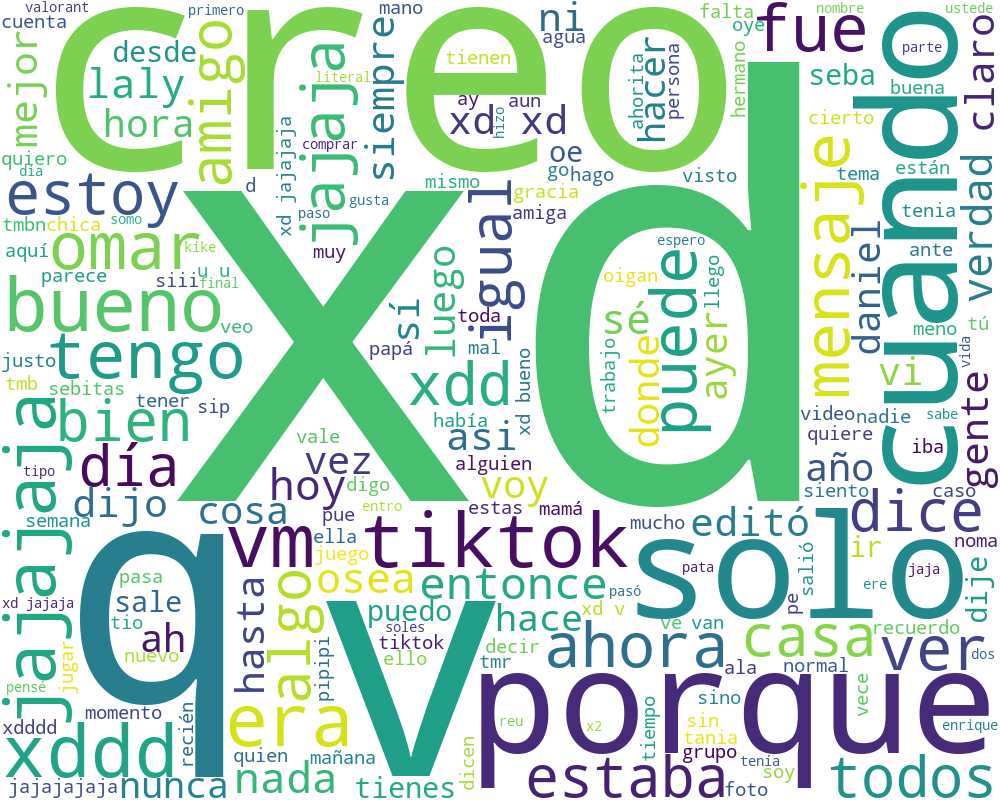

In [142]:
wordcloud.to_image()